# Single GRU optimization
The performance of gradient boosting decision tree and deep neural net models on wildfire risk prediction is underwhelming. The poor performance of these model types may result form their inability to learn from the temporal order of the data. Once can imagine that the weather conditions leading up to a fire are significant causal factor in that fire. Gated recurrent neural networks are designed for time series prediction and may perform better on wildfire risk prediction.

### Goal: 
Optimize and test the performance of a GRU neural network on one California geospatial bin.

### Plan:
1. Prep data from one geospatial bin for input into GRU
2. Generate 'Cassandra' model -> attempt to over fit and 'memorize' the training data. This will prove that the data is feature rich enough and a GRU is complex enough to learn a function which successfully maps input to output.
3. If step 2 is successful, regularize model to increase generalizability.
4. Scale model to predict wilfire risk for all 410 California geospatial bins.

# Notebook setup

In [1]:
import os

import logging
import tensorflow as tf

# Note: tf 2.1.0 give warning about model weight format when
# using class weights. This is the only way to silence without
# updating
tf.get_logger().setLevel(logging.ERROR)
tf.random.set_seed(42)

import numpy as np
np.random.seed(42)

import sys
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn
import joblib

from tensorflow import keras
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras import backend as K
from tensorflow.python.client import device_lib

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns

In [2]:
# Note: sklearn forces depreciation warnings
# This is the only way to silence them without updating
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import confusion_matrix

from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_objective, plot_evaluations
from skopt import gp_minimize

In [3]:
import helper_functions.plotting_functions as plotting_functions
import helper_functions.data_functions as data_functions
import helper_functions.config as config

In [4]:
print(f"Python {sys.version}")
print()
print(f"Pandas {pd.__version__}")
print(f"Tensorflow {tf.__version__}")
print(f"Keras {keras.__version__}")
print(f"SciKit Learn {sklearn.__version__}")
print()

devices = device_lib.list_local_devices()

if 'GPU' in ('').join(str(devices)):
    print("tf accessable GPU found: "+devices[-2].physical_device_desc)

Python 3.7.7 (default, Mar 23 2020, 22:36:06) 
[GCC 7.3.0]

Pandas 1.0.3
Tensorflow 2.2.0
Keras 2.3.0-tf
SciKit Learn 0.23.1

tf accessable GPU found: device: 0, name: GeForce GTX 1070, pci bus id: 0000:02:00.0, compute capability: 6.1


# 1. Data preparation

Let's first load up the data and take a look at what we are working with.

In [6]:
# Load data
data_file = '/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_range_onehot_month_selective_box_cox.parquet'
raw_data = pd.read_parquet(data_file)

# Pick one spatial bin with fires
data = raw_data[(raw_data['raw_lat'] == 39.42233) & (raw_data['raw_lon'] == -120.6546)]

# Also drop unnecessary columns
data.drop([
    'lat',
    'lon',
    'raw_lat',
    'raw_lon',
#     'total_fires',
#     'veg',
    'January',
    'February',
    'March',
    'April',
    'May',
    'June',
    'July',
    'August',
    'Septermber',
    'October',
    'November',
    'December'], axis=1, inplace=True)

data.reset_index(inplace=True, drop=True)

# calculate class weights and initial output bias from ignition frequency in the data 
class_weight = data_functions.get_class_weights(data)
output_bias = data_functions.get_initial_output_bias(data)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8766 entries, 0 to 8765
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   apcp               8766 non-null   float32       
 1   ignition           8766 non-null   int32         
 2   mean_air_2m        8766 non-null   float32       
 3   mean_rhum_2m       8766 non-null   float32       
 4   mean_dpt_2m        8766 non-null   float32       
 5   mean_pres_sfc      8766 non-null   float32       
 6   mean_uwnd_10m      8766 non-null   float32       
 7   mean_vwnd_10m      8766 non-null   float32       
 8   mean_cloud_cover   8766 non-null   float32       
 9   date               8766 non-null   datetime64[ns]
 10  range_air_2m       8766 non-null   float32       
 11  range_rhum_2m      8766 non-null   float32       
 12  range_dpt_2m       8766 non-null   float32       
 13  range_pres_sfc     8766 non-null   float32       
 14  range_uw

Let's take a look at one of our weather variables and ignition. This way after we do our transformations we can be sure by comparison that we did not deform the data.

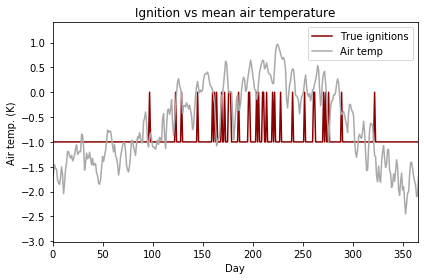

In [7]:
plotting_functions.data_diagnostic_plot(data, 'mean_air_2m', 1, -1)

Looks good, qualitatively, fire season is in late summer and early fall when temperatures are higher.

### Split data into training, validation and testing sets
Note: since temporal order matters here, we cannot simply randomly sample the data - we need to preserve the order. One possible improvement could be to break the data into many smaller ordered chunks and then sample those randomly...

In [8]:
# Split data up into training, testing and validation sets
test_data = data.tail(int(len(data)*0.25))
leftover_data = data.head(int(len(data)*0.75))
validation_data = data.tail(int(len(leftover_data)*0.5))
training_data = data.head(int(len(leftover_data)*0.5))

Let's compare the distributions of each weather variable across the train, validation and test sets just to be sure that our samples are matched to a first approximation.

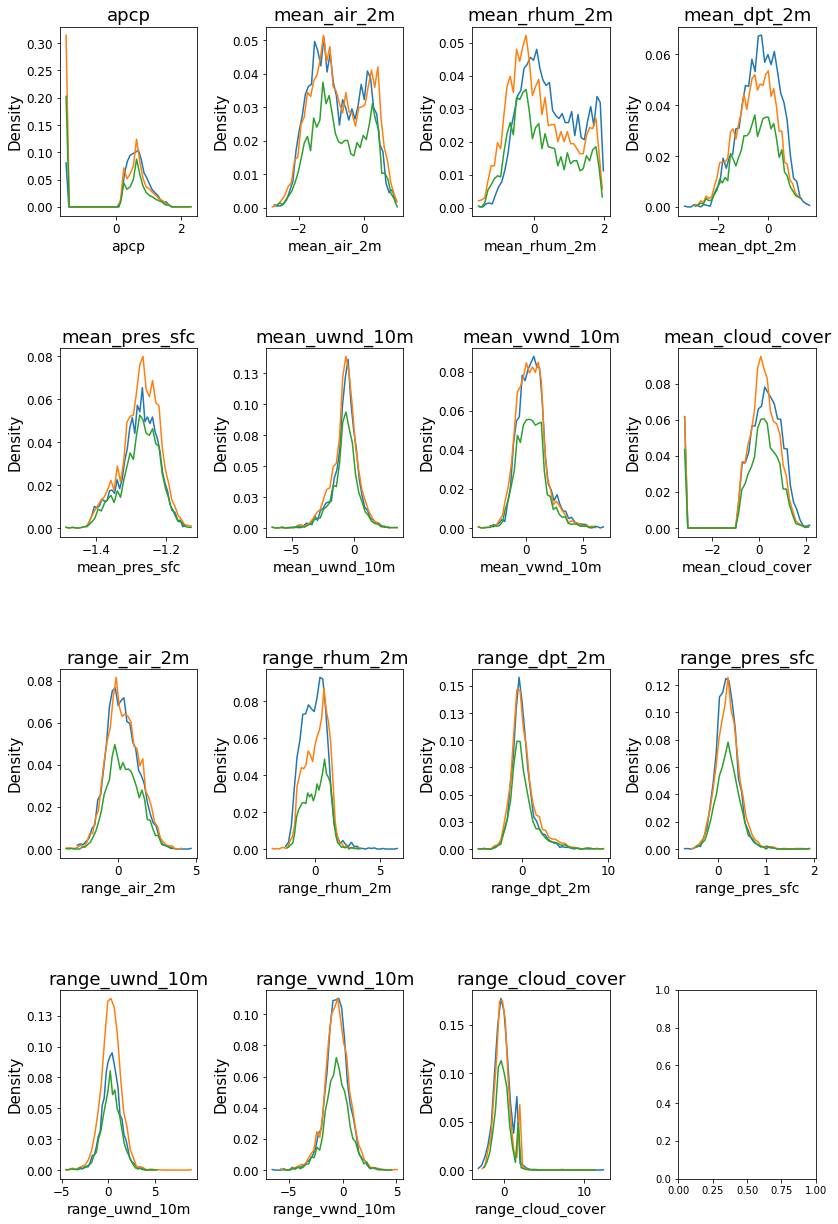

In [13]:
# plot split data distributions
features = [
    'apcp',
#     'crain',
#     'veg',
    'mean_air_2m',       
    'mean_rhum_2m', 
    'mean_dpt_2m', 
    'mean_pres_sfc', 
    'mean_uwnd_10m', 
    'mean_vwnd_10m', 
#     'mean_vis', 
    'mean_cloud_cover',
    'range_air_2m',
    'range_rhum_2m', 
    'range_dpt_2m',
    'range_pres_sfc',
    'range_uwnd_10m',
    'range_vwnd_10m',
#     'range_vis',
    'range_cloud_cover'
]

left = config.left
right = config.right
bottom = config.bottom
top = config.top
wspace = config.wspace
hspace = config.hspace
fig_rows = 4
fig_cols = 4
plot_height = 20
plot_width = config.plot_width

plot_locations = [
    (0,0),(0,1),(0,2),(0,3),
    (1,0),(1,1),(1,2),(1,3),
    (2,0),(2,1),(2,2),(2,3),
    (3,0),(3,1),(3,2),(3,3)#,
#     (4,0),(4,1),(4,2),(4,3)
]

xlabels = features
ylabels = ['Density'] * len(features)

# Make density plots
fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(features)):
    ax[plot_locations[i]] = plotting_functions.three_sample_density_plot(
        ax,
        plot_locations[i], 
        training_data, 
        validation_data, 
        test_data, 
        features[i], 
        features[i], 
        features[i], 
        ylabels[i]
    )
    
plt.show()

Looks pretty good - there are some small differences, but without implementing the time block sampling strategy outlined above there is not much to be done at this point.

Now let's take a quick look at what we have before we build and train our model

In [14]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   apcp               3287 non-null   float32       
 1   ignition           3287 non-null   int32         
 2   mean_air_2m        3287 non-null   float32       
 3   mean_rhum_2m       3287 non-null   float32       
 4   mean_dpt_2m        3287 non-null   float32       
 5   mean_pres_sfc      3287 non-null   float32       
 6   mean_uwnd_10m      3287 non-null   float32       
 7   mean_vwnd_10m      3287 non-null   float32       
 8   mean_cloud_cover   3287 non-null   float32       
 9   date               3287 non-null   datetime64[ns]
 10  range_air_2m       3287 non-null   float32       
 11  range_rhum_2m      3287 non-null   float32       
 12  range_dpt_2m       3287 non-null   float32       
 13  range_pres_sfc     3287 non-null   float32       
 14  range_uw

# 2. GRU optimization - Cassandra model

Goal in this step is to over fit on purpose. This will give us an upper bound on how accurately it is possible to learn this data with an GRU. Then we will regularize the model until it generalizes well.

We will start with 100 GRU units feeding into a 1 unit output layer. We will use binary cross-entropy as our loss function. Since the data is unbalanced we will optimize class weights. Other tunable parameters included in the optimization will be the learning rate and past history size for each sample.

Hyperparameters will be optimized using gaussian process optimization (GPO) on the Matthews correlation coefficient (MCC).

We will also monitor true and false positive and negatives as well as AUC as metrics.

### Set up gaussian process optimization

In [15]:
# metrics to track
metrics = [
    keras.metrics.TruePositives(name='true_positives'),
    keras.metrics.FalsePositives(name='false_positives'),
    keras.metrics.TrueNegatives(name='true_negatives'),
    keras.metrics.FalseNegatives(name='false_negatives'), 
    keras.metrics.AUC(name='auc'),
    data_functions.matthews_correlation,
    data_functions.f1
]

#metrics = config.metrics

# dimensions to include in GPM search space
dim_learning_rate = Real(
    low=0.0001,
    high=0.1, 
    name='learning_rate'
)

dim_past_history = Integer(
    low=4,
    high=28, 
    name='past_history'
)

dim_batch_size = Integer(
    low=16,
    high=1024, 
    name='batch_size'
)

# dim_class_0_weight = Real(
#     low=0.001, 
#     high=10,
#     name='class_0_weight'
# )

# dim_class_1_weight = Real(
#     low=0.01, 
#     high=100,
#     name='class_1_weight'
# )

dimensions = [
    dim_learning_rate,
    dim_past_history,
    dim_batch_size
#     dim_class_0_weight,
#     dim_class_1_weight
]

default_parameters = [0.01, 8, 128]

# Use early stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'matthews_correlation', 
    patience = 10,
    mode = 'max',
    restore_best_weights = True
)

future_target = 1
step = 1
EPOCHS = 25

# also set initial value for output bias based on fire frequency
# raw_output_bias = np.log([num_fires/(total_observations - num_fires)])
# output_bias = tf.keras.initializers.Constant(raw_output_bias)

path_best_model = './trained_models/first_round_single_LSTM_optimization.keras'
best_matthews_correlation = -1.0

run_num = 1

In [18]:
def make_model(
    input_shape,
    learning_rate
):    
    '''Defines simple one input-one output GRU model'''
    
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.GRU(
        100,
        stateful = False,
        dropout = 0.3
    ))
    
    model.add(tf.keras.layers.Dense(
        1,
        activation = 'sigmoid',
        bias_initializer = output_bias)
    )

    model.compile(
        optimizer = tf.keras.optimizers.Adam(lr = learning_rate), 
        loss = keras.losses.BinaryCrossentropy(),
        metrics = metrics
    )

    return model

@use_named_args(dimensions=dimensions)
def fitness(
    learning_rate,
    past_history,
    batch_size
#     class_0_weight,
#     class_1_weight
):
    '''Takes set of tuneable parameter and search space dimensions
    runs GPO on model, returns model fitness, metrics and hyperparameter
    setting for each itteration'''
    
    # calculate batch, and steps from data size and past history
    #batch_size = int((len(training_data) * 0.99) // past_history)
    steps_per_epoch = int(len(training_data) // batch_size)
    validation_steps = int(len(validation_data) // batch_size)
    
    dataset_len = len(training_data)
    ignition_count = sum(training_data['ignition'])
    no_ignition_count = dataset_len - ignition_count
    
    weight_for_0 = (1 / no_ignition_count)*(dataset_len)/2.0 
    weight_for_1 = (1 / ignition_count)*(dataset_len)/2.0

    class_weight = {0: weight_for_0, 1: weight_for_1}
    
    # create training and vaildation data 
    x_train, y_train = data_functions.multivariate_data(
        training_data,
        past_history,
        future_target, 
        step
    )
    
    x_validation, y_validation = data_functions.multivariate_data(
        validation_data,
        past_history,
        future_target, 
        step
    )
    
    
    # trim datasets so they are whole number multiples of the batch
    # size (needed for statefull LSTM)
    start_index = (x_train.shape[0] - (x_train.shape[0] % batch_size))
    end_index = x_train.shape[0]
    
    x_train = np.delete(x_train, range(start_index, end_index), axis=0)
    y_train = np.delete(y_train, range(start_index, end_index), axis=0)
    
    start_index = (x_validation.shape[0] - (x_validation.shape[0] % batch_size))
    end_index = x_validation.shape[0]
    
    x_validation = np.delete(x_validation, range(start_index, end_index), axis=0)
    y_validation = np.delete(y_validation, range(start_index, end_index), axis=0)
    
    input_dim = x_train.shape[-2:]
    input_shape = (batch_size, input_dim[0], input_dim[1])
    
    # Create the neural network with these hyper-parameters.
    model = make_model(
        input_shape,
        learning_rate
    )
    
    # Create a callback-function for Keras which will be
    # run after each epoch has ended during training.
    # This saves the log-files for TensorBoard.
    # Note that there are complications when histogram_freq=1.
    # It might give strange errors and it also does not properly
    # support Keras data-generators for the validation-set.
    global run_num
    
    # Set up tensorboard logging callback
    log_dir = f'./LSTM_logs/single_statefull_gp_min_run{run_num}/'
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
   
    # Use Keras to train the model.
    history = model.fit(
        x_train,
        y_train,
        epochs = EPOCHS,
        batch_size = batch_size,
        steps_per_epoch = steps_per_epoch,
        callbacks = [early_stopping_callback],
        validation_data = (x_validation, y_validation),
        validation_steps = validation_steps,
        class_weight = class_weight,
        workers = 8,
        verbose = 1
    )

    # Get MCC for training run
    matthews_correlation = history.history['matthews_correlation'][-1]

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_matthews_correlation

    # If the MCC of the saved model is improved ...
    if matthews_correlation > best_matthews_correlation:
        # Save the new model to harddisk.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_matthews_correlation = matthews_correlation
        
    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    
    run_num += 1
    
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST MCC, we need to 
    # negate this number so it can be minimized.
    return -matthews_correlation

### Run gaussian process optimization

In [19]:
%%time

# do the optimization run
search_result = gp_minimize(
    func=fitness,
    dimensions=dimensions,
    acq_func='EI', # Expected Improvement.
    n_calls=100,
    x0=default_parameters
)

Epoch 1/25
25/25 [==============================] - 1s 55ms/step - loss: 0.7169 - true_positives: 85.0000 - false_positives: 970.0000 - true_negatives: 2186.0000 - false_negatives: 61.0000 - auc: 0.6916 - matthews_correlation: 0.1291 - f1: 0.1350 - val_loss: 0.5485 - val_true_positives: 113.0000 - val_false_positives: 1029.0000 - val_true_negatives: 2036.0000 - val_false_negatives: 22.0000 - val_auc: 0.7789 - val_matthews_correlation: 0.0883 - val_f1: 0.1207
Epoch 2/25
25/25 [==============================] - 1s 24ms/step - loss: 0.5919 - true_positives: 115.0000 - false_positives: 1170.0000 - true_negatives: 1889.0000 - false_negatives: 26.0000 - auc: 0.7706 - matthews_correlation: 0.1871 - f1: 0.1629 - val_loss: 0.5986 - val_true_positives: 109.0000 - val_false_positives: 1174.0000 - val_true_negatives: 1891.0000 - val_false_negatives: 26.0000 - val_auc: 0.7693 - val_matthews_correlation: 0.0715 - val_f1: 0.1096
Epoch 3/25
25/25 [==============================] - 1s 23ms/step - loss:

Epoch 19/25
25/25 [==============================] - 1s 24ms/step - loss: 0.3532 - true_positives: 127.0000 - false_positives: 616.0000 - true_negatives: 2443.0000 - false_negatives: 14.0000 - auc: 0.9164 - matthews_correlation: 0.3414 - f1: 0.2876 - val_loss: 0.4957 - val_true_positives: 95.0000 - val_false_positives: 833.0000 - val_true_negatives: 2232.0000 - val_false_negatives: 40.0000 - val_auc: 0.7720 - val_matthews_correlation: 0.0798 - val_f1: 0.1102
Epoch 20/25
25/25 [==============================] - 1s 25ms/step - loss: 0.3730 - true_positives: 128.0000 - false_positives: 699.0000 - true_negatives: 2360.0000 - false_negatives: 13.0000 - auc: 0.8998 - matthews_correlation: 0.3176 - f1: 0.2649 - val_loss: 0.7847 - val_true_positives: 109.0000 - val_false_positives: 1240.0000 - val_true_negatives: 1825.0000 - val_false_negatives: 26.0000 - val_auc: 0.7336 - val_matthews_correlation: 0.0757 - val_f1: 0.1093
Epoch 21/25
25/25 [==============================] - 1s 25ms/step - loss

Epoch 12/25
4/4 [==============================] - 0s 32ms/step - loss: 0.4471 - true_positives: 104.0000 - false_positives: 842.0000 - true_negatives: 1856.0000 - false_negatives: 18.0000 - auc: 0.8503 - matthews_correlation: 0.2337 - f1: 0.1945 - val_loss: 0.6216 - val_true_positives: 105.0000 - val_false_positives: 1042.0000 - val_true_negatives: 1658.0000 - val_false_negatives: 15.0000 - val_auc: 0.7902 - val_matthews_correlation: 0.1987 - val_f1: 0.1644
Epoch 13/25
4/4 [==============================] - 0s 33ms/step - loss: 0.4606 - true_positives: 109.0000 - false_positives: 965.0000 - true_negatives: 1733.0000 - false_negatives: 13.0000 - auc: 0.8517 - matthews_correlation: 0.2273 - f1: 0.1828 - val_loss: 0.6279 - val_true_positives: 105.0000 - val_false_positives: 1105.0000 - val_true_negatives: 1595.0000 - val_false_negatives: 15.0000 - val_auc: 0.7687 - val_matthews_correlation: 0.1880 - val_f1: 0.1566
Epoch 14/25
4/4 [==============================] - 0s 32ms/step - loss: 0.

Epoch 5/25
7/7 [==============================] - 0s 37ms/step - loss: 0.5368 - true_positives: 98.0000 - false_positives: 836.0000 - true_negatives: 1935.0000 - false_negatives: 29.0000 - auc: 0.8035 - matthews_correlation: 0.2045 - f1: 0.1841 - val_loss: 0.5297 - val_true_positives: 93.0000 - val_false_positives: 931.0000 - val_true_negatives: 1847.0000 - val_false_negatives: 27.0000 - val_auc: 0.7638 - val_matthews_correlation: 0.1848 - val_f1: 0.1635
Epoch 6/25
7/7 [==============================] - 0s 33ms/step - loss: 0.5534 - true_positives: 101.0000 - false_positives: 1014.0000 - true_negatives: 1757.0000 - false_negatives: 26.0000 - auc: 0.7850 - matthews_correlation: 0.1757 - f1: 0.1601 - val_loss: 0.3666 - val_true_positives: 54.0000 - val_false_positives: 521.0000 - val_true_negatives: 2257.0000 - val_false_negatives: 66.0000 - val_auc: 0.7690 - val_matthews_correlation: 0.1253 - val_f1: 0.1500
Epoch 7/25
7/7 [==============================] - 0s 35ms/step - loss: 0.5369 - 

Epoch 23/25
7/7 [==============================] - 0s 35ms/step - loss: 0.4654 - true_positives: 109.0000 - false_positives: 847.0000 - true_negatives: 1924.0000 - false_negatives: 18.0000 - auc: 0.8537 - matthews_correlation: 0.2397 - f1: 0.2004 - val_loss: 0.5593 - val_true_positives: 90.0000 - val_false_positives: 903.0000 - val_true_negatives: 1875.0000 - val_false_negatives: 30.0000 - val_auc: 0.7670 - val_matthews_correlation: 0.1791 - val_f1: 0.1615
Epoch 24/25
7/7 [==============================] - 0s 33ms/step - loss: 0.4947 - true_positives: 106.0000 - false_positives: 780.0000 - true_negatives: 1991.0000 - false_negatives: 21.0000 - auc: 0.8306 - matthews_correlation: 0.2480 - f1: 0.2150 - val_loss: 0.6066 - val_true_positives: 94.0000 - val_false_positives: 961.0000 - val_true_negatives: 1817.0000 - val_false_negatives: 26.0000 - val_auc: 0.7556 - val_matthews_correlation: 0.1808 - val_f1: 0.1595
Epoch 25/25
7/7 [==============================] - 0s 34ms/step - loss: 0.4609

Epoch 16/25
5/5 [==============================] - 0s 38ms/step - loss: 0.4711 - true_positives: 111.0000 - false_positives: 885.0000 - true_negatives: 2023.0000 - false_negatives: 16.0000 - auc: 0.8360 - matthews_correlation: 0.2439 - f1: 0.1979 - val_loss: 0.4420 - val_true_positives: 85.0000 - val_false_positives: 776.0000 - val_true_negatives: 2139.0000 - val_false_negatives: 35.0000 - val_auc: 0.7816 - val_matthews_correlation: 0.1922 - val_f1: 0.1759
Epoch 17/25
5/5 [==============================] - 0s 37ms/step - loss: 0.4595 - true_positives: 112.0000 - false_positives: 860.0000 - true_negatives: 2048.0000 - false_negatives: 15.0000 - auc: 0.8366 - matthews_correlation: 0.2497 - f1: 0.2026 - val_loss: 0.4232 - val_true_positives: 84.0000 - val_false_positives: 744.0000 - val_true_negatives: 2171.0000 - val_false_negatives: 36.0000 - val_auc: 0.7876 - val_matthews_correlation: 0.1966 - val_f1: 0.1805
Epoch 18/25
5/5 [==============================] - 0s 38ms/step - loss: 0.4769

Epoch 9/25
36/36 [==============================] - 2s 42ms/step - loss: 0.6621 - true_positives: 110.0000 - false_positives: 1047.0000 - true_negatives: 2077.0000 - false_negatives: 42.0000 - auc: 0.7549 - matthews_correlation: 0.1743 - f1: 0.1702 - val_loss: 0.7629 - val_true_positives: 115.0000 - val_false_positives: 1165.0000 - val_true_negatives: 1885.0000 - val_false_negatives: 20.0000 - val_auc: 0.7713 - val_matthews_correlation: 0.0417 - val_f1: 0.0879
Epoch 10/25
36/36 [==============================] - 1s 41ms/step - loss: 0.5307 - true_positives: 104.0000 - false_positives: 925.0000 - true_negatives: 2214.0000 - false_negatives: 33.0000 - auc: 0.7999 - matthews_correlation: 0.1875 - f1: 0.1689 - val_loss: 1.2813 - val_true_positives: 124.0000 - val_false_positives: 1458.0000 - val_true_negatives: 1592.0000 - val_false_negatives: 11.0000 - val_auc: 0.7784 - val_matthews_correlation: 0.0300 - val_f1: 0.0819
Epoch 11/25
36/36 [==============================] - 1s 41ms/step - lo

Epoch 2/25
3/3 [==============================] - 0s 35ms/step - loss: 0.6930 - true_positives: 82.0000 - false_positives: 1049.0000 - true_negatives: 1809.0000 - false_negatives: 45.0000 - auc: 0.7004 - matthews_correlation: 0.1207 - f1: 0.1324 - val_loss: 0.6103 - val_true_positives: 98.0000 - val_false_positives: 1174.0000 - val_true_negatives: 1691.0000 - val_false_negatives: 22.0000 - val_auc: 0.7634 - val_matthews_correlation: 0.1600 - val_f1: 0.1393
Epoch 3/25
3/3 [==============================] - 0s 37ms/step - loss: 0.5594 - true_positives: 85.0000 - false_positives: 800.0000 - true_negatives: 2058.0000 - false_negatives: 42.0000 - auc: 0.7729 - matthews_correlation: 0.1686 - f1: 0.1651 - val_loss: 0.7188 - val_true_positives: 106.0000 - val_false_positives: 1152.0000 - val_true_negatives: 1713.0000 - val_false_negatives: 14.0000 - val_auc: 0.7933 - val_matthews_correlation: 0.1874 - val_f1: 0.1514
Epoch 4/25
3/3 [==============================] - 0s 33ms/step - loss: 0.5148 

Epoch 20/25
3/3 [==============================] - 0s 36ms/step - loss: 0.4057 - true_positives: 108.0000 - false_positives: 734.0000 - true_negatives: 2124.0000 - false_negatives: 19.0000 - auc: 0.8815 - matthews_correlation: 0.2650 - f1: 0.2223 - val_loss: 0.4709 - val_true_positives: 84.0000 - val_false_positives: 845.0000 - val_true_negatives: 2020.0000 - val_false_negatives: 36.0000 - val_auc: 0.7607 - val_matthews_correlation: 0.1678 - val_f1: 0.1575
Epoch 21/25
3/3 [==============================] - 0s 37ms/step - loss: 0.3853 - true_positives: 113.0000 - false_positives: 749.0000 - true_negatives: 2109.0000 - false_negatives: 14.0000 - auc: 0.8910 - matthews_correlation: 0.2788 - f1: 0.2283 - val_loss: 0.6288 - val_true_positives: 98.0000 - val_false_positives: 1053.0000 - val_true_negatives: 1812.0000 - val_false_negatives: 22.0000 - val_auc: 0.7812 - val_matthews_correlation: 0.1763 - val_f1: 0.1512
Epoch 22/25
3/3 [==============================] - 0s 38ms/step - loss: 0.417

Epoch 13/25
6/6 [==============================] - 0s 32ms/step - loss: 0.4787 - true_positives: 125.0000 - false_positives: 1024.0000 - true_negatives: 2010.0000 - false_negatives: 15.0000 - auc: 0.8299 - matthews_correlation: 0.2388 - f1: 0.1950 - val_loss: 0.6535 - val_true_positives: 116.0000 - val_false_positives: 1187.0000 - val_true_negatives: 1854.0000 - val_false_negatives: 17.0000 - val_auc: 0.7787 - val_matthews_correlation: 0.1891 - val_f1: 0.1567
Epoch 14/25
6/6 [==============================] - 0s 31ms/step - loss: 0.4856 - true_positives: 122.0000 - false_positives: 937.0000 - true_negatives: 2097.0000 - false_negatives: 18.0000 - auc: 0.8278 - matthews_correlation: 0.2443 - f1: 0.2033 - val_loss: 0.6040 - val_true_positives: 113.0000 - val_false_positives: 1052.0000 - val_true_negatives: 1989.0000 - val_false_negatives: 20.0000 - val_auc: 0.7900 - val_matthews_correlation: 0.2047 - val_f1: 0.1710
Epoch 15/25
6/6 [==============================] - 0s 32ms/step - loss: 0

Epoch 6/25
13/13 [==============================] - 0s 35ms/step - loss: 0.4697 - true_positives: 119.0000 - false_positives: 1019.0000 - true_negatives: 1920.0000 - false_negatives: 10.0000 - auc: 0.8292 - matthews_correlation: 0.2379 - f1: 0.1866 - val_loss: 0.5409 - val_true_positives: 102.0000 - val_false_positives: 1040.0000 - val_true_negatives: 1907.0000 - val_false_negatives: 19.0000 - val_auc: 0.7817 - val_matthews_correlation: 0.1653 - val_f1: 0.1445
Epoch 7/25
13/13 [==============================] - 0s 32ms/step - loss: 0.4452 - true_positives: 116.0000 - false_positives: 961.0000 - true_negatives: 1978.0000 - false_negatives: 13.0000 - auc: 0.8410 - matthews_correlation: 0.2396 - f1: 0.1911 - val_loss: 0.5262 - val_true_positives: 94.0000 - val_false_positives: 1031.0000 - val_true_negatives: 1916.0000 - val_false_negatives: 27.0000 - val_auc: 0.7662 - val_matthews_correlation: 0.1445 - val_f1: 0.1361
Epoch 8/25
13/13 [==============================] - 0s 35ms/step - loss:

Epoch 24/25
13/13 [==============================] - 0s 34ms/step - loss: 0.2677 - true_positives: 120.0000 - false_positives: 484.0000 - true_negatives: 2455.0000 - false_negatives: 9.0000 - auc: 0.9479 - matthews_correlation: 0.3863 - f1: 0.3258 - val_loss: 0.4511 - val_true_positives: 55.0000 - val_false_positives: 668.0000 - val_true_negatives: 2279.0000 - val_false_negatives: 66.0000 - val_auc: 0.7557 - val_matthews_correlation: 0.1015 - val_f1: 0.1230
Epoch 25/25
13/13 [==============================] - 0s 32ms/step - loss: 0.2515 - true_positives: 120.0000 - false_positives: 430.0000 - true_negatives: 2509.0000 - false_negatives: 9.0000 - auc: 0.9521 - matthews_correlation: 0.4036 - f1: 0.3472 - val_loss: 0.4777 - val_true_positives: 51.0000 - val_false_positives: 649.0000 - val_true_negatives: 2298.0000 - val_false_negatives: 70.0000 - val_auc: 0.7486 - val_matthews_correlation: 0.0718 - val_f1: 0.0982
Epoch 1/25
10/10 [==============================] - 1s 110ms/step - loss: 1.

10/10 [==============================] - 0s 31ms/step - loss: 0.5766 - true_positives: 110.0000 - false_positives: 973.0000 - true_negatives: 2113.0000 - false_negatives: 34.0000 - auc: 0.7706 - matthews_correlation: 0.1951 - f1: 0.1797 - val_loss: 0.5837 - val_true_positives: 100.0000 - val_false_positives: 1042.0000 - val_true_negatives: 2051.0000 - val_false_negatives: 37.0000 - val_auc: 0.7514 - val_matthews_correlation: 0.1590 - val_f1: 0.1505
Epoch 17/25
10/10 [==============================] - 0s 31ms/step - loss: 0.5862 - true_positives: 106.0000 - false_positives: 971.0000 - true_negatives: 2115.0000 - false_negatives: 38.0000 - auc: 0.7613 - matthews_correlation: 0.1841 - f1: 0.1729 - val_loss: 0.5910 - val_true_positives: 100.0000 - val_false_positives: 1061.0000 - val_true_negatives: 2032.0000 - val_false_negatives: 37.0000 - val_auc: 0.7558 - val_matthews_correlation: 0.1557 - val_f1: 0.1481
Epoch 18/25
10/10 [==============================] - 0s 31ms/step - loss: 0.5631 -

Epoch 9/25
4/4 [==============================] - 0s 38ms/step - loss: 0.4592 - true_positives: 112.0000 - false_positives: 919.0000 - true_negatives: 1890.0000 - false_negatives: 15.0000 - auc: 0.8324 - matthews_correlation: 0.2354 - f1: 0.1930 - val_loss: 0.5852 - val_true_positives: 105.0000 - val_false_positives: 1115.0000 - val_true_negatives: 1701.0000 - val_false_negatives: 15.0000 - val_auc: 0.7821 - val_matthews_correlation: 0.1921 - val_f1: 0.1562
Epoch 10/25
4/4 [==============================] - 0s 41ms/step - loss: 0.4442 - true_positives: 117.0000 - false_positives: 968.0000 - true_negatives: 1841.0000 - false_negatives: 10.0000 - auc: 0.8443 - matthews_correlation: 0.2420 - f1: 0.1925 - val_loss: 0.5563 - val_true_positives: 102.0000 - val_false_positives: 1041.0000 - val_true_negatives: 1775.0000 - val_false_negatives: 18.0000 - val_auc: 0.7868 - val_matthews_correlation: 0.1937 - val_f1: 0.1606
Epoch 11/25
4/4 [==============================] - 0s 40ms/step - loss: 0.4

Epoch 2/25
6/6 [==============================] - 0s 26ms/step - loss: 0.6366 - true_positives: 56.0000 - false_positives: 546.0000 - true_negatives: 2381.0000 - false_negatives: 71.0000 - auc: 0.7568 - matthews_correlation: 0.1303 - f1: 0.1526 - val_loss: 0.7450 - val_true_positives: 104.0000 - val_false_positives: 1228.0000 - val_true_negatives: 1706.0000 - val_false_negatives: 16.0000 - val_auc: 0.7695 - val_matthews_correlation: 0.1689 - val_f1: 0.1376
Epoch 3/25
6/6 [==============================] - 0s 24ms/step - loss: 0.5442 - true_positives: 108.0000 - false_positives: 1116.0000 - true_negatives: 1811.0000 - false_negatives: 19.0000 - auc: 0.7888 - matthews_correlation: 0.1915 - f1: 0.1593 - val_loss: 0.5308 - val_true_positives: 95.0000 - val_false_positives: 925.0000 - val_true_negatives: 2009.0000 - val_false_negatives: 25.0000 - val_auc: 0.7774 - val_matthews_correlation: 0.1944 - val_f1: 0.1627
Epoch 4/25
6/6 [==============================] - 0s 25ms/step - loss: 0.5075 

Epoch 20/25
6/6 [==============================] - 0s 26ms/step - loss: 0.3349 - true_positives: 123.0000 - false_positives: 681.0000 - true_negatives: 2246.0000 - false_negatives: 4.0000 - auc: 0.9205 - matthews_correlation: 0.3342 - f1: 0.2651 - val_loss: 0.5354 - val_true_positives: 69.0000 - val_false_positives: 877.0000 - val_true_negatives: 2057.0000 - val_false_negatives: 51.0000 - val_auc: 0.7185 - val_matthews_correlation: 0.1059 - val_f1: 0.1209
Epoch 21/25
6/6 [==============================] - 0s 27ms/step - loss: 0.3643 - true_positives: 112.0000 - false_positives: 646.0000 - true_negatives: 2281.0000 - false_negatives: 15.0000 - auc: 0.9040 - matthews_correlation: 0.3071 - f1: 0.2538 - val_loss: 0.6165 - val_true_positives: 87.0000 - val_false_positives: 933.0000 - val_true_negatives: 2001.0000 - val_false_negatives: 33.0000 - val_auc: 0.7499 - val_matthews_correlation: 0.1638 - val_f1: 0.1468
Epoch 22/25
6/6 [==============================] - 0s 26ms/step - loss: 0.3079 

Epoch 13/25
9/9 [==============================] - 0s 40ms/step - loss: 0.3799 - true_positives: 118.0000 - false_positives: 825.0000 - true_negatives: 2054.0000 - false_negatives: 9.0000 - auc: 0.8842 - matthews_correlation: 0.2775 - f1: 0.2186 - val_loss: 0.5047 - val_true_positives: 81.0000 - val_false_positives: 860.0000 - val_true_negatives: 2026.0000 - val_false_negatives: 39.0000 - val_auc: 0.7427 - val_matthews_correlation: 0.1539 - val_f1: 0.1496
Epoch 14/25
9/9 [==============================] - 0s 39ms/step - loss: 0.3616 - true_positives: 119.0000 - false_positives: 742.0000 - true_negatives: 2137.0000 - false_negatives: 8.0000 - auc: 0.8963 - matthews_correlation: 0.2984 - f1: 0.2386 - val_loss: 0.5282 - val_true_positives: 89.0000 - val_false_positives: 832.0000 - val_true_negatives: 2054.0000 - val_false_negatives: 31.0000 - val_auc: 0.7723 - val_matthews_correlation: 0.1897 - val_f1: 0.1682
Epoch 15/25
9/9 [==============================] - 0s 40ms/step - loss: 0.3590 -

Epoch 6/25
12/12 [==============================] - 0s 34ms/step - loss: 0.4791 - true_positives: 120.0000 - false_positives: 974.0000 - true_negatives: 2065.0000 - false_negatives: 21.0000 - auc: 0.8291 - matthews_correlation: 0.2268 - f1: 0.1943 - val_loss: 0.6481 - val_true_positives: 121.0000 - val_false_positives: 1251.0000 - val_true_negatives: 1794.0000 - val_false_negatives: 14.0000 - val_auc: 0.7650 - val_matthews_correlation: 0.1806 - val_f1: 0.1495
Epoch 7/25
12/12 [==============================] - 0s 37ms/step - loss: 0.4821 - true_positives: 128.0000 - false_positives: 1071.0000 - true_negatives: 1968.0000 - false_negatives: 13.0000 - auc: 0.8397 - matthews_correlation: 0.2354 - f1: 0.1914 - val_loss: 0.4906 - val_true_positives: 105.0000 - val_false_positives: 1016.0000 - val_true_negatives: 2029.0000 - val_false_negatives: 30.0000 - val_auc: 0.7703 - val_matthews_correlation: 0.1688 - val_f1: 0.1568
Epoch 8/25
12/12 [==============================] - 0s 35ms/step - loss

Epoch 24/25
12/12 [==============================] - 0s 37ms/step - loss: 0.3090 - true_positives: 124.0000 - false_positives: 518.0000 - true_negatives: 2521.0000 - false_negatives: 17.0000 - auc: 0.9351 - matthews_correlation: 0.3650 - f1: 0.3189 - val_loss: 0.5253 - val_true_positives: 77.0000 - val_false_positives: 795.0000 - val_true_negatives: 2250.0000 - val_false_negatives: 58.0000 - val_auc: 0.7474 - val_matthews_correlation: 0.1241 - val_f1: 0.1458
Epoch 25/25
12/12 [==============================] - 0s 35ms/step - loss: 0.3064 - true_positives: 129.0000 - false_positives: 599.0000 - true_negatives: 2440.0000 - false_negatives: 12.0000 - auc: 0.9345 - matthews_correlation: 0.3585 - f1: 0.3059 - val_loss: 0.3882 - val_true_positives: 62.0000 - val_false_positives: 604.0000 - val_true_negatives: 2441.0000 - val_false_negatives: 73.0000 - val_auc: 0.7463 - val_matthews_correlation: 0.1033 - val_f1: 0.1321
Epoch 1/25
12/12 [==============================] - 1s 91ms/step - loss: 0

Epoch 17/25
12/12 [==============================] - 0s 25ms/step - loss: 0.3581 - true_positives: 125.0000 - false_positives: 643.0000 - true_negatives: 2387.0000 - false_negatives: 13.0000 - auc: 0.9145 - matthews_correlation: 0.3283 - f1: 0.2743 - val_loss: 0.5665 - val_true_positives: 83.0000 - val_false_positives: 856.0000 - val_true_negatives: 2180.0000 - val_false_negatives: 49.0000 - val_auc: 0.7513 - val_matthews_correlation: 0.1389 - val_f1: 0.1483
Epoch 18/25
12/12 [==============================] - 0s 24ms/step - loss: 0.3730 - true_positives: 121.0000 - false_positives: 644.0000 - true_negatives: 2386.0000 - false_negatives: 17.0000 - auc: 0.9092 - matthews_correlation: 0.3113 - f1: 0.2630 - val_loss: 0.6725 - val_true_positives: 101.0000 - val_false_positives: 1108.0000 - val_true_negatives: 1928.0000 - val_false_negatives: 31.0000 - val_auc: 0.7605 - val_matthews_correlation: 0.1567 - val_f1: 0.1462
Epoch 19/25
12/12 [==============================] - 0s 25ms/step - loss

Epoch 10/25
12/12 [==============================] - 0s 25ms/step - loss: 0.4557 - true_positives: 130.0000 - false_positives: 980.0000 - true_negatives: 2092.0000 - false_negatives: 14.0000 - auc: 0.8482 - matthews_correlation: 0.2536 - f1: 0.2078 - val_loss: 0.6558 - val_true_positives: 109.0000 - val_false_positives: 1221.0000 - val_true_negatives: 1859.0000 - val_false_negatives: 27.0000 - val_auc: 0.7527 - val_matthews_correlation: 0.1446 - val_f1: 0.1371
Epoch 11/25
12/12 [==============================] - 0s 26ms/step - loss: 0.4337 - true_positives: 128.0000 - false_positives: 879.0000 - true_negatives: 2193.0000 - false_negatives: 16.0000 - auc: 0.8721 - matthews_correlation: 0.2709 - f1: 0.2244 - val_loss: 0.7276 - val_true_positives: 118.0000 - val_false_positives: 1170.0000 - val_true_negatives: 1910.0000 - val_false_negatives: 18.0000 - val_auc: 0.7811 - val_matthews_correlation: 0.1856 - val_f1: 0.1554
Epoch 12/25
12/12 [==============================] - 0s 23ms/step - lo

Epoch 3/25
10/10 [==============================] - 0s 47ms/step - loss: 0.5394 - true_positives: 120.0000 - false_positives: 1059.0000 - true_negatives: 1961.0000 - false_negatives: 20.0000 - auc: 0.7876 - matthews_correlation: 0.2175 - f1: 0.1821 - val_loss: 0.7183 - val_true_positives: 127.0000 - val_false_positives: 1333.0000 - val_true_negatives: 1693.0000 - val_false_negatives: 7.0000 - val_auc: 0.7940 - val_matthews_correlation: 0.1985 - val_f1: 0.1555
Epoch 4/25
10/10 [==============================] - 0s 48ms/step - loss: 0.5102 - true_positives: 118.0000 - false_positives: 1034.0000 - true_negatives: 1986.0000 - false_negatives: 22.0000 - auc: 0.7977 - matthews_correlation: 0.2165 - f1: 0.1840 - val_loss: 0.7748 - val_true_positives: 126.0000 - val_false_positives: 1364.0000 - val_true_negatives: 1662.0000 - val_false_negatives: 8.0000 - val_auc: 0.7957 - val_matthews_correlation: 0.1884 - val_f1: 0.1511
Epoch 5/25
10/10 [==============================] - 0s 50ms/step - loss:

Epoch 21/25
10/10 [==============================] - 0s 46ms/step - loss: 0.3441 - true_positives: 129.0000 - false_positives: 686.0000 - true_negatives: 2334.0000 - false_negatives: 11.0000 - auc: 0.9156 - matthews_correlation: 0.3251 - f1: 0.2691 - val_loss: 0.5533 - val_true_positives: 92.0000 - val_false_positives: 899.0000 - val_true_negatives: 2127.0000 - val_false_negatives: 42.0000 - val_auc: 0.7710 - val_matthews_correlation: 0.1655 - val_f1: 0.1597
Epoch 22/25
10/10 [==============================] - 0s 48ms/step - loss: 0.3086 - true_positives: 134.0000 - false_positives: 666.0000 - true_negatives: 2354.0000 - false_negatives: 6.0000 - auc: 0.9321 - matthews_correlation: 0.3478 - f1: 0.2852 - val_loss: 0.3617 - val_true_positives: 60.0000 - val_false_positives: 551.0000 - val_true_negatives: 2475.0000 - val_false_negatives: 74.0000 - val_auc: 0.7641 - val_matthews_correlation: 0.1302 - val_f1: 0.1552
Epoch 23/25
10/10 [==============================] - 0s 47ms/step - loss: 0

Epoch 14/25
22/22 [==============================] - 0s 19ms/step - loss: 0.4338 - true_positives: 129.0000 - false_positives: 976.0000 - true_negatives: 2094.0000 - false_negatives: 13.0000 - auc: 0.8580 - matthews_correlation: 0.2535 - f1: 0.2046 - val_loss: 0.5603 - val_true_positives: 102.0000 - val_false_positives: 1097.0000 - val_true_negatives: 1979.0000 - val_false_negatives: 34.0000 - val_auc: 0.7651 - val_matthews_correlation: 0.0909 - val_f1: 0.1126
Epoch 15/25
22/22 [==============================] - 0s 18ms/step - loss: 0.4197 - true_positives: 126.0000 - false_positives: 805.0000 - true_negatives: 2265.0000 - false_negatives: 16.0000 - auc: 0.8779 - matthews_correlation: 0.2763 - f1: 0.2338 - val_loss: 0.6915 - val_true_positives: 115.0000 - val_false_positives: 1282.0000 - val_true_negatives: 1794.0000 - val_false_negatives: 21.0000 - val_auc: 0.7593 - val_matthews_correlation: 0.0948 - val_f1: 0.1098
Epoch 16/25
22/22 [==============================] - 0s 18ms/step - lo

Epoch 7/25
5/5 [==============================] - 0s 48ms/step - loss: 0.4870 - true_positives: 109.0000 - false_positives: 906.0000 - true_negatives: 2071.0000 - false_negatives: 24.0000 - auc: 0.8206 - matthews_correlation: 0.2212 - f1: 0.1889 - val_loss: 0.5501 - val_true_positives: 107.0000 - val_false_positives: 1041.0000 - val_true_negatives: 1942.0000 - val_false_negatives: 20.0000 - val_auc: 0.7954 - val_matthews_correlation: 0.2037 - val_f1: 0.1694
Epoch 8/25
5/5 [==============================] - 0s 48ms/step - loss: 0.4834 - true_positives: 117.0000 - false_positives: 1012.0000 - true_negatives: 1965.0000 - false_negatives: 16.0000 - auc: 0.8251 - matthews_correlation: 0.2264 - f1: 0.1847 - val_loss: 0.6109 - val_true_positives: 114.0000 - val_false_positives: 1155.0000 - val_true_negatives: 1828.0000 - val_false_negatives: 13.0000 - val_auc: 0.7934 - val_matthews_correlation: 0.2060 - val_f1: 0.1640
Epoch 9/25
5/5 [==============================] - 0s 47ms/step - loss: 0.46

Epoch 25/25
5/5 [==============================] - 0s 44ms/step - loss: 0.3099 - true_positives: 123.0000 - false_positives: 566.0000 - true_negatives: 2411.0000 - false_negatives: 10.0000 - auc: 0.9329 - matthews_correlation: 0.3530 - f1: 0.2962 - val_loss: 0.5149 - val_true_positives: 86.0000 - val_false_positives: 810.0000 - val_true_negatives: 2173.0000 - val_false_negatives: 41.0000 - val_auc: 0.7825 - val_matthews_correlation: 0.1744 - val_f1: 0.1653
Epoch 1/25
15/15 [==============================] - 1s 87ms/step - loss: 0.7598 - true_positives: 176.0000 - false_positives: 1802.0000 - true_negatives: 4262.0000 - false_negatives: 95.0000 - auc: 0.7390 - matthews_correlation: 0.1462 - f1: 0.1391 - val_loss: 0.5925 - val_true_positives: 108.0000 - val_false_positives: 1068.0000 - val_true_negatives: 2020.0000 - val_false_negatives: 29.0000 - val_auc: 0.7658 - val_matthews_correlation: 0.1464 - val_f1: 0.1404
Epoch 2/25
15/15 [==============================] - 1s 35ms/step - loss: 0

Epoch 18/25
15/15 [==============================] - 1s 35ms/step - loss: 0.3640 - true_positives: 132.0000 - false_positives: 720.0000 - true_negatives: 2361.0000 - false_negatives: 12.0000 - auc: 0.9060 - matthews_correlation: 0.3184 - f1: 0.2656 - val_loss: 0.5856 - val_true_positives: 103.0000 - val_false_positives: 1012.0000 - val_true_negatives: 2076.0000 - val_false_negatives: 34.0000 - val_auc: 0.7599 - val_matthews_correlation: 0.1497 - val_f1: 0.1480
Epoch 19/25
15/15 [==============================] - 1s 34ms/step - loss: 0.3326 - true_positives: 134.0000 - false_positives: 659.0000 - true_negatives: 2422.0000 - false_negatives: 10.0000 - auc: 0.9215 - matthews_correlation: 0.3438 - f1: 0.2866 - val_loss: 0.6674 - val_true_positives: 110.0000 - val_false_positives: 1142.0000 - val_true_negatives: 1946.0000 - val_false_negatives: 27.0000 - val_auc: 0.7473 - val_matthews_correlation: 0.1450 - val_f1: 0.1383
Epoch 20/25
15/15 [==============================] - 1s 34ms/step - lo

Epoch 11/25
7/7 [==============================] - 0s 41ms/step - loss: 0.4431 - true_positives: 129.0000 - false_positives: 1011.0000 - true_negatives: 2026.0000 - false_negatives: 12.0000 - auc: 0.8564 - matthews_correlation: 0.2506 - f1: 0.2013 - val_loss: 0.6519 - val_true_positives: 121.0000 - val_false_positives: 1275.0000 - val_true_negatives: 1768.0000 - val_false_negatives: 14.0000 - val_auc: 0.7722 - val_matthews_correlation: 0.1860 - val_f1: 0.1531
Epoch 12/25
7/7 [==============================] - 0s 44ms/step - loss: 0.4471 - true_positives: 127.0000 - false_positives: 1009.0000 - true_negatives: 2028.0000 - false_negatives: 14.0000 - auc: 0.8568 - matthews_correlation: 0.2447 - f1: 0.1990 - val_loss: 0.5115 - val_true_positives: 109.0000 - val_false_positives: 998.0000 - val_true_negatives: 2045.0000 - val_false_negatives: 26.0000 - val_auc: 0.7814 - val_matthews_correlation: 0.2008 - val_f1: 0.1723
Epoch 13/25
7/7 [==============================] - 0s 44ms/step - loss: 0

Epoch 4/25
10/10 [==============================] - 0s 37ms/step - loss: 0.4901 - true_positives: 129.0000 - false_positives: 1033.0000 - true_negatives: 2102.0000 - false_negatives: 16.0000 - auc: 0.8279 - matthews_correlation: 0.2435 - f1: 0.2003 - val_loss: 0.5380 - val_true_positives: 104.0000 - val_false_positives: 1020.0000 - val_true_negatives: 1812.0000 - val_false_negatives: 16.0000 - val_auc: 0.7874 - val_matthews_correlation: 0.2019 - val_f1: 0.1636
Epoch 5/25
10/10 [==============================] - 0s 36ms/step - loss: 0.5174 - true_positives: 107.0000 - false_positives: 1133.0000 - true_negatives: 2014.0000 - false_negatives: 26.0000 - auc: 0.7801 - matthews_correlation: 0.1841 - f1: 0.1557 - val_loss: 0.6335 - val_true_positives: 109.0000 - val_false_positives: 1261.0000 - val_true_negatives: 1571.0000 - val_false_negatives: 11.0000 - val_auc: 0.7761 - val_matthews_correlation: 0.1793 - val_f1: 0.1435
Epoch 6/25
10/10 [==============================] - 0s 37ms/step - los

Epoch 22/25
10/10 [==============================] - 0s 37ms/step - loss: 0.2685 - true_positives: 138.0000 - false_positives: 507.0000 - true_negatives: 2629.0000 - false_negatives: 6.0000 - auc: 0.9506 - matthews_correlation: 0.4148 - f1: 0.3543 - val_loss: 0.4689 - val_true_positives: 59.0000 - val_false_positives: 665.0000 - val_true_negatives: 2167.0000 - val_false_negatives: 61.0000 - val_auc: 0.7386 - val_matthews_correlation: 0.1079 - val_f1: 0.1315
Epoch 23/25
 5/10 [==============>...............] - 0s 51ms/step - loss: 0.2660 - true_positives: 65.0000 - false_positives: 201.0000 - true_negatives: 1367.0000 - false_negatives: 7.0000 - auc: 0.9535 - matthews_correlation: 0.4238 - f1: 0.3784 - val_loss: 0.4759 - val_true_positives: 59.0000 - val_false_positives: 661.0000 - val_true_negatives: 2171.0000 - val_false_negatives: 61.0000 - val_auc: 0.7309 - val_matthews_correlation: 0.1098 - val_f1: 0.1337
Epoch 1/25
7/7 [==============================] - 1s 149ms/step - loss: 0.927

Epoch 17/25
7/7 [==============================] - 0s 36ms/step - loss: 0.3533 - true_positives: 121.0000 - false_positives: 722.0000 - true_negatives: 2091.0000 - false_negatives: 6.0000 - auc: 0.9197 - matthews_correlation: 0.3124 - f1: 0.2495 - val_loss: 0.4365 - val_true_positives: 64.0000 - val_false_positives: 698.0000 - val_true_negatives: 2122.0000 - val_false_negatives: 56.0000 - val_auc: 0.7531 - val_matthews_correlation: 0.1289 - val_f1: 0.1427
Epoch 18/25
7/7 [==============================] - 0s 38ms/step - loss: 0.3387 - true_positives: 114.0000 - false_positives: 566.0000 - true_negatives: 2247.0000 - false_negatives: 13.0000 - auc: 0.9161 - matthews_correlation: 0.3362 - f1: 0.2843 - val_loss: 0.5851 - val_true_positives: 88.0000 - val_false_positives: 875.0000 - val_true_negatives: 1945.0000 - val_false_negatives: 32.0000 - val_auc: 0.7615 - val_matthews_correlation: 0.1803 - val_f1: 0.1643
Epoch 19/25
7/7 [==============================] - 0s 36ms/step - loss: 0.3336 

Epoch 10/25
5/5 [==============================] - 0s 36ms/step - loss: 0.4606 - true_positives: 111.0000 - false_positives: 954.0000 - true_negatives: 1724.0000 - false_negatives: 11.0000 - auc: 0.8408 - matthews_correlation: 0.2332 - f1: 0.1874 - val_loss: 0.5608 - val_true_positives: 100.0000 - val_false_positives: 977.0000 - val_true_negatives: 1704.0000 - val_false_negatives: 19.0000 - val_auc: 0.7753 - val_matthews_correlation: 0.1937 - val_f1: 0.1639
Epoch 11/25
5/5 [==============================] - 0s 33ms/step - loss: 0.4492 - true_positives: 107.0000 - false_positives: 828.0000 - true_negatives: 1850.0000 - false_negatives: 15.0000 - auc: 0.8424 - matthews_correlation: 0.2433 - f1: 0.2023 - val_loss: 0.5639 - val_true_positives: 102.0000 - val_false_positives: 1002.0000 - val_true_negatives: 1679.0000 - val_false_negatives: 17.0000 - val_auc: 0.7781 - val_matthews_correlation: 0.1948 - val_f1: 0.1629
Epoch 12/25
5/5 [==============================] - 0s 33ms/step - loss: 0.4

Epoch 3/25
22/22 [==============================] - 1s 36ms/step - loss: 0.5158 - true_positives: 119.0000 - false_positives: 1035.0000 - true_negatives: 1993.0000 - false_negatives: 21.0000 - auc: 0.8027 - matthews_correlation: 0.2200 - f1: 0.1842 - val_loss: 0.5735 - val_true_positives: 110.0000 - val_false_positives: 1081.0000 - val_true_negatives: 1954.0000 - val_false_negatives: 23.0000 - val_auc: 0.7951 - val_matthews_correlation: 0.1102 - val_f1: 0.1288
Epoch 4/25
22/22 [==============================] - 1s 37ms/step - loss: 0.4990 - true_positives: 120.0000 - false_positives: 1008.0000 - true_negatives: 2020.0000 - false_negatives: 20.0000 - auc: 0.8117 - matthews_correlation: 0.2222 - f1: 0.1878 - val_loss: 0.5534 - val_true_positives: 114.0000 - val_false_positives: 1065.0000 - val_true_negatives: 1970.0000 - val_false_negatives: 19.0000 - val_auc: 0.7996 - val_matthews_correlation: 0.1277 - val_f1: 0.1378
Epoch 5/25
22/22 [==============================] - 1s 36ms/step - los

Epoch 21/25
22/22 [==============================] - 1s 37ms/step - loss: 0.3911 - true_positives: 123.0000 - false_positives: 689.0000 - true_negatives: 2339.0000 - false_negatives: 17.0000 - auc: 0.8933 - matthews_correlation: 0.3038 - f1: 0.2564 - val_loss: 0.6216 - val_true_positives: 94.0000 - val_false_positives: 1029.0000 - val_true_negatives: 2006.0000 - val_false_negatives: 39.0000 - val_auc: 0.7497 - val_matthews_correlation: 0.0621 - val_f1: 0.1028
Epoch 22/25
22/22 [==============================] - 1s 35ms/step - loss: 0.3577 - true_positives: 125.0000 - false_positives: 687.0000 - true_negatives: 2341.0000 - false_negatives: 15.0000 - auc: 0.9085 - matthews_correlation: 0.3126 - f1: 0.2598 - val_loss: 0.5472 - val_true_positives: 86.0000 - val_false_positives: 927.0000 - val_true_negatives: 2108.0000 - val_false_negatives: 47.0000 - val_auc: 0.7409 - val_matthews_correlation: 0.0703 - val_f1: 0.1068
Epoch 23/25
22/22 [==============================] - 1s 35ms/step - loss:

Epoch 14/25
9/9 [==============================] - 0s 28ms/step - loss: 0.3682 - true_positives: 126.0000 - false_positives: 678.0000 - true_negatives: 2391.0000 - false_negatives: 18.0000 - auc: 0.9057 - matthews_correlation: 0.3103 - f1: 0.2646 - val_loss: 0.7502 - val_true_positives: 114.0000 - val_false_positives: 1246.0000 - val_true_negatives: 1831.0000 - val_false_negatives: 22.0000 - val_auc: 0.7630 - val_matthews_correlation: 0.1746 - val_f1: 0.1511
Epoch 15/25
9/9 [==============================] - 0s 27ms/step - loss: 0.4481 - true_positives: 126.0000 - false_positives: 866.0000 - true_negatives: 2203.0000 - false_negatives: 18.0000 - auc: 0.8662 - matthews_correlation: 0.2757 - f1: 0.2313 - val_loss: 0.4507 - val_true_positives: 83.0000 - val_false_positives: 800.0000 - val_true_negatives: 2277.0000 - val_false_negatives: 53.0000 - val_auc: 0.7621 - val_matthews_correlation: 0.1592 - val_f1: 0.1615
Epoch 16/25
9/9 [==============================] - 0s 27ms/step - loss: 0.39

Epoch 7/25
9/9 [==============================] - 0s 25ms/step - loss: 0.5042 - true_positives: 123.0000 - false_positives: 1137.0000 - true_negatives: 1926.0000 - false_negatives: 18.0000 - auc: 0.8184 - matthews_correlation: 0.2075 - f1: 0.1745 - val_loss: 0.5825 - val_true_positives: 112.0000 - val_false_positives: 1121.0000 - val_true_negatives: 1947.0000 - val_false_negatives: 24.0000 - val_auc: 0.7829 - val_matthews_correlation: 0.1906 - val_f1: 0.1629
Epoch 8/25
9/9 [==============================] - 0s 27ms/step - loss: 0.4827 - true_positives: 115.0000 - false_positives: 890.0000 - true_negatives: 2173.0000 - false_negatives: 26.0000 - auc: 0.8296 - matthews_correlation: 0.2305 - f1: 0.2004 - val_loss: 0.7119 - val_true_positives: 123.0000 - val_false_positives: 1331.0000 - val_true_negatives: 1737.0000 - val_false_negatives: 13.0000 - val_auc: 0.7878 - val_matthews_correlation: 0.1895 - val_f1: 0.1534
Epoch 9/25
9/9 [==============================] - 0s 25ms/step - loss: 0.45

Epoch 25/25
9/9 [==============================] - 0s 27ms/step - loss: 0.2944 - true_positives: 133.0000 - false_positives: 572.0000 - true_negatives: 2491.0000 - false_negatives: 8.0000 - auc: 0.9463 - matthews_correlation: 0.3710 - f1: 0.3105 - val_loss: 0.5438 - val_true_positives: 87.0000 - val_false_positives: 865.0000 - val_true_negatives: 2203.0000 - val_false_negatives: 49.0000 - val_auc: 0.7621 - val_matthews_correlation: 0.1563 - val_f1: 0.1587
Epoch 1/25
9/9 [==============================] - 1s 116ms/step - loss: 0.7877 - true_positives: 168.0000 - false_positives: 1689.0000 - true_negatives: 4448.0000 - false_negatives: 112.0000 - auc: 0.7271 - matthews_correlation: 0.1420 - f1: 0.1408 - val_loss: 0.5762 - val_true_positives: 96.0000 - val_false_positives: 1090.0000 - val_true_negatives: 1987.0000 - val_false_negatives: 40.0000 - val_auc: 0.7266 - val_matthews_correlation: 0.1455 - val_f1: 0.1440
Epoch 2/25
9/9 [==============================] - 0s 26ms/step - loss: 0.555

Epoch 18/25
9/9 [==============================] - 0s 23ms/step - loss: 0.3639 - true_positives: 126.0000 - false_positives: 625.0000 - true_negatives: 2444.0000 - false_negatives: 18.0000 - auc: 0.9113 - matthews_correlation: 0.3279 - f1: 0.2794 - val_loss: 0.7161 - val_true_positives: 110.0000 - val_false_positives: 1222.0000 - val_true_negatives: 1855.0000 - val_false_negatives: 26.0000 - val_auc: 0.7397 - val_matthews_correlation: 0.1674 - val_f1: 0.1484
Epoch 19/25
9/9 [==============================] - 0s 26ms/step - loss: 0.3850 - true_positives: 132.0000 - false_positives: 850.0000 - true_negatives: 2219.0000 - false_negatives: 12.0000 - auc: 0.8993 - matthews_correlation: 0.2907 - f1: 0.2395 - val_loss: 0.5289 - val_true_positives: 77.0000 - val_false_positives: 928.0000 - val_true_negatives: 2149.0000 - val_false_negatives: 59.0000 - val_auc: 0.7289 - val_matthews_correlation: 0.1139 - val_f1: 0.1327
Epoch 20/25
9/9 [==============================] - 0s 25ms/step - loss: 0.33

Epoch 11/25
9/9 [==============================] - 0s 20ms/step - loss: 0.4767 - true_positives: 114.0000 - false_positives: 859.0000 - true_negatives: 2228.0000 - false_negatives: 30.0000 - auc: 0.8383 - matthews_correlation: 0.2335 - f1: 0.2083 - val_loss: 0.9417 - val_true_positives: 125.0000 - val_false_positives: 1609.0000 - val_true_negatives: 1485.0000 - val_false_negatives: 12.0000 - val_auc: 0.7510 - val_matthews_correlation: 0.1570 - val_f1: 0.1325
Epoch 12/25
9/9 [==============================] - 0s 20ms/step - loss: 0.4779 - true_positives: 118.0000 - false_positives: 1002.0000 - true_negatives: 2085.0000 - false_negatives: 26.0000 - auc: 0.8353 - matthews_correlation: 0.2180 - f1: 0.1871 - val_loss: 0.6526 - val_true_positives: 116.0000 - val_false_positives: 1304.0000 - val_true_negatives: 1790.0000 - val_false_negatives: 21.0000 - val_auc: 0.7613 - val_matthews_correlation: 0.1729 - val_f1: 0.1481
Epoch 13/25
9/9 [==============================] - 0s 20ms/step - loss: 0

Epoch 4/25
8/8 [==============================] - 0s 36ms/step - loss: 0.4993 - true_positives: 113.0000 - false_positives: 986.0000 - true_negatives: 1863.0000 - false_negatives: 14.0000 - auc: 0.8195 - matthews_correlation: 0.2241 - f1: 0.1823 - val_loss: 0.5862 - val_true_positives: 103.0000 - val_false_positives: 1034.0000 - val_true_negatives: 1822.0000 - val_false_negatives: 17.0000 - val_auc: 0.7862 - val_matthews_correlation: 0.2014 - val_f1: 0.1630
Epoch 5/25
8/8 [==============================] - 0s 36ms/step - loss: 0.4858 - true_positives: 108.0000 - false_positives: 917.0000 - true_negatives: 1932.0000 - false_negatives: 19.0000 - auc: 0.8199 - matthews_correlation: 0.2241 - f1: 0.1869 - val_loss: 0.6094 - val_true_positives: 107.0000 - val_false_positives: 1134.0000 - val_true_negatives: 1722.0000 - val_false_negatives: 13.0000 - val_auc: 0.7812 - val_matthews_correlation: 0.1968 - val_f1: 0.1565
Epoch 6/25
8/8 [==============================] - 0s 35ms/step - loss: 0.465

Epoch 22/25
8/8 [==============================] - 0s 38ms/step - loss: 0.2510 - true_positives: 120.0000 - false_positives: 355.0000 - true_negatives: 2494.0000 - false_negatives: 7.0000 - auc: 0.9580 - matthews_correlation: 0.4565 - f1: 0.4031 - val_loss: 0.5501 - val_true_positives: 68.0000 - val_false_positives: 790.0000 - val_true_negatives: 2066.0000 - val_false_negatives: 52.0000 - val_auc: 0.7594 - val_matthews_correlation: 0.1250 - val_f1: 0.1362
Epoch 23/25
8/8 [==============================] - 0s 37ms/step - loss: 0.2765 - true_positives: 119.0000 - false_positives: 505.0000 - true_negatives: 2344.0000 - false_negatives: 8.0000 - auc: 0.9457 - matthews_correlation: 0.3807 - f1: 0.3192 - val_loss: 0.4234 - val_true_positives: 53.0000 - val_false_positives: 582.0000 - val_true_negatives: 2274.0000 - val_false_negatives: 67.0000 - val_auc: 0.7396 - val_matthews_correlation: 0.1110 - val_f1: 0.1373
Epoch 24/25
8/8 [==============================] - 0s 36ms/step - loss: 0.2688 -

Epoch 15/25
8/8 [==============================] - 0s 38ms/step - loss: 0.3595 - true_positives: 117.0000 - false_positives: 664.0000 - true_negatives: 2209.0000 - false_negatives: 10.0000 - auc: 0.9040 - matthews_correlation: 0.3168 - f1: 0.2573 - val_loss: 0.5973 - val_true_positives: 90.0000 - val_false_positives: 947.0000 - val_true_negatives: 1933.0000 - val_false_negatives: 30.0000 - val_auc: 0.7662 - val_matthews_correlation: 0.1734 - val_f1: 0.1537
Epoch 16/25
8/8 [==============================] - 0s 36ms/step - loss: 0.3511 - true_positives: 122.0000 - false_positives: 750.0000 - true_negatives: 2123.0000 - false_negatives: 5.0000 - auc: 0.9074 - matthews_correlation: 0.3155 - f1: 0.2504 - val_loss: 0.3754 - val_true_positives: 73.0000 - val_false_positives: 643.0000 - val_true_negatives: 2237.0000 - val_false_negatives: 47.0000 - val_auc: 0.7781 - val_matthews_correlation: 0.1779 - val_f1: 0.1740
Epoch 17/25
8/8 [==============================] - 0s 37ms/step - loss: 0.3226 

Epoch 8/25
8/8 [==============================] - 0s 48ms/step - loss: 0.4718 - true_positives: 113.0000 - false_positives: 864.0000 - true_negatives: 1945.0000 - false_negatives: 14.0000 - auc: 0.8291 - matthews_correlation: 0.2519 - f1: 0.2057 - val_loss: 0.6704 - val_true_positives: 107.0000 - val_false_positives: 1117.0000 - val_true_negatives: 1699.0000 - val_false_negatives: 13.0000 - val_auc: 0.7828 - val_matthews_correlation: 0.1963 - val_f1: 0.1574
Epoch 9/25
8/8 [==============================] - 0s 48ms/step - loss: 0.4607 - true_positives: 110.0000 - false_positives: 870.0000 - true_negatives: 1939.0000 - false_negatives: 17.0000 - auc: 0.8405 - matthews_correlation: 0.2407 - f1: 0.1992 - val_loss: 0.5439 - val_true_positives: 105.0000 - val_false_positives: 1009.0000 - val_true_negatives: 1807.0000 - val_false_negatives: 15.0000 - val_auc: 0.7881 - val_matthews_correlation: 0.2085 - val_f1: 0.1681
Epoch 10/25
8/8 [==============================] - 0s 47ms/step - loss: 0.44

Epoch 1/25
9/9 [==============================] - 1s 130ms/step - loss: 0.8081 - true_positives: 156.0000 - false_positives: 1673.0000 - true_negatives: 4276.0000 - false_negatives: 107.0000 - auc: 0.7128 - matthews_correlation: 0.1335 - f1: 0.1314 - val_loss: 0.5876 - val_true_positives: 92.0000 - val_false_positives: 905.0000 - val_true_negatives: 1887.0000 - val_false_negatives: 28.0000 - val_auc: 0.7779 - val_matthews_correlation: 0.1876 - val_f1: 0.1643
Epoch 2/25
9/9 [==============================] - 0s 42ms/step - loss: 0.5420 - true_positives: 123.0000 - false_positives: 1114.0000 - true_negatives: 2015.0000 - false_negatives: 24.0000 - auc: 0.7859 - matthews_correlation: 0.2026 - f1: 0.1768 - val_loss: 0.5903 - val_true_positives: 106.0000 - val_false_positives: 1052.0000 - val_true_negatives: 1740.0000 - val_false_negatives: 14.0000 - val_auc: 0.7870 - val_matthews_correlation: 0.2065 - val_f1: 0.1648
Epoch 3/25
9/9 [==============================] - 0s 42ms/step - loss: 0.5

Epoch 19/25
9/9 [==============================] - 0s 42ms/step - loss: 0.2885 - true_positives: 146.0000 - false_positives: 568.0000 - true_negatives: 2557.0000 - false_negatives: 5.0000 - auc: 0.9402 - matthews_correlation: 0.4004 - f1: 0.3394 - val_loss: 0.4791 - val_true_positives: 63.0000 - val_false_positives: 665.0000 - val_true_negatives: 2127.0000 - val_false_negatives: 57.0000 - val_auc: 0.7499 - val_matthews_correlation: 0.1256 - val_f1: 0.1439
Epoch 20/25
9/9 [==============================] - 0s 41ms/step - loss: 0.3194 - true_positives: 129.0000 - false_positives: 643.0000 - true_negatives: 2494.0000 - false_negatives: 10.0000 - auc: 0.9252 - matthews_correlation: 0.3444 - f1: 0.2841 - val_loss: 0.4375 - val_true_positives: 69.0000 - val_false_positives: 665.0000 - val_true_negatives: 2127.0000 - val_false_negatives: 51.0000 - val_auc: 0.7720 - val_matthews_correlation: 0.1522 - val_f1: 0.1602
Epoch 21/25
9/9 [==============================] - 0s 41ms/step - loss: 0.3306 

Epoch 14/25
205/205 [==============================] - 7s 32ms/step - loss: 0.8413 - true_positives: 101.0000 - false_positives: 1108.0000 - true_negatives: 2022.0000 - false_negatives: 49.0000 - auc: 0.7084 - matthews_correlation: 0.1035 - f1: 0.1291 - val_loss: 1.0985 - val_true_positives: 122.0000 - val_false_positives: 1609.0000 - val_true_negatives: 1518.0000 - val_false_negatives: 15.0000 - val_auc: 0.7471 - val_matthews_correlation: 0.0094 - val_f1: 0.0749
Epoch 15/25
205/205 [==============================] - 7s 32ms/step - loss: 0.7957 - true_positives: 88.0000 - false_positives: 1126.0000 - true_negatives: 2017.0000 - false_negatives: 49.0000 - auc: 0.6847 - matthews_correlation: 0.0884 - f1: 0.1128 - val_loss: 0.6690 - val_true_positives: 101.0000 - val_false_positives: 904.0000 - val_true_negatives: 2223.0000 - val_false_negatives: 36.0000 - val_auc: 0.7666 - val_matthews_correlation: 0.0129 - val_f1: 0.0712
Epoch 16/25
205/205 [==============================] - 7s 32ms/ste

Epoch 16/25
8/8 [==============================] - 0s 34ms/step - loss: 0.3686 - true_positives: 117.0000 - false_positives: 735.0000 - true_negatives: 2240.0000 - false_negatives: 12.0000 - auc: 0.9015 - matthews_correlation: 0.2965 - f1: 0.2405 - val_loss: 0.4771 - val_true_positives: 72.0000 - val_false_positives: 779.0000 - val_true_negatives: 2201.0000 - val_false_negatives: 52.0000 - val_auc: 0.7508 - val_matthews_correlation: 0.1332 - val_f1: 0.1431
Epoch 17/25
8/8 [==============================] - 0s 34ms/step - loss: 0.3419 - true_positives: 115.0000 - false_positives: 642.0000 - true_negatives: 2333.0000 - false_negatives: 14.0000 - auc: 0.9131 - matthews_correlation: 0.3174 - f1: 0.2628 - val_loss: 0.4384 - val_true_positives: 69.0000 - val_false_positives: 678.0000 - val_true_negatives: 2302.0000 - val_false_negatives: 55.0000 - val_auc: 0.7696 - val_matthews_correlation: 0.1504 - val_f1: 0.1582
Epoch 18/25
8/8 [==============================] - 0s 35ms/step - loss: 0.3305

Epoch 9/25
7/7 [==============================] - 0s 27ms/step - loss: 0.4662 - true_positives: 111.0000 - false_positives: 931.0000 - true_negatives: 1834.0000 - false_negatives: 15.0000 - auc: 0.8436 - matthews_correlation: 0.2303 - f1: 0.1894 - val_loss: 0.6440 - val_true_positives: 103.0000 - val_false_positives: 1191.0000 - val_true_negatives: 1580.0000 - val_false_negatives: 17.0000 - val_auc: 0.7627 - val_matthews_correlation: 0.1699 - val_f1: 0.1436
Epoch 10/25
7/7 [==============================] - 0s 26ms/step - loss: 0.4489 - true_positives: 113.0000 - false_positives: 950.0000 - true_negatives: 1815.0000 - false_negatives: 13.0000 - auc: 0.8518 - matthews_correlation: 0.2312 - f1: 0.1879 - val_loss: 0.5618 - val_true_positives: 101.0000 - val_false_positives: 1020.0000 - val_true_negatives: 1751.0000 - val_false_negatives: 19.0000 - val_auc: 0.7798 - val_matthews_correlation: 0.1925 - val_f1: 0.1607
Epoch 11/25
7/7 [==============================] - 0s 27ms/step - loss: 0.4

Epoch 2/25
3/3 [==============================] - 0s 29ms/step - loss: 1.1151 - true_positives: 88.0000 - false_positives: 1307.0000 - true_negatives: 1636.0000 - false_negatives: 41.0000 - auc: 0.6406 - matthews_correlation: 0.1008 - f1: 0.1126 - val_loss: 0.2102 - val_true_positives: 3.0000 - val_false_positives: 58.0000 - val_true_negatives: 2893.0000 - val_false_negatives: 118.0000 - val_auc: 0.7036 - val_matthews_correlation: 0.0088 - val_f1: 0.0350
Epoch 3/25
3/3 [==============================] - 0s 30ms/step - loss: 0.8085 - true_positives: 50.0000 - false_positives: 530.0000 - true_negatives: 2413.0000 - false_negatives: 79.0000 - auc: 0.7330 - matthews_correlation: 0.0963 - f1: 0.1039 - val_loss: 1.0506 - val_true_positives: 111.0000 - val_false_positives: 1280.0000 - val_true_negatives: 1671.0000 - val_false_negatives: 10.0000 - val_auc: 0.7875 - val_matthews_correlation: 0.1881 - val_f1: 0.1464
Epoch 4/25
3/3 [==============================] - 0s 34ms/step - loss: 0.6010 - 

Epoch 20/25
3/3 [==============================] - 0s 32ms/step - loss: 0.5081 - true_positives: 96.0000 - false_positives: 893.0000 - true_negatives: 2050.0000 - false_negatives: 33.0000 - auc: 0.8028 - matthews_correlation: 0.1920 - f1: 0.1726 - val_loss: 0.5779 - val_true_positives: 105.0000 - val_false_positives: 1050.0000 - val_true_negatives: 1901.0000 - val_false_negatives: 16.0000 - val_auc: 0.7977 - val_matthews_correlation: 0.2055 - val_f1: 0.1644
Epoch 21/25
3/3 [==============================] - 0s 32ms/step - loss: 0.4869 - true_positives: 107.0000 - false_positives: 951.0000 - true_negatives: 1992.0000 - false_negatives: 22.0000 - auc: 0.8283 - matthews_correlation: 0.2107 - f1: 0.1798 - val_loss: 0.6419 - val_true_positives: 102.0000 - val_false_positives: 1028.0000 - val_true_negatives: 1923.0000 - val_false_negatives: 19.0000 - val_auc: 0.7986 - val_matthews_correlation: 0.1987 - val_f1: 0.1625
Epoch 22/25
3/3 [==============================] - 0s 29ms/step - loss: 0.5

Epoch 13/25
8/8 [==============================] - 0s 44ms/step - loss: 0.3806 - true_positives: 119.0000 - false_positives: 760.0000 - true_negatives: 2183.0000 - false_negatives: 10.0000 - auc: 0.8917 - matthews_correlation: 0.2958 - f1: 0.2366 - val_loss: 0.5510 - val_true_positives: 96.0000 - val_false_positives: 957.0000 - val_true_negatives: 1994.0000 - val_false_negatives: 25.0000 - val_auc: 0.7758 - val_matthews_correlation: 0.1918 - val_f1: 0.1624
Epoch 14/25
8/8 [==============================] - 0s 42ms/step - loss: 0.3603 - true_positives: 119.0000 - false_positives: 764.0000 - true_negatives: 2179.0000 - false_negatives: 10.0000 - auc: 0.9012 - matthews_correlation: 0.2861 - f1: 0.2303 - val_loss: 0.4132 - val_true_positives: 65.0000 - val_false_positives: 721.0000 - val_true_negatives: 2230.0000 - val_false_negatives: 56.0000 - val_auc: 0.7579 - val_matthews_correlation: 0.1318 - val_f1: 0.1421
Epoch 15/25
8/8 [==============================] - 0s 40ms/step - loss: 0.3470

Epoch 6/25
8/8 [==============================] - 0s 46ms/step - loss: 0.4598 - true_positives: 112.0000 - false_positives: 987.0000 - true_negatives: 1956.0000 - false_negatives: 17.0000 - auc: 0.8342 - matthews_correlation: 0.2270 - f1: 0.1847 - val_loss: 0.5540 - val_true_positives: 100.0000 - val_false_positives: 1042.0000 - val_true_negatives: 1909.0000 - val_false_negatives: 21.0000 - val_auc: 0.7916 - val_matthews_correlation: 0.1892 - val_f1: 0.1572
Epoch 7/25
8/8 [==============================] - 0s 45ms/step - loss: 0.4462 - true_positives: 114.0000 - false_positives: 992.0000 - true_negatives: 1951.0000 - false_negatives: 15.0000 - auc: 0.8491 - matthews_correlation: 0.2238 - f1: 0.1814 - val_loss: 0.6585 - val_true_positives: 108.0000 - val_false_positives: 1268.0000 - val_true_negatives: 1683.0000 - val_false_negatives: 13.0000 - val_auc: 0.7769 - val_matthews_correlation: 0.1792 - val_f1: 0.1429
Epoch 8/25
8/8 [==============================] - 0s 44ms/step - loss: 0.444

Epoch 24/25
8/8 [==============================] - 0s 43ms/step - loss: 0.3027 - true_positives: 120.0000 - false_positives: 579.0000 - true_negatives: 2364.0000 - false_negatives: 9.0000 - auc: 0.9355 - matthews_correlation: 0.3528 - f1: 0.2915 - val_loss: 0.5006 - val_true_positives: 69.0000 - val_false_positives: 776.0000 - val_true_negatives: 2175.0000 - val_false_negatives: 52.0000 - val_auc: 0.7507 - val_matthews_correlation: 0.1356 - val_f1: 0.1415
Epoch 25/25
8/8 [==============================] - 0s 44ms/step - loss: 0.2708 - true_positives: 125.0000 - false_positives: 493.0000 - true_negatives: 2450.0000 - false_negatives: 4.0000 - auc: 0.9466 - matthews_correlation: 0.3965 - f1: 0.3308 - val_loss: 0.4438 - val_true_positives: 64.0000 - val_false_positives: 665.0000 - val_true_negatives: 2286.0000 - val_false_negatives: 57.0000 - val_auc: 0.7642 - val_matthews_correlation: 0.1428 - val_f1: 0.1507
Epoch 1/25
8/8 [==============================] - 1s 145ms/step - loss: 0.9164 -

Epoch 17/25
8/8 [==============================] - 1s 100ms/step - loss: 0.3486 - true_positives: 123.0000 - false_positives: 733.0000 - true_negatives: 2238.0000 - false_negatives: 10.0000 - auc: 0.9072 - matthews_correlation: 0.3090 - f1: 0.2502 - val_loss: 0.6457 - val_true_positives: 102.0000 - val_false_positives: 1077.0000 - val_true_negatives: 1901.0000 - val_false_negatives: 24.0000 - val_auc: 0.7646 - val_matthews_correlation: 0.1806 - val_f1: 0.1543
Epoch 18/25
8/8 [==============================] - 0s 50ms/step - loss: 0.3759 - true_positives: 116.0000 - false_positives: 691.0000 - true_negatives: 2280.0000 - false_negatives: 17.0000 - auc: 0.8951 - matthews_correlation: 0.2988 - f1: 0.2482 - val_loss: 0.6959 - val_true_positives: 104.0000 - val_false_positives: 1200.0000 - val_true_negatives: 1778.0000 - val_false_negatives: 22.0000 - val_auc: 0.7501 - val_matthews_correlation: 0.1667 - val_f1: 0.1436
Epoch 19/25
8/8 [==============================] - 0s 48ms/step - loss: 0

Epoch 10/25
8/8 [==============================] - 0s 49ms/step - loss: 0.4344 - true_positives: 121.0000 - false_positives: 969.0000 - true_negatives: 2002.0000 - false_negatives: 12.0000 - auc: 0.8528 - matthews_correlation: 0.2471 - f1: 0.1983 - val_loss: 0.4877 - val_true_positives: 96.0000 - val_false_positives: 951.0000 - val_true_negatives: 2027.0000 - val_false_negatives: 30.0000 - val_auc: 0.7776 - val_matthews_correlation: 0.1834 - val_f1: 0.1615
Epoch 11/25
8/8 [==============================] - 0s 46ms/step - loss: 0.4053 - true_positives: 121.0000 - false_positives: 858.0000 - true_negatives: 2113.0000 - false_negatives: 12.0000 - auc: 0.8819 - matthews_correlation: 0.2713 - f1: 0.2178 - val_loss: 0.5753 - val_true_positives: 104.0000 - val_false_positives: 1019.0000 - val_true_negatives: 1959.0000 - val_false_negatives: 22.0000 - val_auc: 0.7795 - val_matthews_correlation: 0.1979 - val_f1: 0.1650
Epoch 12/25
8/8 [==============================] - 0s 50ms/step - loss: 0.40

Epoch 3/25
8/8 [==============================] - 0s 46ms/step - loss: 0.5488 - true_positives: 108.0000 - false_positives: 974.0000 - true_negatives: 2017.0000 - false_negatives: 29.0000 - auc: 0.7793 - matthews_correlation: 0.2054 - f1: 0.1812 - val_loss: 0.7405 - val_true_positives: 120.0000 - val_false_positives: 1256.0000 - val_true_negatives: 1742.0000 - val_false_negatives: 10.0000 - val_auc: 0.7895 - val_matthews_correlation: 0.2003 - val_f1: 0.1573
Epoch 4/25
8/8 [==============================] - 0s 49ms/step - loss: 0.5030 - true_positives: 118.0000 - false_positives: 1017.0000 - true_negatives: 1974.0000 - false_negatives: 19.0000 - auc: 0.8157 - matthews_correlation: 0.2189 - f1: 0.1840 - val_loss: 0.5243 - val_true_positives: 104.0000 - val_false_positives: 975.0000 - val_true_negatives: 2023.0000 - val_false_negatives: 26.0000 - val_auc: 0.7813 - val_matthews_correlation: 0.1939 - val_f1: 0.1681
Epoch 5/25
8/8 [==============================] - 0s 48ms/step - loss: 0.503

Epoch 21/25
8/8 [==============================] - 0s 49ms/step - loss: 0.3289 - true_positives: 127.0000 - false_positives: 629.0000 - true_negatives: 2362.0000 - false_negatives: 10.0000 - auc: 0.9199 - matthews_correlation: 0.3459 - f1: 0.2882 - val_loss: 0.4470 - val_true_positives: 77.0000 - val_false_positives: 728.0000 - val_true_negatives: 2270.0000 - val_false_negatives: 53.0000 - val_auc: 0.7745 - val_matthews_correlation: 0.1597 - val_f1: 0.1627
Epoch 22/25
8/8 [==============================] - 0s 47ms/step - loss: 0.3026 - true_positives: 130.0000 - false_positives: 557.0000 - true_negatives: 2434.0000 - false_negatives: 7.0000 - auc: 0.9367 - matthews_correlation: 0.3776 - f1: 0.3154 - val_loss: 0.5607 - val_true_positives: 83.0000 - val_false_positives: 864.0000 - val_true_negatives: 2134.0000 - val_false_negatives: 47.0000 - val_auc: 0.7534 - val_matthews_correlation: 0.1483 - val_f1: 0.1503
Epoch 23/25
8/8 [==============================] - 0s 47ms/step - loss: 0.2908 

Epoch 14/25
8/8 [==============================] - 0s 50ms/step - loss: 0.3808 - true_positives: 129.0000 - false_positives: 851.0000 - true_negatives: 2147.0000 - false_negatives: 9.0000 - auc: 0.8928 - matthews_correlation: 0.2874 - f1: 0.2302 - val_loss: 0.5097 - val_true_positives: 99.0000 - val_false_positives: 910.0000 - val_true_negatives: 2096.0000 - val_false_negatives: 31.0000 - val_auc: 0.7932 - val_matthews_correlation: 0.1947 - val_f1: 0.1710
Epoch 15/25
8/8 [==============================] - 0s 46ms/step - loss: 0.3607 - true_positives: 133.0000 - false_positives: 853.0000 - true_negatives: 2145.0000 - false_negatives: 5.0000 - auc: 0.9037 - matthews_correlation: 0.2989 - f1: 0.2356 - val_loss: 0.4765 - val_true_positives: 86.0000 - val_false_positives: 930.0000 - val_true_negatives: 2076.0000 - val_false_negatives: 44.0000 - val_auc: 0.7495 - val_matthews_correlation: 0.1533 - val_f1: 0.1496
Epoch 16/25
8/8 [==============================] - 0s 47ms/step - loss: 0.3693 -

Epoch 7/25
8/8 [==============================] - 0s 27ms/step - loss: 0.4803 - true_positives: 106.0000 - false_positives: 874.0000 - true_negatives: 1999.0000 - false_negatives: 21.0000 - auc: 0.8281 - matthews_correlation: 0.2259 - f1: 0.1904 - val_loss: 0.6041 - val_true_positives: 105.0000 - val_false_positives: 1097.0000 - val_true_negatives: 1783.0000 - val_false_negatives: 15.0000 - val_auc: 0.7740 - val_matthews_correlation: 0.1965 - val_f1: 0.1572
Epoch 8/25
8/8 [==============================] - 0s 26ms/step - loss: 0.4646 - true_positives: 113.0000 - false_positives: 994.0000 - true_negatives: 1879.0000 - false_negatives: 14.0000 - auc: 0.8517 - matthews_correlation: 0.2248 - f1: 0.1816 - val_loss: 0.5590 - val_true_positives: 98.0000 - val_false_positives: 1014.0000 - val_true_negatives: 1866.0000 - val_false_negatives: 22.0000 - val_auc: 0.7756 - val_matthews_correlation: 0.1882 - val_f1: 0.1574
Epoch 9/25
8/8 [==============================] - 0s 26ms/step - loss: 0.4708

Epoch 25/25
8/8 [==============================] - 0s 26ms/step - loss: 0.2815 - true_positives: 120.0000 - false_positives: 486.0000 - true_negatives: 2387.0000 - false_negatives: 7.0000 - auc: 0.9414 - matthews_correlation: 0.3876 - f1: 0.3256 - val_loss: 0.4892 - val_true_positives: 72.0000 - val_false_positives: 690.0000 - val_true_negatives: 2190.0000 - val_false_negatives: 48.0000 - val_auc: 0.7630 - val_matthews_correlation: 0.1621 - val_f1: 0.1612
Epoch 1/25
8/8 [==============================] - 1s 123ms/step - loss: 0.7179 - true_positives: 141.0000 - false_positives: 1404.0000 - true_negatives: 4349.0000 - false_negatives: 106.0000 - auc: 0.7352 - matthews_correlation: 0.1169 - f1: 0.1238 - val_loss: 0.6518 - val_true_positives: 97.0000 - val_false_positives: 1019.0000 - val_true_negatives: 1861.0000 - val_false_negatives: 23.0000 - val_auc: 0.7567 - val_matthews_correlation: 0.1864 - val_f1: 0.1568
Epoch 2/25
8/8 [==============================] - 0s 22ms/step - loss: 0.551

Epoch 18/25
8/8 [==============================] - 0s 20ms/step - loss: 0.4160 - true_positives: 111.0000 - false_positives: 793.0000 - true_negatives: 2080.0000 - false_negatives: 16.0000 - auc: 0.8701 - matthews_correlation: 0.2656 - f1: 0.2175 - val_loss: 0.7856 - val_true_positives: 98.0000 - val_false_positives: 1269.0000 - val_true_negatives: 1611.0000 - val_false_negatives: 22.0000 - val_auc: 0.7211 - val_matthews_correlation: 0.1463 - val_f1: 0.1299
Epoch 19/25
8/8 [==============================] - 0s 20ms/step - loss: 0.4103 - true_positives: 112.0000 - false_positives: 853.0000 - true_negatives: 2020.0000 - false_negatives: 15.0000 - auc: 0.8716 - matthews_correlation: 0.2477 - f1: 0.2028 - val_loss: 0.4690 - val_true_positives: 82.0000 - val_false_positives: 844.0000 - val_true_negatives: 2036.0000 - val_false_negatives: 38.0000 - val_auc: 0.7731 - val_matthews_correlation: 0.1666 - val_f1: 0.1558
Epoch 20/25
8/8 [==============================] - 0s 21ms/step - loss: 0.378

Epoch 11/25
9/9 [==============================] - 0s 38ms/step - loss: 0.4393 - true_positives: 140.0000 - false_positives: 962.0000 - true_negatives: 2159.0000 - false_negatives: 15.0000 - auc: 0.8729 - matthews_correlation: 0.2664 - f1: 0.2222 - val_loss: 0.6175 - val_true_positives: 97.0000 - val_false_positives: 1035.0000 - val_true_negatives: 1757.0000 - val_false_negatives: 23.0000 - val_auc: 0.7573 - val_matthews_correlation: 0.1758 - val_f1: 0.1527
Epoch 12/25
9/9 [==============================] - 0s 37ms/step - loss: 0.4162 - true_positives: 118.0000 - false_positives: 839.0000 - true_negatives: 2302.0000 - false_negatives: 17.0000 - auc: 0.8709 - matthews_correlation: 0.2735 - f1: 0.2229 - val_loss: 0.7581 - val_true_positives: 101.0000 - val_false_positives: 1096.0000 - val_true_negatives: 1696.0000 - val_false_negatives: 19.0000 - val_auc: 0.7678 - val_matthews_correlation: 0.1789 - val_f1: 0.1516
Epoch 13/25
9/9 [==============================] - 0s 36ms/step - loss: 0.3

Epoch 6/25
8/8 [==============================] - 0s 51ms/step - loss: 0.4664 - true_positives: 116.0000 - false_positives: 955.0000 - true_negatives: 1950.0000 - false_negatives: 11.0000 - auc: 0.8250 - matthews_correlation: 0.2444 - f1: 0.1940 - val_loss: 0.5493 - val_true_positives: 104.0000 - val_false_positives: 1027.0000 - val_true_negatives: 1885.0000 - val_false_negatives: 16.0000 - val_auc: 0.7989 - val_matthews_correlation: 0.2035 - val_f1: 0.1641
Epoch 7/25
8/8 [==============================] - 0s 45ms/step - loss: 0.4562 - true_positives: 112.0000 - false_positives: 942.0000 - true_negatives: 1963.0000 - false_negatives: 15.0000 - auc: 0.8374 - matthews_correlation: 0.2300 - f1: 0.1871 - val_loss: 0.5853 - val_true_positives: 106.0000 - val_false_positives: 1088.0000 - val_true_negatives: 1824.0000 - val_false_negatives: 14.0000 - val_auc: 0.7984 - val_matthews_correlation: 0.1999 - val_f1: 0.1592
Epoch 8/25
8/8 [==============================] - 0s 47ms/step - loss: 0.444

Epoch 24/25
8/8 [==============================] - 0s 49ms/step - loss: 0.2778 - true_positives: 116.0000 - false_positives: 454.0000 - true_negatives: 2451.0000 - false_negatives: 11.0000 - auc: 0.9451 - matthews_correlation: 0.3839 - f1: 0.3276 - val_loss: 0.4180 - val_true_positives: 69.0000 - val_false_positives: 641.0000 - val_true_negatives: 2271.0000 - val_false_negatives: 51.0000 - val_auc: 0.7760 - val_matthews_correlation: 0.1676 - val_f1: 0.1676
Epoch 25/25
8/8 [==============================] - 0s 50ms/step - loss: 0.2968 - true_positives: 117.0000 - false_positives: 557.0000 - true_negatives: 2348.0000 - false_negatives: 10.0000 - auc: 0.9331 - matthews_correlation: 0.3481 - f1: 0.2894 - val_loss: 0.4494 - val_true_positives: 68.0000 - val_false_positives: 703.0000 - val_true_negatives: 2209.0000 - val_false_negatives: 52.0000 - val_auc: 0.7490 - val_matthews_correlation: 0.1464 - val_f1: 0.1527
Epoch 1/25
8/8 [==============================] - 2s 199ms/step - loss: 0.6771

Epoch 17/25
8/8 [==============================] - 0s 46ms/step - loss: 0.3537 - true_positives: 121.0000 - false_positives: 762.0000 - true_negatives: 2135.0000 - false_negatives: 6.0000 - auc: 0.9080 - matthews_correlation: 0.3016 - f1: 0.2386 - val_loss: 0.4721 - val_true_positives: 78.0000 - val_false_positives: 780.0000 - val_true_negatives: 2124.0000 - val_false_negatives: 42.0000 - val_auc: 0.7662 - val_matthews_correlation: 0.1634 - val_f1: 0.1595
Epoch 18/25
8/8 [==============================] - 0s 47ms/step - loss: 0.3521 - true_positives: 114.0000 - false_positives: 643.0000 - true_negatives: 2254.0000 - false_negatives: 13.0000 - auc: 0.9142 - matthews_correlation: 0.3122 - f1: 0.2583 - val_loss: 0.6349 - val_true_positives: 95.0000 - val_false_positives: 1080.0000 - val_true_negatives: 1824.0000 - val_false_negatives: 25.0000 - val_auc: 0.7514 - val_matthews_correlation: 0.1658 - val_f1: 0.1452
Epoch 19/25
8/8 [==============================] - 0s 50ms/step - loss: 0.3736

Epoch 10/25
8/8 [==============================] - 0s 47ms/step - loss: 0.4159 - true_positives: 115.0000 - false_positives: 875.0000 - true_negatives: 1998.0000 - false_negatives: 12.0000 - auc: 0.8743 - matthews_correlation: 0.2562 - f1: 0.2054 - val_loss: 0.5506 - val_true_positives: 99.0000 - val_false_positives: 1029.0000 - val_true_negatives: 1851.0000 - val_false_negatives: 21.0000 - val_auc: 0.7838 - val_matthews_correlation: 0.1868 - val_f1: 0.1567
Epoch 11/25
8/8 [==============================] - 0s 48ms/step - loss: 0.4121 - true_positives: 115.0000 - false_positives: 874.0000 - true_negatives: 1999.0000 - false_negatives: 12.0000 - auc: 0.8726 - matthews_correlation: 0.2585 - f1: 0.2064 - val_loss: 0.5691 - val_true_positives: 100.0000 - val_false_positives: 1071.0000 - val_true_negatives: 1809.0000 - val_false_negatives: 20.0000 - val_auc: 0.7732 - val_matthews_correlation: 0.1819 - val_f1: 0.1529
Epoch 12/25
8/8 [==============================] - 0s 46ms/step - loss: 0.3

Epoch 3/25
8/8 [==============================] - 0s 48ms/step - loss: 0.5508 - true_positives: 72.0000 - false_positives: 608.0000 - true_negatives: 2249.0000 - false_negatives: 55.0000 - auc: 0.7934 - matthews_correlation: 0.1791 - f1: 0.1841 - val_loss: 0.5410 - val_true_positives: 91.0000 - val_false_positives: 870.0000 - val_true_negatives: 1994.0000 - val_false_negatives: 29.0000 - val_auc: 0.7831 - val_matthews_correlation: 0.1906 - val_f1: 0.1676
Epoch 4/25
8/8 [==============================] - 0s 49ms/step - loss: 0.5139 - true_positives: 109.0000 - false_positives: 1004.0000 - true_negatives: 1853.0000 - false_negatives: 18.0000 - auc: 0.8052 - matthews_correlation: 0.2126 - f1: 0.1768 - val_loss: 0.6767 - val_true_positives: 101.0000 - val_false_positives: 1115.0000 - val_true_negatives: 1749.0000 - val_false_negatives: 19.0000 - val_auc: 0.7901 - val_matthews_correlation: 0.1829 - val_f1: 0.1511
Epoch 5/25
8/8 [==============================] - 0s 46ms/step - loss: 0.4987 

Epoch 21/25
8/8 [==============================] - 0s 48ms/step - loss: 0.3200 - true_positives: 113.0000 - false_positives: 526.0000 - true_negatives: 2331.0000 - false_negatives: 14.0000 - auc: 0.9272 - matthews_correlation: 0.3489 - f1: 0.2957 - val_loss: 0.5697 - val_true_positives: 89.0000 - val_false_positives: 798.0000 - val_true_negatives: 2066.0000 - val_false_negatives: 31.0000 - val_auc: 0.7886 - val_matthews_correlation: 0.1991 - val_f1: 0.1755
Epoch 22/25
8/8 [==============================] - 0s 49ms/step - loss: 0.3142 - true_positives: 117.0000 - false_positives: 571.0000 - true_negatives: 2286.0000 - false_negatives: 10.0000 - auc: 0.9242 - matthews_correlation: 0.3393 - f1: 0.2812 - val_loss: 0.4243 - val_true_positives: 66.0000 - val_false_positives: 589.0000 - val_true_negatives: 2275.0000 - val_false_negatives: 54.0000 - val_auc: 0.7516 - val_matthews_correlation: 0.1600 - val_f1: 0.1672
Epoch 23/25
8/8 [==============================] - 0s 50ms/step - loss: 0.2820

Epoch 14/25
8/8 [==============================] - 0s 50ms/step - loss: 0.3752 - true_positives: 120.0000 - false_positives: 778.0000 - true_negatives: 2071.0000 - false_negatives: 7.0000 - auc: 0.8929 - matthews_correlation: 0.2949 - f1: 0.2328 - val_loss: 0.4712 - val_true_positives: 89.0000 - val_false_positives: 783.0000 - val_true_negatives: 2073.0000 - val_false_negatives: 31.0000 - val_auc: 0.7951 - val_matthews_correlation: 0.2029 - val_f1: 0.1790
Epoch 15/25
8/8 [==============================] - 0s 46ms/step - loss: 0.3744 - true_positives: 111.0000 - false_positives: 630.0000 - true_negatives: 2219.0000 - false_negatives: 16.0000 - auc: 0.8958 - matthews_correlation: 0.3058 - f1: 0.2550 - val_loss: 0.5692 - val_true_positives: 83.0000 - val_false_positives: 931.0000 - val_true_negatives: 1925.0000 - val_false_negatives: 37.0000 - val_auc: 0.7464 - val_matthews_correlation: 0.1514 - val_f1: 0.1447
Epoch 16/25
8/8 [==============================] - 0s 48ms/step - loss: 0.3504 

Epoch 7/25
8/8 [==============================] - 0s 49ms/step - loss: 0.4647 - true_positives: 107.0000 - false_positives: 942.0000 - true_negatives: 1915.0000 - false_negatives: 20.0000 - auc: 0.8271 - matthews_correlation: 0.2159 - f1: 0.1810 - val_loss: 0.6570 - val_true_positives: 110.0000 - val_false_positives: 1158.0000 - val_true_negatives: 1706.0000 - val_false_negatives: 10.0000 - val_auc: 0.7935 - val_matthews_correlation: 0.2022 - val_f1: 0.1568
Epoch 8/25
8/8 [==============================] - 0s 49ms/step - loss: 0.4547 - true_positives: 117.0000 - false_positives: 989.0000 - true_negatives: 1868.0000 - false_negatives: 10.0000 - auc: 0.8339 - matthews_correlation: 0.2400 - f1: 0.1891 - val_loss: 0.5211 - val_true_positives: 99.0000 - val_false_positives: 990.0000 - val_true_negatives: 1874.0000 - val_false_negatives: 21.0000 - val_auc: 0.7899 - val_matthews_correlation: 0.1928 - val_f1: 0.1614
Epoch 9/25
8/8 [==============================] - 0s 47ms/step - loss: 0.4358 

Epoch 25/25
8/8 [==============================] - 0s 46ms/step - loss: 0.2603 - true_positives: 118.0000 - false_positives: 375.0000 - true_negatives: 2482.0000 - false_negatives: 9.0000 - auc: 0.9540 - matthews_correlation: 0.4375 - f1: 0.3860 - val_loss: 0.6088 - val_true_positives: 80.0000 - val_false_positives: 795.0000 - val_true_negatives: 2069.0000 - val_false_negatives: 40.0000 - val_auc: 0.7668 - val_matthews_correlation: 0.1663 - val_f1: 0.1589
Epoch 1/25
8/8 [==============================] - 1s 147ms/step - loss: 0.7301 - true_positives: 144.0000 - false_positives: 1488.0000 - true_negatives: 4257.0000 - false_negatives: 103.0000 - auc: 0.7460 - matthews_correlation: 0.1102 - f1: 0.1144 - val_loss: 0.7947 - val_true_positives: 98.0000 - val_false_positives: 1269.0000 - val_true_negatives: 1619.0000 - val_false_negatives: 22.0000 - val_auc: 0.7447 - val_matthews_correlation: 0.1508 - val_f1: 0.1320
Epoch 2/25
8/8 [==============================] - 0s 49ms/step - loss: 0.560

Epoch 18/25
8/8 [==============================] - 0s 49ms/step - loss: 0.3162 - true_positives: 119.0000 - false_positives: 625.0000 - true_negatives: 2256.0000 - false_negatives: 8.0000 - auc: 0.9249 - matthews_correlation: 0.3388 - f1: 0.2778 - val_loss: 0.5599 - val_true_positives: 92.0000 - val_false_positives: 869.0000 - val_true_negatives: 2019.0000 - val_false_negatives: 28.0000 - val_auc: 0.7735 - val_matthews_correlation: 0.1950 - val_f1: 0.1695
Epoch 19/25
8/8 [==============================] - 0s 47ms/step - loss: 0.3267 - true_positives: 118.0000 - false_positives: 633.0000 - true_negatives: 2248.0000 - false_negatives: 9.0000 - auc: 0.9181 - matthews_correlation: 0.3372 - f1: 0.2779 - val_loss: 0.5676 - val_true_positives: 79.0000 - val_false_positives: 930.0000 - val_true_negatives: 1958.0000 - val_false_negatives: 41.0000 - val_auc: 0.7239 - val_matthews_correlation: 0.1410 - val_f1: 0.1385
Epoch 20/25
8/8 [==============================] - 0s 49ms/step - loss: 0.3399 -

Epoch 11/25
8/8 [==============================] - 0s 49ms/step - loss: 0.4126 - true_positives: 120.0000 - false_positives: 974.0000 - true_negatives: 1915.0000 - false_negatives: 7.0000 - auc: 0.8739 - matthews_correlation: 0.2499 - f1: 0.1928 - val_loss: 0.5031 - val_true_positives: 96.0000 - val_false_positives: 945.0000 - val_true_negatives: 1951.0000 - val_false_negatives: 24.0000 - val_auc: 0.7837 - val_matthews_correlation: 0.1913 - val_f1: 0.1634
Epoch 12/25
8/8 [==============================] - 0s 47ms/step - loss: 0.4094 - true_positives: 114.0000 - false_positives: 758.0000 - true_negatives: 2131.0000 - false_negatives: 13.0000 - auc: 0.8732 - matthews_correlation: 0.2793 - f1: 0.2259 - val_loss: 0.5743 - val_true_positives: 101.0000 - val_false_positives: 1032.0000 - val_true_negatives: 1864.0000 - val_false_negatives: 19.0000 - val_auc: 0.7837 - val_matthews_correlation: 0.1943 - val_f1: 0.1597
Epoch 13/25
8/8 [==============================] - 0s 46ms/step - loss: 0.388

Epoch 4/25
8/8 [==============================] - 0s 49ms/step - loss: 0.5066 - true_positives: 107.0000 - false_positives: 961.0000 - true_negatives: 1920.0000 - false_negatives: 20.0000 - auc: 0.8043 - matthews_correlation: 0.2160 - f1: 0.1798 - val_loss: 0.6086 - val_true_positives: 109.0000 - val_false_positives: 1102.0000 - val_true_negatives: 1786.0000 - val_false_negatives: 11.0000 - val_auc: 0.7959 - val_matthews_correlation: 0.2091 - val_f1: 0.1625
Epoch 5/25
8/8 [==============================] - 0s 49ms/step - loss: 0.4848 - true_positives: 113.0000 - false_positives: 962.0000 - true_negatives: 1919.0000 - false_negatives: 14.0000 - auc: 0.8114 - matthews_correlation: 0.2284 - f1: 0.1856 - val_loss: 0.6246 - val_true_positives: 109.0000 - val_false_positives: 1144.0000 - val_true_negatives: 1744.0000 - val_false_negatives: 11.0000 - val_auc: 0.7943 - val_matthews_correlation: 0.2017 - val_f1: 0.1572
Epoch 6/25
8/8 [==============================] - 0s 46ms/step - loss: 0.471

Epoch 22/25
8/8 [==============================] - 0s 48ms/step - loss: 0.3175 - true_positives: 115.0000 - false_positives: 592.0000 - true_negatives: 2289.0000 - false_negatives: 12.0000 - auc: 0.9268 - matthews_correlation: 0.3282 - f1: 0.2717 - val_loss: 0.6069 - val_true_positives: 92.0000 - val_false_positives: 939.0000 - val_true_negatives: 1949.0000 - val_false_negatives: 28.0000 - val_auc: 0.7585 - val_matthews_correlation: 0.1804 - val_f1: 0.1579
Epoch 23/25
8/8 [==============================] - 0s 48ms/step - loss: 0.3056 - true_positives: 117.0000 - false_positives: 603.0000 - true_negatives: 2278.0000 - false_negatives: 10.0000 - auc: 0.9328 - matthews_correlation: 0.3359 - f1: 0.2764 - val_loss: 0.4225 - val_true_positives: 71.0000 - val_false_positives: 650.0000 - val_true_negatives: 2238.0000 - val_false_negatives: 49.0000 - val_auc: 0.7777 - val_matthews_correlation: 0.1706 - val_f1: 0.1678
Epoch 24/25
8/8 [==============================] - 0s 49ms/step - loss: 0.3018

Epoch 15/25
8/8 [==============================] - 0s 47ms/step - loss: 0.3531 - true_positives: 118.0000 - false_positives: 713.0000 - true_negatives: 2168.0000 - false_negatives: 9.0000 - auc: 0.9105 - matthews_correlation: 0.3089 - f1: 0.2475 - val_loss: 0.5819 - val_true_positives: 95.0000 - val_false_positives: 971.0000 - val_true_negatives: 1917.0000 - val_false_negatives: 25.0000 - val_auc: 0.7724 - val_matthews_correlation: 0.1849 - val_f1: 0.1585
Epoch 16/25
8/8 [==============================] - 0s 46ms/step - loss: 0.3552 - true_positives: 116.0000 - false_positives: 658.0000 - true_negatives: 2223.0000 - false_negatives: 11.0000 - auc: 0.9067 - matthews_correlation: 0.3174 - f1: 0.2617 - val_loss: 0.6630 - val_true_positives: 100.0000 - val_false_positives: 1055.0000 - val_true_negatives: 1833.0000 - val_false_negatives: 20.0000 - val_auc: 0.7699 - val_matthews_correlation: 0.1867 - val_f1: 0.1555
Epoch 17/25
8/8 [==============================] - 0s 49ms/step - loss: 0.338

Epoch 8/25
8/8 [==============================] - 0s 50ms/step - loss: 0.4586 - true_positives: 107.0000 - false_positives: 867.0000 - true_negatives: 2014.0000 - false_negatives: 20.0000 - auc: 0.8382 - matthews_correlation: 0.2365 - f1: 0.1974 - val_loss: 0.6467 - val_true_positives: 106.0000 - val_false_positives: 1122.0000 - val_true_negatives: 1766.0000 - val_false_negatives: 14.0000 - val_auc: 0.7954 - val_matthews_correlation: 0.1953 - val_f1: 0.1556
Epoch 9/25
8/8 [==============================] - 0s 48ms/step - loss: 0.4394 - true_positives: 115.0000 - false_positives: 931.0000 - true_negatives: 1950.0000 - false_negatives: 12.0000 - auc: 0.8456 - matthews_correlation: 0.2444 - f1: 0.1950 - val_loss: 0.4496 - val_true_positives: 96.0000 - val_false_positives: 852.0000 - val_true_negatives: 2036.0000 - val_false_negatives: 24.0000 - val_auc: 0.8027 - val_matthews_correlation: 0.2113 - val_f1: 0.1780
Epoch 10/25
8/8 [==============================] - 0s 48ms/step - loss: 0.4205

Epoch 1/25
8/8 [==============================] - 1s 147ms/step - loss: 0.8110 - true_positives: 114.0000 - false_positives: 1256.0000 - true_negatives: 4505.0000 - false_negatives: 133.0000 - auc: 0.7180 - matthews_correlation: 0.0998 - f1: 0.1076 - val_loss: 0.6174 - val_true_positives: 91.0000 - val_false_positives: 998.0000 - val_true_negatives: 1882.0000 - val_false_negatives: 29.0000 - val_auc: 0.7548 - val_matthews_correlation: 0.1667 - val_f1: 0.1490
Epoch 2/25
8/8 [==============================] - 0s 49ms/step - loss: 0.5567 - true_positives: 106.0000 - false_positives: 1039.0000 - true_negatives: 1834.0000 - false_negatives: 21.0000 - auc: 0.7810 - matthews_correlation: 0.1972 - f1: 0.1671 - val_loss: 0.4886 - val_true_positives: 89.0000 - val_false_positives: 867.0000 - val_true_negatives: 2013.0000 - val_false_negatives: 31.0000 - val_auc: 0.7813 - val_matthews_correlation: 0.1875 - val_f1: 0.1647
Epoch 3/25
8/8 [==============================] - 0s 50ms/step - loss: 0.504

Epoch 19/25
8/8 [==============================] - 0s 48ms/step - loss: 0.3325 - true_positives: 119.0000 - false_positives: 606.0000 - true_negatives: 2267.0000 - false_negatives: 8.0000 - auc: 0.9159 - matthews_correlation: 0.3437 - f1: 0.2815 - val_loss: 0.4355 - val_true_positives: 76.0000 - val_false_positives: 676.0000 - val_true_negatives: 2204.0000 - val_false_negatives: 44.0000 - val_auc: 0.7889 - val_matthews_correlation: 0.1804 - val_f1: 0.1730
Epoch 20/25
8/8 [==============================] - 0s 48ms/step - loss: 0.3038 - true_positives: 116.0000 - false_positives: 515.0000 - true_negatives: 2358.0000 - false_negatives: 11.0000 - auc: 0.9350 - matthews_correlation: 0.3544 - f1: 0.2997 - val_loss: 0.5355 - val_true_positives: 80.0000 - val_false_positives: 773.0000 - val_true_negatives: 2107.0000 - val_false_negatives: 40.0000 - val_auc: 0.7849 - val_matthews_correlation: 0.1735 - val_f1: 0.1623
Epoch 21/25
8/8 [==============================] - 0s 48ms/step - loss: 0.3058 

Epoch 12/25
8/8 [==============================] - 0s 48ms/step - loss: 0.3745 - true_positives: 124.0000 - false_positives: 826.0000 - true_negatives: 2039.0000 - false_negatives: 3.0000 - auc: 0.8985 - matthews_correlation: 0.2985 - f1: 0.2310 - val_loss: 0.4359 - val_true_positives: 77.0000 - val_false_positives: 792.0000 - val_true_negatives: 2080.0000 - val_false_negatives: 43.0000 - val_auc: 0.7741 - val_matthews_correlation: 0.1552 - val_f1: 0.1535
Epoch 13/25
8/8 [==============================] - 0s 47ms/step - loss: 0.3859 - true_positives: 118.0000 - false_positives: 769.0000 - true_negatives: 2096.0000 - false_negatives: 9.0000 - auc: 0.8914 - matthews_correlation: 0.2909 - f1: 0.2327 - val_loss: 0.4642 - val_true_positives: 76.0000 - val_false_positives: 782.0000 - val_true_negatives: 2090.0000 - val_false_negatives: 44.0000 - val_auc: 0.7607 - val_matthews_correlation: 0.1536 - val_f1: 0.1538
Epoch 14/25
8/8 [==============================] - 0s 47ms/step - loss: 0.3981 -

Epoch 5/25
8/8 [==============================] - 0s 49ms/step - loss: 0.4847 - true_positives: 108.0000 - false_positives: 965.0000 - true_negatives: 1900.0000 - false_negatives: 19.0000 - auc: 0.8196 - matthews_correlation: 0.2157 - f1: 0.1797 - val_loss: 0.6433 - val_true_positives: 108.0000 - val_false_positives: 1174.0000 - val_true_negatives: 1698.0000 - val_false_negatives: 12.0000 - val_auc: 0.7913 - val_matthews_correlation: 0.1928 - val_f1: 0.1523
Epoch 6/25
8/8 [==============================] - 0s 49ms/step - loss: 0.4720 - true_positives: 110.0000 - false_positives: 960.0000 - true_negatives: 1905.0000 - false_negatives: 17.0000 - auc: 0.8221 - matthews_correlation: 0.2244 - f1: 0.1842 - val_loss: 0.6033 - val_true_positives: 109.0000 - val_false_positives: 1118.0000 - val_true_negatives: 1754.0000 - val_false_negatives: 11.0000 - val_auc: 0.7960 - val_matthews_correlation: 0.2043 - val_f1: 0.1598
Epoch 7/25
8/8 [==============================] - 0s 52ms/step - loss: 0.454

Epoch 23/25
8/8 [==============================] - 0s 46ms/step - loss: 0.2956 - true_positives: 118.0000 - false_positives: 479.0000 - true_negatives: 2386.0000 - false_negatives: 9.0000 - auc: 0.9389 - matthews_correlation: 0.3899 - f1: 0.3358 - val_loss: 0.5475 - val_true_positives: 85.0000 - val_false_positives: 799.0000 - val_true_negatives: 2073.0000 - val_false_negatives: 35.0000 - val_auc: 0.7745 - val_matthews_correlation: 0.1885 - val_f1: 0.1698
Epoch 24/25
8/8 [==============================] - 0s 48ms/step - loss: 0.3164 - true_positives: 113.0000 - false_positives: 497.0000 - true_negatives: 2368.0000 - false_negatives: 14.0000 - auc: 0.9314 - matthews_correlation: 0.3706 - f1: 0.3201 - val_loss: 0.4624 - val_true_positives: 72.0000 - val_false_positives: 707.0000 - val_true_negatives: 2165.0000 - val_false_negatives: 48.0000 - val_auc: 0.7550 - val_matthews_correlation: 0.1634 - val_f1: 0.1609
Epoch 25/25
8/8 [==============================] - 0s 53ms/step - loss: 0.3058 

Epoch 16/25
8/8 [==============================] - 0s 50ms/step - loss: 0.3524 - true_positives: 120.0000 - false_positives: 716.0000 - true_negatives: 2157.0000 - false_negatives: 7.0000 - auc: 0.9103 - matthews_correlation: 0.3096 - f1: 0.2483 - val_loss: 0.3596 - val_true_positives: 55.0000 - val_false_positives: 516.0000 - val_true_negatives: 2364.0000 - val_false_negatives: 65.0000 - val_auc: 0.7651 - val_matthews_correlation: 0.1343 - val_f1: 0.1538
Epoch 17/25
8/8 [==============================] - 0s 51ms/step - loss: 0.3487 - true_positives: 113.0000 - false_positives: 597.0000 - true_negatives: 2276.0000 - false_negatives: 14.0000 - auc: 0.9093 - matthews_correlation: 0.3297 - f1: 0.2778 - val_loss: 0.6116 - val_true_positives: 87.0000 - val_false_positives: 980.0000 - val_true_negatives: 1900.0000 - val_false_negatives: 33.0000 - val_auc: 0.7701 - val_matthews_correlation: 0.1571 - val_f1: 0.1455
Epoch 18/25
8/8 [==============================] - 0s 48ms/step - loss: 0.3302 

Epoch 9/25
205/205 [==============================] - 9s 46ms/step - loss: 1.0342 - true_positives: 99.0000 - false_positives: 1051.0000 - true_negatives: 2083.0000 - false_negatives: 47.0000 - auc: 0.7245 - matthews_correlation: 0.1053 - f1: 0.1295 - val_loss: 1.4832 - val_true_positives: 118.0000 - val_false_positives: 1371.0000 - val_true_negatives: 1740.0000 - val_false_negatives: 19.0000 - val_auc: 0.7793 - val_matthews_correlation: 0.0037 - val_f1: 0.0736
Epoch 10/25
205/205 [==============================] - 10s 47ms/step - loss: 1.5316 - true_positives: 90.0000 - false_positives: 1242.0000 - true_negatives: 1895.0000 - false_negatives: 53.0000 - auc: 0.6548 - matthews_correlation: 0.0800 - f1: 0.1109 - val_loss: 1.6100 - val_true_positives: 117.0000 - val_false_positives: 1655.0000 - val_true_negatives: 1456.0000 - val_false_negatives: 20.0000 - val_auc: 0.7447 - val_matthews_correlation: -0.0034 - val_f1: 0.0718
Epoch 11/25
205/205 [==============================] - 10s 47ms/s

Epoch 3/25
8/8 [==============================] - 0s 49ms/step - loss: 0.5298 - true_positives: 83.0000 - false_positives: 649.0000 - true_negatives: 2316.0000 - false_negatives: 48.0000 - auc: 0.8041 - matthews_correlation: 0.1992 - f1: 0.1926 - val_loss: 0.6212 - val_true_positives: 108.0000 - val_false_positives: 1079.0000 - val_true_negatives: 1892.0000 - val_false_negatives: 17.0000 - val_auc: 0.7909 - val_matthews_correlation: 0.2032 - val_f1: 0.1635
Epoch 4/25
8/8 [==============================] - 0s 48ms/step - loss: 0.5004 - true_positives: 119.0000 - false_positives: 1145.0000 - true_negatives: 1820.0000 - false_negatives: 12.0000 - auc: 0.8254 - matthews_correlation: 0.2122 - f1: 0.1699 - val_loss: 0.5768 - val_true_positives: 107.0000 - val_false_positives: 1040.0000 - val_true_negatives: 1931.0000 - val_false_negatives: 18.0000 - val_auc: 0.7938 - val_matthews_correlation: 0.2058 - val_f1: 0.1665
Epoch 5/25
8/8 [==============================] - 0s 48ms/step - loss: 0.488

Epoch 21/25
8/8 [==============================] - 0s 47ms/step - loss: 0.3194 - true_positives: 120.0000 - false_positives: 564.0000 - true_negatives: 2401.0000 - false_negatives: 11.0000 - auc: 0.9268 - matthews_correlation: 0.3602 - f1: 0.3027 - val_loss: 0.5629 - val_true_positives: 80.0000 - val_false_positives: 871.0000 - val_true_negatives: 2100.0000 - val_false_negatives: 45.0000 - val_auc: 0.7508 - val_matthews_correlation: 0.1483 - val_f1: 0.1476
Epoch 22/25
8/8 [==============================] - 0s 47ms/step - loss: 0.3115 - true_positives: 115.0000 - false_positives: 510.0000 - true_negatives: 2455.0000 - false_negatives: 16.0000 - auc: 0.9323 - matthews_correlation: 0.3626 - f1: 0.3129 - val_loss: 0.4985 - val_true_positives: 72.0000 - val_false_positives: 738.0000 - val_true_negatives: 2233.0000 - val_false_negatives: 53.0000 - val_auc: 0.7482 - val_matthews_correlation: 0.1480 - val_f1: 0.1528
Epoch 23/25
8/8 [==============================] - 0s 49ms/step - loss: 0.2927

Epoch 14/25
8/8 [==============================] - 0s 50ms/step - loss: 0.3803 - true_positives: 125.0000 - false_positives: 765.0000 - true_negatives: 2213.0000 - false_negatives: 9.0000 - auc: 0.8938 - matthews_correlation: 0.3039 - f1: 0.2433 - val_loss: 0.4986 - val_true_positives: 89.0000 - val_false_positives: 868.0000 - val_true_negatives: 2116.0000 - val_false_negatives: 39.0000 - val_auc: 0.7740 - val_matthews_correlation: 0.1730 - val_f1: 0.1622
Epoch 15/25
8/8 [==============================] - 0s 49ms/step - loss: 0.3963 - true_positives: 124.0000 - false_positives: 888.0000 - true_negatives: 2090.0000 - false_negatives: 10.0000 - auc: 0.8863 - matthews_correlation: 0.2724 - f1: 0.2167 - val_loss: 0.4090 - val_true_positives: 77.0000 - val_false_positives: 739.0000 - val_true_negatives: 2245.0000 - val_false_negatives: 51.0000 - val_auc: 0.7746 - val_matthews_correlation: 0.1620 - val_f1: 0.1629
Epoch 16/25
8/8 [==============================] - 0s 47ms/step - loss: 0.3841 

Epoch 7/25
8/8 [==============================] - 0s 50ms/step - loss: 0.4694 - true_positives: 110.0000 - false_positives: 945.0000 - true_negatives: 1998.0000 - false_negatives: 19.0000 - auc: 0.8259 - matthews_correlation: 0.2254 - f1: 0.1859 - val_loss: 0.6710 - val_true_positives: 110.0000 - val_false_positives: 1143.0000 - val_true_negatives: 1808.0000 - val_false_negatives: 11.0000 - val_auc: 0.7928 - val_matthews_correlation: 0.2041 - val_f1: 0.1583
Epoch 8/25
8/8 [==============================] - 0s 48ms/step - loss: 0.4633 - true_positives: 114.0000 - false_positives: 1051.0000 - true_negatives: 1892.0000 - false_negatives: 15.0000 - auc: 0.8354 - matthews_correlation: 0.2170 - f1: 0.1751 - val_loss: 0.4984 - val_true_positives: 95.0000 - val_false_positives: 981.0000 - val_true_negatives: 1970.0000 - val_false_negatives: 26.0000 - val_auc: 0.7819 - val_matthews_correlation: 0.1828 - val_f1: 0.1570
Epoch 9/25
8/8 [==============================] - 0s 47ms/step - loss: 0.4395

Epoch 25/25
8/8 [==============================] - 0s 46ms/step - loss: 0.2915 - true_positives: 124.0000 - false_positives: 545.0000 - true_negatives: 2398.0000 - false_negatives: 5.0000 - auc: 0.9406 - matthews_correlation: 0.3723 - f1: 0.3055 - val_loss: 0.4631 - val_true_positives: 70.0000 - val_false_positives: 713.0000 - val_true_negatives: 2238.0000 - val_false_negatives: 51.0000 - val_auc: 0.7688 - val_matthews_correlation: 0.1488 - val_f1: 0.1542
Epoch 1/25
8/8 [==============================] - 1s 148ms/step - loss: 0.9230 - true_positives: 125.0000 - false_positives: 1406.0000 - true_negatives: 4472.0000 - false_negatives: 125.0000 - auc: 0.7130 - matthews_correlation: 0.1122 - f1: 0.1245 - val_loss: 0.3846 - val_true_positives: 53.0000 - val_false_positives: 522.0000 - val_true_negatives: 2413.0000 - val_false_negatives: 68.0000 - val_auc: 0.7514 - val_matthews_correlation: 0.1316 - val_f1: 0.1503
Epoch 2/25
8/8 [==============================] - 0s 47ms/step - loss: 0.6051

Epoch 18/25
8/8 [==============================] - 0s 52ms/step - loss: 0.3367 - true_positives: 115.0000 - false_positives: 566.0000 - true_negatives: 2361.0000 - false_negatives: 14.0000 - auc: 0.9202 - matthews_correlation: 0.3425 - f1: 0.2904 - val_loss: 0.6077 - val_true_positives: 91.0000 - val_false_positives: 1049.0000 - val_true_negatives: 1886.0000 - val_false_negatives: 30.0000 - val_auc: 0.7506 - val_matthews_correlation: 0.1585 - val_f1: 0.1437
Epoch 19/25
8/8 [==============================] - 0s 46ms/step - loss: 0.3185 - true_positives: 117.0000 - false_positives: 651.0000 - true_negatives: 2276.0000 - false_negatives: 12.0000 - auc: 0.9285 - matthews_correlation: 0.3182 - f1: 0.2616 - val_loss: 0.3758 - val_true_positives: 57.0000 - val_false_positives: 608.0000 - val_true_negatives: 2327.0000 - val_false_negatives: 64.0000 - val_auc: 0.7722 - val_matthews_correlation: 0.1258 - val_f1: 0.1448
Epoch 20/25
8/8 [==============================] - 0s 47ms/step - loss: 0.315

Epoch 11/25
8/8 [==============================] - 0s 45ms/step - loss: 0.4148 - true_positives: 118.0000 - false_positives: 851.0000 - true_negatives: 2076.0000 - false_negatives: 11.0000 - auc: 0.8746 - matthews_correlation: 0.2703 - f1: 0.2149 - val_loss: 0.5215 - val_true_positives: 101.0000 - val_false_positives: 1012.0000 - val_true_negatives: 1923.0000 - val_false_negatives: 20.0000 - val_auc: 0.7809 - val_matthews_correlation: 0.1969 - val_f1: 0.1624
Epoch 12/25
8/8 [==============================] - 0s 49ms/step - loss: 0.4018 - true_positives: 119.0000 - false_positives: 865.0000 - true_negatives: 2062.0000 - false_negatives: 10.0000 - auc: 0.8781 - matthews_correlation: 0.2725 - f1: 0.2168 - val_loss: 0.6000 - val_true_positives: 103.0000 - val_false_positives: 1072.0000 - val_true_negatives: 1863.0000 - val_false_negatives: 18.0000 - val_auc: 0.7847 - val_matthews_correlation: 0.1923 - val_f1: 0.1575
Epoch 13/25
8/8 [==============================] - 0s 49ms/step - loss: 0.

Epoch 4/25
8/8 [==============================] - 0s 49ms/step - loss: 0.5138 - true_positives: 115.0000 - false_positives: 1093.0000 - true_negatives: 1842.0000 - false_negatives: 14.0000 - auc: 0.7934 - matthews_correlation: 0.2125 - f1: 0.1734 - val_loss: 0.4868 - val_true_positives: 102.0000 - val_false_positives: 948.0000 - val_true_negatives: 1995.0000 - val_false_negatives: 19.0000 - val_auc: 0.7982 - val_matthews_correlation: 0.2125 - val_f1: 0.1731
Epoch 5/25
8/8 [==============================] - 0s 48ms/step - loss: 0.4847 - true_positives: 106.0000 - false_positives: 897.0000 - true_negatives: 2038.0000 - false_negatives: 23.0000 - auc: 0.8210 - matthews_correlation: 0.2214 - f1: 0.1881 - val_loss: 0.6425 - val_true_positives: 111.0000 - val_false_positives: 1146.0000 - val_true_negatives: 1797.0000 - val_false_negatives: 10.0000 - val_auc: 0.7969 - val_matthews_correlation: 0.2074 - val_f1: 0.1600
Epoch 6/25
8/8 [==============================] - 0s 47ms/step - loss: 0.469

Epoch 22/25
8/8 [==============================] - 0s 49ms/step - loss: 0.3161 - true_positives: 118.0000 - false_positives: 590.0000 - true_negatives: 2345.0000 - false_negatives: 11.0000 - auc: 0.9279 - matthews_correlation: 0.3420 - f1: 0.2833 - val_loss: 0.4376 - val_true_positives: 57.0000 - val_false_positives: 651.0000 - val_true_negatives: 2292.0000 - val_false_negatives: 64.0000 - val_auc: 0.7421 - val_matthews_correlation: 0.1109 - val_f1: 0.1333
Epoch 23/25
8/8 [==============================] - 0s 50ms/step - loss: 0.2813 - true_positives: 119.0000 - false_positives: 485.0000 - true_negatives: 2450.0000 - false_negatives: 10.0000 - auc: 0.9442 - matthews_correlation: 0.3836 - f1: 0.3257 - val_loss: 0.4747 - val_true_positives: 66.0000 - val_false_positives: 709.0000 - val_true_negatives: 2234.0000 - val_false_negatives: 55.0000 - val_auc: 0.7527 - val_matthews_correlation: 0.1321 - val_f1: 0.1445
Epoch 24/25
8/8 [==============================] - 0s 45ms/step - loss: 0.3152

Epoch 15/25
8/8 [==============================] - 0s 49ms/step - loss: 0.3656 - true_positives: 122.0000 - false_positives: 811.0000 - true_negatives: 2116.0000 - false_negatives: 7.0000 - auc: 0.9007 - matthews_correlation: 0.2928 - f1: 0.2308 - val_loss: 0.4689 - val_true_positives: 86.0000 - val_false_positives: 866.0000 - val_true_negatives: 2069.0000 - val_false_negatives: 35.0000 - val_auc: 0.7686 - val_matthews_correlation: 0.1758 - val_f1: 0.1597
Epoch 16/25
8/8 [==============================] - 0s 48ms/step - loss: 0.3846 - true_positives: 116.0000 - false_positives: 815.0000 - true_negatives: 2112.0000 - false_negatives: 13.0000 - auc: 0.8860 - matthews_correlation: 0.2727 - f1: 0.2193 - val_loss: 0.5343 - val_true_positives: 90.0000 - val_false_positives: 1006.0000 - val_true_negatives: 1929.0000 - val_false_negatives: 31.0000 - val_auc: 0.7540 - val_matthews_correlation: 0.1603 - val_f1: 0.1461
Epoch 17/25
8/8 [==============================] - 0s 49ms/step - loss: 0.3794

Epoch 8/25
8/8 [==============================] - 0s 50ms/step - loss: 0.4331 - true_positives: 119.0000 - false_positives: 1043.0000 - true_negatives: 1878.0000 - false_negatives: 8.0000 - auc: 0.8631 - matthews_correlation: 0.2334 - f1: 0.1809 - val_loss: 0.4286 - val_true_positives: 90.0000 - val_false_positives: 798.0000 - val_true_negatives: 2129.0000 - val_false_negatives: 31.0000 - val_auc: 0.7932 - val_matthews_correlation: 0.2019 - val_f1: 0.1780
Epoch 9/25
8/8 [==============================] - 0s 49ms/step - loss: 0.4414 - true_positives: 101.0000 - false_positives: 751.0000 - true_negatives: 2170.0000 - false_negatives: 26.0000 - auc: 0.8507 - matthews_correlation: 0.2416 - f1: 0.2066 - val_loss: 0.6814 - val_true_positives: 110.0000 - val_false_positives: 1227.0000 - val_true_negatives: 1700.0000 - val_false_negatives: 11.0000 - val_auc: 0.7834 - val_matthews_correlation: 0.1891 - val_f1: 0.1491
Epoch 10/25
8/8 [==============================] - 0s 47ms/step - loss: 0.4181

Epoch 1/25
8/8 [==============================] - 2s 198ms/step - loss: 0.9362 - true_positives: 121.0000 - false_positives: 1461.0000 - true_negatives: 4379.0000 - false_negatives: 127.0000 - auc: 0.7040 - matthews_correlation: 0.0945 - f1: 0.1133 - val_loss: 0.4269 - val_true_positives: 57.0000 - val_false_positives: 521.0000 - val_true_negatives: 2399.0000 - val_false_negatives: 63.0000 - val_auc: 0.7581 - val_matthews_correlation: 0.1484 - val_f1: 0.1616
Epoch 2/25
8/8 [==============================] - 0s 46ms/step - loss: 0.5939 - true_positives: 87.0000 - false_positives: 994.0000 - true_negatives: 1919.0000 - false_negatives: 40.0000 - auc: 0.7586 - matthews_correlation: 0.1516 - f1: 0.1470 - val_loss: 0.5713 - val_true_positives: 102.0000 - val_false_positives: 987.0000 - val_true_negatives: 1933.0000 - val_false_negatives: 18.0000 - val_auc: 0.7918 - val_matthews_correlation: 0.2100 - val_f1: 0.1682
Epoch 3/25
8/8 [==============================] - 0s 51ms/step - loss: 0.5280

Epoch 19/25
8/8 [==============================] - 0s 50ms/step - loss: 0.3400 - true_positives: 114.0000 - false_positives: 658.0000 - true_negatives: 2255.0000 - false_negatives: 13.0000 - auc: 0.9176 - matthews_correlation: 0.3087 - f1: 0.2543 - val_loss: 0.4570 - val_true_positives: 73.0000 - val_false_positives: 797.0000 - val_true_negatives: 2123.0000 - val_false_negatives: 47.0000 - val_auc: 0.7586 - val_matthews_correlation: 0.1416 - val_f1: 0.1448
Epoch 20/25
8/8 [==============================] - 0s 50ms/step - loss: 0.3126 - true_positives: 121.0000 - false_positives: 641.0000 - true_negatives: 2272.0000 - false_negatives: 6.0000 - auc: 0.9304 - matthews_correlation: 0.3382 - f1: 0.2718 - val_loss: 0.6174 - val_true_positives: 92.0000 - val_false_positives: 989.0000 - val_true_negatives: 1931.0000 - val_false_negatives: 28.0000 - val_auc: 0.7600 - val_matthews_correlation: 0.1692 - val_f1: 0.1496
Epoch 21/25
8/8 [==============================] - 0s 48ms/step - loss: 0.3112 

Epoch 12/25
8/8 [==============================] - 0s 51ms/step - loss: 0.4065 - true_positives: 116.0000 - false_positives: 873.0000 - true_negatives: 2032.0000 - false_negatives: 11.0000 - auc: 0.8733 - matthews_correlation: 0.2595 - f1: 0.2070 - val_loss: 0.3924 - val_true_positives: 74.0000 - val_false_positives: 706.0000 - val_true_negatives: 2206.0000 - val_false_negatives: 46.0000 - val_auc: 0.7847 - val_matthews_correlation: 0.1652 - val_f1: 0.1624
Epoch 13/25
8/8 [==============================] - 0s 48ms/step - loss: 0.3954 - true_positives: 113.0000 - false_positives: 799.0000 - true_negatives: 2106.0000 - false_negatives: 14.0000 - auc: 0.8728 - matthews_correlation: 0.2726 - f1: 0.2205 - val_loss: 0.7264 - val_true_positives: 105.0000 - val_false_positives: 1193.0000 - val_true_negatives: 1719.0000 - val_false_negatives: 15.0000 - val_auc: 0.7797 - val_matthews_correlation: 0.1805 - val_f1: 0.1466
Epoch 14/25
8/8 [==============================] - 0s 49ms/step - loss: 0.39

Epoch 5/25
8/8 [==============================] - 0s 47ms/step - loss: 0.4801 - true_positives: 114.0000 - false_positives: 1044.0000 - true_negatives: 1845.0000 - false_negatives: 13.0000 - auc: 0.8255 - matthews_correlation: 0.2226 - f1: 0.1783 - val_loss: 0.5748 - val_true_positives: 104.0000 - val_false_positives: 1114.0000 - val_true_negatives: 1782.0000 - val_false_negatives: 16.0000 - val_auc: 0.7962 - val_matthews_correlation: 0.1888 - val_f1: 0.1533
Epoch 6/25
8/8 [==============================] - 0s 46ms/step - loss: 0.4708 - true_positives: 104.0000 - false_positives: 903.0000 - true_negatives: 1986.0000 - false_negatives: 23.0000 - auc: 0.8283 - matthews_correlation: 0.2130 - f1: 0.1826 - val_loss: 0.6681 - val_true_positives: 110.0000 - val_false_positives: 1152.0000 - val_true_negatives: 1744.0000 - val_false_negatives: 10.0000 - val_auc: 0.7990 - val_matthews_correlation: 0.2043 - val_f1: 0.1577
Epoch 7/25
8/8 [==============================] - 0s 46ms/step - loss: 0.45

Epoch 23/25
8/8 [==============================] - 0s 48ms/step - loss: 0.2966 - true_positives: 111.0000 - false_positives: 443.0000 - true_negatives: 2446.0000 - false_negatives: 16.0000 - auc: 0.9394 - matthews_correlation: 0.3741 - f1: 0.3258 - val_loss: 0.5491 - val_true_positives: 81.0000 - val_false_positives: 808.0000 - val_true_negatives: 2088.0000 - val_false_negatives: 39.0000 - val_auc: 0.7699 - val_matthews_correlation: 0.1724 - val_f1: 0.1599
Epoch 24/25
8/8 [==============================] - 0s 46ms/step - loss: 0.2668 - true_positives: 125.0000 - false_positives: 538.0000 - true_negatives: 2351.0000 - false_negatives: 2.0000 - auc: 0.9477 - matthews_correlation: 0.3874 - f1: 0.3171 - val_loss: 0.4051 - val_true_positives: 68.0000 - val_false_positives: 598.0000 - val_true_negatives: 2298.0000 - val_false_negatives: 52.0000 - val_auc: 0.7773 - val_matthews_correlation: 0.1740 - val_f1: 0.1724
Epoch 25/25
8/8 [==============================] - 0s 48ms/step - loss: 0.2875 

Epoch 16/25
8/8 [==============================] - 0s 50ms/step - loss: 0.3644 - true_positives: 117.0000 - false_positives: 681.0000 - true_negatives: 2200.0000 - false_negatives: 10.0000 - auc: 0.9077 - matthews_correlation: 0.3166 - f1: 0.2576 - val_loss: 0.6126 - val_true_positives: 79.0000 - val_false_positives: 1029.0000 - val_true_negatives: 1859.0000 - val_false_negatives: 41.0000 - val_auc: 0.7174 - val_matthews_correlation: 0.1191 - val_f1: 0.1266
Epoch 17/25
8/8 [==============================] - 0s 49ms/step - loss: 0.3547 - true_positives: 115.0000 - false_positives: 645.0000 - true_negatives: 2236.0000 - false_negatives: 12.0000 - auc: 0.9206 - matthews_correlation: 0.3136 - f1: 0.2570 - val_loss: 0.3924 - val_true_positives: 64.0000 - val_false_positives: 578.0000 - val_true_negatives: 2310.0000 - val_false_negatives: 56.0000 - val_auc: 0.7723 - val_matthews_correlation: 0.1569 - val_f1: 0.1666
Epoch 18/25
8/8 [==============================] - 0s 48ms/step - loss: 0.345

Epoch 9/25
8/8 [==============================] - 0s 47ms/step - loss: 0.4317 - true_positives: 116.0000 - false_positives: 970.0000 - true_negatives: 1895.0000 - false_negatives: 11.0000 - auc: 0.8492 - matthews_correlation: 0.2374 - f1: 0.1896 - val_loss: 0.5405 - val_true_positives: 100.0000 - val_false_positives: 1040.0000 - val_true_negatives: 1832.0000 - val_false_negatives: 20.0000 - val_auc: 0.7782 - val_matthews_correlation: 0.1896 - val_f1: 0.1573
Epoch 10/25
8/8 [==============================] - 0s 47ms/step - loss: 0.4340 - true_positives: 113.0000 - false_positives: 853.0000 - true_negatives: 2012.0000 - false_negatives: 14.0000 - auc: 0.8480 - matthews_correlation: 0.2571 - f1: 0.2081 - val_loss: 0.7803 - val_true_positives: 114.0000 - val_false_positives: 1251.0000 - val_true_negatives: 1621.0000 - val_false_negatives: 6.0000 - val_auc: 0.7700 - val_matthews_correlation: 0.2013 - val_f1: 0.1524
Epoch 11/25
8/8 [==============================] - 0s 48ms/step - loss: 0.42

Epoch 2/25
8/8 [==============================] - 0s 48ms/step - loss: 0.5393 - true_positives: 105.0000 - false_positives: 963.0000 - true_negatives: 1902.0000 - false_negatives: 22.0000 - auc: 0.7859 - matthews_correlation: 0.2015 - f1: 0.1722 - val_loss: 0.5429 - val_true_positives: 97.0000 - val_false_positives: 963.0000 - val_true_negatives: 1909.0000 - val_false_negatives: 23.0000 - val_auc: 0.7852 - val_matthews_correlation: 0.1961 - val_f1: 0.1641
Epoch 3/25
8/8 [==============================] - 0s 47ms/step - loss: 0.5133 - true_positives: 109.0000 - false_positives: 959.0000 - true_negatives: 1906.0000 - false_negatives: 18.0000 - auc: 0.7942 - matthews_correlation: 0.2219 - f1: 0.1861 - val_loss: 0.6326 - val_true_positives: 107.0000 - val_false_positives: 1101.0000 - val_true_negatives: 1771.0000 - val_false_negatives: 13.0000 - val_auc: 0.7942 - val_matthews_correlation: 0.2024 - val_f1: 0.1598
Epoch 4/25
8/8 [==============================] - 0s 49ms/step - loss: 0.4824 

Epoch 20/25
8/8 [==============================] - 0s 48ms/step - loss: 0.3278 - true_positives: 117.0000 - false_positives: 610.0000 - true_negatives: 2255.0000 - false_negatives: 10.0000 - auc: 0.9221 - matthews_correlation: 0.3329 - f1: 0.2737 - val_loss: 0.4639 - val_true_positives: 70.0000 - val_false_positives: 740.0000 - val_true_negatives: 2132.0000 - val_false_negatives: 50.0000 - val_auc: 0.7533 - val_matthews_correlation: 0.1449 - val_f1: 0.1486
Epoch 21/25
8/8 [==============================] - 0s 48ms/step - loss: 0.3025 - true_positives: 119.0000 - false_positives: 592.0000 - true_negatives: 2273.0000 - false_negatives: 8.0000 - auc: 0.9394 - matthews_correlation: 0.3451 - f1: 0.2825 - val_loss: 0.4411 - val_true_positives: 49.0000 - val_false_positives: 617.0000 - val_true_negatives: 2255.0000 - val_false_negatives: 71.0000 - val_auc: 0.7029 - val_matthews_correlation: 0.0901 - val_f1: 0.1232
Epoch 22/25
8/8 [==============================] - 0s 49ms/step - loss: 0.3186 

Epoch 13/25
8/8 [==============================] - 0s 49ms/step - loss: 0.3622 - true_positives: 120.0000 - false_positives: 754.0000 - true_negatives: 2111.0000 - false_negatives: 7.0000 - auc: 0.9060 - matthews_correlation: 0.3015 - f1: 0.2378 - val_loss: 0.4142 - val_true_positives: 70.0000 - val_false_positives: 703.0000 - val_true_negatives: 2169.0000 - val_false_negatives: 50.0000 - val_auc: 0.7706 - val_matthews_correlation: 0.1482 - val_f1: 0.1538
Epoch 14/25
8/8 [==============================] - 0s 49ms/step - loss: 0.3395 - true_positives: 116.0000 - false_positives: 627.0000 - true_negatives: 2238.0000 - false_negatives: 11.0000 - auc: 0.9169 - matthews_correlation: 0.3248 - f1: 0.2672 - val_loss: 0.4684 - val_true_positives: 74.0000 - val_false_positives: 740.0000 - val_true_negatives: 2132.0000 - val_false_negatives: 46.0000 - val_auc: 0.7487 - val_matthews_correlation: 0.1555 - val_f1: 0.1556
Epoch 15/25
8/8 [==============================] - 0s 49ms/step - loss: 0.3369 

Epoch 6/25
3/3 [==============================] - 0s 51ms/step - loss: 0.5142 - true_positives: 106.0000 - false_positives: 957.0000 - true_negatives: 1986.0000 - false_negatives: 23.0000 - auc: 0.7963 - matthews_correlation: 0.2127 - f1: 0.1785 - val_loss: 0.5644 - val_true_positives: 104.0000 - val_false_positives: 1291.0000 - val_true_negatives: 1660.0000 - val_false_negatives: 17.0000 - val_auc: 0.7481 - val_matthews_correlation: 0.1656 - val_f1: 0.1379
Epoch 7/25
3/3 [==============================] - 0s 48ms/step - loss: 0.5089 - true_positives: 114.0000 - false_positives: 1159.0000 - true_negatives: 1784.0000 - false_negatives: 15.0000 - auc: 0.7991 - matthews_correlation: 0.1992 - f1: 0.1622 - val_loss: 0.7474 - val_true_positives: 109.0000 - val_false_positives: 1498.0000 - val_true_negatives: 1453.0000 - val_false_negatives: 12.0000 - val_auc: 0.7608 - val_matthews_correlation: 0.1530 - val_f1: 0.1263
Epoch 8/25
3/3 [==============================] - 0s 50ms/step - loss: 0.51

Epoch 24/25
3/3 [==============================] - 0s 48ms/step - loss: 0.4563 - true_positives: 117.0000 - false_positives: 950.0000 - true_negatives: 1993.0000 - false_negatives: 12.0000 - auc: 0.8361 - matthews_correlation: 0.2451 - f1: 0.1951 - val_loss: 0.6267 - val_true_positives: 106.0000 - val_false_positives: 1150.0000 - val_true_negatives: 1801.0000 - val_false_negatives: 15.0000 - val_auc: 0.7914 - val_matthews_correlation: 0.1923 - val_f1: 0.1539
Epoch 25/25
3/3 [==============================] - 0s 50ms/step - loss: 0.4679 - true_positives: 105.0000 - false_positives: 817.0000 - true_negatives: 2126.0000 - false_negatives: 24.0000 - auc: 0.8340 - matthews_correlation: 0.2357 - f1: 0.2004 - val_loss: 0.6252 - val_true_positives: 108.0000 - val_false_positives: 1252.0000 - val_true_negatives: 1699.0000 - val_false_negatives: 13.0000 - val_auc: 0.7759 - val_matthews_correlation: 0.1836 - val_f1: 0.1460
Epoch 1/25
8/8 [==============================] - 1s 147ms/step - loss: 0.

Epoch 17/25
8/8 [==============================] - 0s 49ms/step - loss: 0.3653 - true_positives: 122.0000 - false_positives: 820.0000 - true_negatives: 2107.0000 - false_negatives: 7.0000 - auc: 0.9003 - matthews_correlation: 0.2880 - f1: 0.2261 - val_loss: 0.4494 - val_true_positives: 84.0000 - val_false_positives: 801.0000 - val_true_negatives: 2134.0000 - val_false_negatives: 37.0000 - val_auc: 0.7800 - val_matthews_correlation: 0.1793 - val_f1: 0.1660
Epoch 18/25
8/8 [==============================] - 0s 47ms/step - loss: 0.3574 - true_positives: 111.0000 - false_positives: 565.0000 - true_negatives: 2362.0000 - false_negatives: 18.0000 - auc: 0.9048 - matthews_correlation: 0.3371 - f1: 0.2932 - val_loss: 0.7616 - val_true_positives: 105.0000 - val_false_positives: 1236.0000 - val_true_negatives: 1699.0000 - val_false_negatives: 16.0000 - val_auc: 0.7623 - val_matthews_correlation: 0.1731 - val_f1: 0.1418
Epoch 19/25
8/8 [==============================] - 0s 48ms/step - loss: 0.350

Epoch 10/25
8/8 [==============================] - 0s 43ms/step - loss: 0.4460 - true_positives: 112.0000 - false_positives: 940.0000 - true_negatives: 1957.0000 - false_negatives: 15.0000 - auc: 0.8525 - matthews_correlation: 0.2340 - f1: 0.1881 - val_loss: 0.5376 - val_true_positives: 106.0000 - val_false_positives: 1022.0000 - val_true_negatives: 1882.0000 - val_false_negatives: 14.0000 - val_auc: 0.7742 - val_matthews_correlation: 0.2115 - val_f1: 0.1678
Epoch 11/25
8/8 [==============================] - 0s 48ms/step - loss: 0.4309 - true_positives: 114.0000 - false_positives: 888.0000 - true_negatives: 2009.0000 - false_negatives: 13.0000 - auc: 0.8517 - matthews_correlation: 0.2529 - f1: 0.2053 - val_loss: 0.6796 - val_true_positives: 109.0000 - val_false_positives: 1235.0000 - val_true_negatives: 1669.0000 - val_false_negatives: 11.0000 - val_auc: 0.7710 - val_matthews_correlation: 0.1878 - val_f1: 0.1474
Epoch 12/25
8/8 [==============================] - 0s 46ms/step - loss: 0.

Epoch 3/25
8/8 [==============================] - 0s 44ms/step - loss: 0.5130 - true_positives: 103.0000 - false_positives: 953.0000 - true_negatives: 1912.0000 - false_negatives: 24.0000 - auc: 0.7930 - matthews_correlation: 0.2077 - f1: 0.1772 - val_loss: 0.6100 - val_true_positives: 111.0000 - val_false_positives: 1120.0000 - val_true_negatives: 1752.0000 - val_false_negatives: 9.0000 - val_auc: 0.7967 - val_matthews_correlation: 0.2125 - val_f1: 0.1630
Epoch 4/25
8/8 [==============================] - 0s 48ms/step - loss: 0.4867 - true_positives: 108.0000 - false_positives: 1002.0000 - true_negatives: 1863.0000 - false_negatives: 19.0000 - auc: 0.8158 - matthews_correlation: 0.2061 - f1: 0.1722 - val_loss: 0.4936 - val_true_positives: 99.0000 - val_false_positives: 987.0000 - val_true_negatives: 1885.0000 - val_false_negatives: 21.0000 - val_auc: 0.7953 - val_matthews_correlation: 0.1958 - val_f1: 0.1627
Epoch 5/25
8/8 [==============================] - 0s 48ms/step - loss: 0.4740 

Epoch 21/25
8/8 [==============================] - 0s 49ms/step - loss: 0.2992 - true_positives: 120.0000 - false_positives: 574.0000 - true_negatives: 2291.0000 - false_negatives: 7.0000 - auc: 0.9323 - matthews_correlation: 0.3541 - f1: 0.2905 - val_loss: 0.4228 - val_true_positives: 61.0000 - val_false_positives: 635.0000 - val_true_negatives: 2237.0000 - val_false_negatives: 59.0000 - val_auc: 0.7708 - val_matthews_correlation: 0.1276 - val_f1: 0.1442
Epoch 22/25
8/8 [==============================] - 0s 46ms/step - loss: 0.2812 - true_positives: 122.0000 - false_positives: 535.0000 - true_negatives: 2330.0000 - false_negatives: 5.0000 - auc: 0.9420 - matthews_correlation: 0.3745 - f1: 0.3091 - val_loss: 0.4049 - val_true_positives: 48.0000 - val_false_positives: 562.0000 - val_true_negatives: 2310.0000 - val_false_negatives: 72.0000 - val_auc: 0.7575 - val_matthews_correlation: 0.0950 - val_f1: 0.1276
Epoch 23/25
8/8 [==============================] - 0s 51ms/step - loss: 0.2718 -

Epoch 14/25
8/8 [==============================] - 0s 49ms/step - loss: 0.3736 - true_positives: 115.0000 - false_positives: 772.0000 - true_negatives: 2133.0000 - false_negatives: 12.0000 - auc: 0.9000 - matthews_correlation: 0.2823 - f1: 0.2256 - val_loss: 0.5010 - val_true_positives: 91.0000 - val_false_positives: 891.0000 - val_true_negatives: 2021.0000 - val_false_negatives: 29.0000 - val_auc: 0.7830 - val_matthews_correlation: 0.1836 - val_f1: 0.1624
Epoch 15/25
8/8 [==============================] - 0s 45ms/step - loss: 0.3793 - true_positives: 118.0000 - false_positives: 813.0000 - true_negatives: 2092.0000 - false_negatives: 9.0000 - auc: 0.8884 - matthews_correlation: 0.2810 - f1: 0.2220 - val_loss: 0.4088 - val_true_positives: 78.0000 - val_false_positives: 750.0000 - val_true_negatives: 2162.0000 - val_false_negatives: 42.0000 - val_auc: 0.7828 - val_matthews_correlation: 0.1678 - val_f1: 0.1620
Epoch 16/25
8/8 [==============================] - 0s 49ms/step - loss: 0.3586 

Epoch 7/25
8/8 [==============================] - 0s 49ms/step - loss: 0.4351 - true_positives: 111.0000 - false_positives: 866.0000 - true_negatives: 2031.0000 - false_negatives: 16.0000 - auc: 0.8492 - matthews_correlation: 0.2443 - f1: 0.1993 - val_loss: 0.7081 - val_true_positives: 112.0000 - val_false_positives: 1306.0000 - val_true_negatives: 1598.0000 - val_false_negatives: 8.0000 - val_auc: 0.7768 - val_matthews_correlation: 0.1875 - val_f1: 0.1446
Epoch 8/25
8/8 [==============================] - 0s 45ms/step - loss: 0.4637 - true_positives: 114.0000 - false_positives: 1050.0000 - true_negatives: 1847.0000 - false_negatives: 13.0000 - auc: 0.8321 - matthews_correlation: 0.2227 - f1: 0.1792 - val_loss: 0.4671 - val_true_positives: 89.0000 - val_false_positives: 887.0000 - val_true_negatives: 2017.0000 - val_false_negatives: 31.0000 - val_auc: 0.7809 - val_matthews_correlation: 0.1750 - val_f1: 0.1585
Epoch 9/25
8/8 [==============================] - 0s 48ms/step - loss: 0.4409 

Epoch 25/25
8/8 [==============================] - 0s 49ms/step - loss: 0.2998 - true_positives: 116.0000 - false_positives: 528.0000 - true_negatives: 2369.0000 - false_negatives: 11.0000 - auc: 0.9301 - matthews_correlation: 0.3576 - f1: 0.3001 - val_loss: 0.5202 - val_true_positives: 77.0000 - val_false_positives: 809.0000 - val_true_negatives: 2095.0000 - val_false_negatives: 43.0000 - val_auc: 0.7675 - val_matthews_correlation: 0.1542 - val_f1: 0.1503
Epoch 1/25
8/8 [==============================] - 1s 149ms/step - loss: 0.9058 - true_positives: 125.0000 - false_positives: 1572.0000 - true_negatives: 4245.0000 - false_negatives: 122.0000 - auc: 0.6956 - matthews_correlation: 0.0947 - f1: 0.1102 - val_loss: 0.4516 - val_true_positives: 67.0000 - val_false_positives: 595.0000 - val_true_negatives: 2325.0000 - val_false_negatives: 53.0000 - val_auc: 0.7652 - val_matthews_correlation: 0.1675 - val_f1: 0.1692
Epoch 2/25
8/8 [==============================] - 0s 47ms/step - loss: 0.551

Epoch 18/25
8/8 [==============================] - 0s 47ms/step - loss: 0.3344 - true_positives: 124.0000 - false_positives: 681.0000 - true_negatives: 2232.0000 - false_negatives: 3.0000 - auc: 0.9076 - matthews_correlation: 0.3417 - f1: 0.2731 - val_loss: 0.5289 - val_true_positives: 91.0000 - val_false_positives: 858.0000 - val_true_negatives: 2062.0000 - val_false_negatives: 29.0000 - val_auc: 0.7888 - val_matthews_correlation: 0.1930 - val_f1: 0.1682
Epoch 19/25
8/8 [==============================] - 0s 49ms/step - loss: 0.3330 - true_positives: 112.0000 - false_positives: 587.0000 - true_negatives: 2326.0000 - false_negatives: 15.0000 - auc: 0.9195 - matthews_correlation: 0.3215 - f1: 0.2705 - val_loss: 0.5712 - val_true_positives: 90.0000 - val_false_positives: 996.0000 - val_true_negatives: 1924.0000 - val_false_negatives: 30.0000 - val_auc: 0.7674 - val_matthews_correlation: 0.1660 - val_f1: 0.1483
Epoch 20/25
8/8 [==============================] - 0s 47ms/step - loss: 0.3397 

Epoch 11/25
8/8 [==============================] - 0s 47ms/step - loss: 0.4280 - true_positives: 115.0000 - false_positives: 863.0000 - true_negatives: 2064.0000 - false_negatives: 14.0000 - auc: 0.8622 - matthews_correlation: 0.2580 - f1: 0.2078 - val_loss: 0.5688 - val_true_positives: 103.0000 - val_false_positives: 1105.0000 - val_true_negatives: 1830.0000 - val_false_negatives: 18.0000 - val_auc: 0.7795 - val_matthews_correlation: 0.1865 - val_f1: 0.1535
Epoch 12/25
8/8 [==============================] - 0s 47ms/step - loss: 0.4059 - true_positives: 120.0000 - false_positives: 919.0000 - true_negatives: 2008.0000 - false_negatives: 9.0000 - auc: 0.8716 - matthews_correlation: 0.2654 - f1: 0.2093 - val_loss: 0.5728 - val_true_positives: 101.0000 - val_false_positives: 1124.0000 - val_true_negatives: 1811.0000 - val_false_negatives: 20.0000 - val_auc: 0.7701 - val_matthews_correlation: 0.1779 - val_f1: 0.1490
Epoch 13/25
8/8 [==============================] - 0s 49ms/step - loss: 0.3

Epoch 4/25
8/8 [==============================] - 0s 48ms/step - loss: 0.4933 - true_positives: 110.0000 - false_positives: 881.0000 - true_negatives: 2024.0000 - false_negatives: 17.0000 - auc: 0.8091 - matthews_correlation: 0.2441 - f1: 0.2006 - val_loss: 0.5318 - val_true_positives: 102.0000 - val_false_positives: 972.0000 - val_true_negatives: 1940.0000 - val_false_negatives: 18.0000 - val_auc: 0.7913 - val_matthews_correlation: 0.2065 - val_f1: 0.1685
Epoch 5/25
8/8 [==============================] - 0s 49ms/step - loss: 0.4820 - true_positives: 113.0000 - false_positives: 1037.0000 - true_negatives: 1868.0000 - false_negatives: 14.0000 - auc: 0.8197 - matthews_correlation: 0.2176 - f1: 0.1753 - val_loss: 0.6118 - val_true_positives: 110.0000 - val_false_positives: 1173.0000 - val_true_negatives: 1739.0000 - val_false_negatives: 10.0000 - val_auc: 0.7892 - val_matthews_correlation: 0.2013 - val_f1: 0.1552
Epoch 6/25
8/8 [==============================] - 0s 48ms/step - loss: 0.463

Epoch 22/25
8/8 [==============================] - 0s 46ms/step - loss: 0.3130 - true_positives: 116.0000 - false_positives: 622.0000 - true_negatives: 2283.0000 - false_negatives: 11.0000 - auc: 0.9289 - matthews_correlation: 0.3259 - f1: 0.2678 - val_loss: 0.4434 - val_true_positives: 75.0000 - val_false_positives: 735.0000 - val_true_negatives: 2177.0000 - val_false_negatives: 45.0000 - val_auc: 0.7701 - val_matthews_correlation: 0.1610 - val_f1: 0.1597
Epoch 23/25
8/8 [==============================] - 0s 47ms/step - loss: 0.2932 - true_positives: 121.0000 - false_positives: 577.0000 - true_negatives: 2328.0000 - false_negatives: 6.0000 - auc: 0.9378 - matthews_correlation: 0.3584 - f1: 0.2932 - val_loss: 0.4502 - val_true_positives: 63.0000 - val_false_positives: 662.0000 - val_true_negatives: 2250.0000 - val_false_negatives: 57.0000 - val_auc: 0.7597 - val_matthews_correlation: 0.1324 - val_f1: 0.1462
Epoch 24/25
8/8 [==============================] - 0s 46ms/step - loss: 0.2900 

Epoch 15/25
8/8 [==============================] - 0s 47ms/step - loss: 0.3611 - true_positives: 125.0000 - false_positives: 819.0000 - true_negatives: 2124.0000 - false_negatives: 4.0000 - auc: 0.9044 - matthews_correlation: 0.2998 - f1: 0.2323 - val_loss: 0.5136 - val_true_positives: 90.0000 - val_false_positives: 953.0000 - val_true_negatives: 1998.0000 - val_false_negatives: 31.0000 - val_auc: 0.7785 - val_matthews_correlation: 0.1699 - val_f1: 0.1528
Epoch 16/25
8/8 [==============================] - 0s 47ms/step - loss: 0.3702 - true_positives: 119.0000 - false_positives: 789.0000 - true_negatives: 2154.0000 - false_negatives: 10.0000 - auc: 0.8932 - matthews_correlation: 0.2858 - f1: 0.2293 - val_loss: 0.4411 - val_true_positives: 74.0000 - val_false_positives: 749.0000 - val_true_negatives: 2202.0000 - val_false_negatives: 47.0000 - val_auc: 0.7497 - val_matthews_correlation: 0.1566 - val_f1: 0.1572
Epoch 17/25
8/8 [==============================] - 0s 49ms/step - loss: 0.3283 

Epoch 8/25
8/8 [==============================] - 0s 45ms/step - loss: 0.4597 - true_positives: 116.0000 - false_positives: 1012.0000 - true_negatives: 1915.0000 - false_negatives: 13.0000 - auc: 0.8352 - matthews_correlation: 0.2321 - f1: 0.1862 - val_loss: 0.6897 - val_true_positives: 115.0000 - val_false_positives: 1298.0000 - val_true_negatives: 1637.0000 - val_false_negatives: 6.0000 - val_auc: 0.7872 - val_matthews_correlation: 0.1979 - val_f1: 0.1493
Epoch 9/25
8/8 [==============================] - 0s 47ms/step - loss: 0.4288 - true_positives: 117.0000 - false_positives: 917.0000 - true_negatives: 2010.0000 - false_negatives: 12.0000 - auc: 0.8633 - matthews_correlation: 0.2476 - f1: 0.1982 - val_loss: 0.4843 - val_true_positives: 100.0000 - val_false_positives: 976.0000 - val_true_negatives: 1959.0000 - val_false_negatives: 21.0000 - val_auc: 0.7941 - val_matthews_correlation: 0.2000 - val_f1: 0.1660
Epoch 10/25
8/8 [==============================] - 0s 46ms/step - loss: 0.443

Epoch 1/25
8/8 [==============================] - 1s 149ms/step - loss: 0.9043 - true_positives: 102.0000 - false_positives: 1414.0000 - true_negatives: 4434.0000 - false_negatives: 146.0000 - auc: 0.6804 - matthews_correlation: 0.0935 - f1: 0.1104 - val_loss: 0.4727 - val_true_positives: 68.0000 - val_false_positives: 613.0000 - val_true_negatives: 2307.0000 - val_false_negatives: 52.0000 - val_auc: 0.7611 - val_matthews_correlation: 0.1669 - val_f1: 0.1678
Epoch 2/25
8/8 [==============================] - 0s 48ms/step - loss: 0.5524 - true_positives: 100.0000 - false_positives: 982.0000 - true_negatives: 1931.0000 - false_negatives: 27.0000 - auc: 0.7848 - matthews_correlation: 0.1909 - f1: 0.1680 - val_loss: 0.5273 - val_true_positives: 99.0000 - val_false_positives: 922.0000 - val_true_negatives: 1998.0000 - val_false_negatives: 21.0000 - val_auc: 0.7944 - val_matthews_correlation: 0.2115 - val_f1: 0.1733
Epoch 3/25
8/8 [==============================] - 0s 46ms/step - loss: 0.5233

Epoch 19/25
8/8 [==============================] - 0s 48ms/step - loss: 0.3216 - true_positives: 119.0000 - false_positives: 640.0000 - true_negatives: 2273.0000 - false_negatives: 8.0000 - auc: 0.9224 - matthews_correlation: 0.3373 - f1: 0.2741 - val_loss: 0.3839 - val_true_positives: 71.0000 - val_false_positives: 615.0000 - val_true_negatives: 2305.0000 - val_false_negatives: 49.0000 - val_auc: 0.7851 - val_matthews_correlation: 0.1790 - val_f1: 0.1752
Epoch 20/25
8/8 [==============================] - 0s 50ms/step - loss: 0.3098 - true_positives: 121.0000 - false_positives: 615.0000 - true_negatives: 2298.0000 - false_negatives: 6.0000 - auc: 0.9304 - matthews_correlation: 0.3462 - f1: 0.2795 - val_loss: 0.4899 - val_true_positives: 86.0000 - val_false_positives: 780.0000 - val_true_negatives: 2140.0000 - val_false_negatives: 34.0000 - val_auc: 0.7971 - val_matthews_correlation: 0.1931 - val_f1: 0.1724
Epoch 21/25
8/8 [==============================] - 0s 51ms/step - loss: 0.3056 -

Epoch 12/25
8/8 [==============================] - 0s 50ms/step - loss: 0.3922 - true_positives: 116.0000 - false_positives: 778.0000 - true_negatives: 2119.0000 - false_negatives: 11.0000 - auc: 0.8775 - matthews_correlation: 0.2831 - f1: 0.2266 - val_loss: 0.6016 - val_true_positives: 102.0000 - val_false_positives: 1057.0000 - val_true_negatives: 1847.0000 - val_false_negatives: 18.0000 - val_auc: 0.7775 - val_matthews_correlation: 0.1952 - val_f1: 0.1583
Epoch 13/25
8/8 [==============================] - 0s 49ms/step - loss: 0.3931 - true_positives: 124.0000 - false_positives: 968.0000 - true_negatives: 1929.0000 - false_negatives: 3.0000 - auc: 0.8804 - matthews_correlation: 0.2691 - f1: 0.2045 - val_loss: 0.4127 - val_true_positives: 76.0000 - val_false_positives: 751.0000 - val_true_negatives: 2153.0000 - val_false_negatives: 44.0000 - val_auc: 0.7836 - val_matthews_correlation: 0.1612 - val_f1: 0.1587
Epoch 14/25
8/8 [==============================] - 0s 48ms/step - loss: 0.391

Epoch 5/25
8/8 [==============================] - 0s 47ms/step - loss: 0.4742 - true_positives: 113.0000 - false_positives: 983.0000 - true_negatives: 1960.0000 - false_negatives: 16.0000 - auc: 0.8303 - matthews_correlation: 0.2266 - f1: 0.1843 - val_loss: 0.5264 - val_true_positives: 102.0000 - val_false_positives: 1041.0000 - val_true_negatives: 1910.0000 - val_false_negatives: 19.0000 - val_auc: 0.7895 - val_matthews_correlation: 0.1959 - val_f1: 0.1599
Epoch 6/25
8/8 [==============================] - 0s 46ms/step - loss: 0.4777 - true_positives: 114.0000 - false_positives: 976.0000 - true_negatives: 1967.0000 - false_negatives: 15.0000 - auc: 0.8269 - matthews_correlation: 0.2325 - f1: 0.1871 - val_loss: 0.7061 - val_true_positives: 111.0000 - val_false_positives: 1326.0000 - val_true_negatives: 1625.0000 - val_false_negatives: 10.0000 - val_auc: 0.7822 - val_matthews_correlation: 0.1805 - val_f1: 0.1412
Epoch 7/25
8/8 [==============================] - 0s 49ms/step - loss: 0.469

Epoch 23/25
8/8 [==============================] - 0s 48ms/step - loss: 0.3034 - true_positives: 122.0000 - false_positives: 586.0000 - true_negatives: 2357.0000 - false_negatives: 7.0000 - auc: 0.9351 - matthews_correlation: 0.3593 - f1: 0.2983 - val_loss: 0.4144 - val_true_positives: 58.0000 - val_false_positives: 655.0000 - val_true_negatives: 2296.0000 - val_false_negatives: 63.0000 - val_auc: 0.7536 - val_matthews_correlation: 0.1186 - val_f1: 0.1367
Epoch 24/25
8/8 [==============================] - 0s 47ms/step - loss: 0.2743 - true_positives: 119.0000 - false_positives: 514.0000 - true_negatives: 2429.0000 - false_negatives: 10.0000 - auc: 0.9482 - matthews_correlation: 0.3714 - f1: 0.3129 - val_loss: 0.5313 - val_true_positives: 63.0000 - val_false_positives: 823.0000 - val_true_negatives: 2128.0000 - val_false_negatives: 58.0000 - val_auc: 0.7256 - val_matthews_correlation: 0.0978 - val_f1: 0.1207
Epoch 25/25
8/8 [==============================] - 0s 46ms/step - loss: 0.2776 

Epoch 16/25
8/8 [==============================] - 0s 49ms/step - loss: 0.3354 - true_positives: 117.0000 - false_positives: 633.0000 - true_negatives: 2302.0000 - false_negatives: 12.0000 - auc: 0.9164 - matthews_correlation: 0.3219 - f1: 0.2650 - val_loss: 0.4859 - val_true_positives: 83.0000 - val_false_positives: 765.0000 - val_true_negatives: 2178.0000 - val_false_negatives: 38.0000 - val_auc: 0.7924 - val_matthews_correlation: 0.1837 - val_f1: 0.1699
Epoch 17/25
8/8 [==============================] - 0s 50ms/step - loss: 0.3296 - true_positives: 120.0000 - false_positives: 646.0000 - true_negatives: 2289.0000 - false_negatives: 9.0000 - auc: 0.9178 - matthews_correlation: 0.3291 - f1: 0.2683 - val_loss: 0.5251 - val_true_positives: 76.0000 - val_false_positives: 868.0000 - val_true_negatives: 2075.0000 - val_false_negatives: 45.0000 - val_auc: 0.7508 - val_matthews_correlation: 0.1381 - val_f1: 0.1402
Epoch 18/25
8/8 [==============================] - 0s 49ms/step - loss: 0.3128 

Epoch 9/25
8/8 [==============================] - 0s 47ms/step - loss: 0.4344 - true_positives: 116.0000 - false_positives: 959.0000 - true_negatives: 1976.0000 - false_negatives: 13.0000 - auc: 0.8575 - matthews_correlation: 0.2418 - f1: 0.1934 - val_loss: 0.5639 - val_true_positives: 104.0000 - val_false_positives: 1062.0000 - val_true_negatives: 1881.0000 - val_false_negatives: 17.0000 - val_auc: 0.7946 - val_matthews_correlation: 0.1968 - val_f1: 0.1601
Epoch 10/25
8/8 [==============================] - 0s 50ms/step - loss: 0.4259 - true_positives: 120.0000 - false_positives: 926.0000 - true_negatives: 2009.0000 - false_negatives: 9.0000 - auc: 0.8598 - matthews_correlation: 0.2572 - f1: 0.2016 - val_loss: 0.6082 - val_true_positives: 111.0000 - val_false_positives: 1185.0000 - val_true_negatives: 1758.0000 - val_false_negatives: 10.0000 - val_auc: 0.7892 - val_matthews_correlation: 0.2008 - val_f1: 0.1550
Epoch 11/25
8/8 [==============================] - 0s 46ms/step - loss: 0.42

Epoch 2/25
8/8 [==============================] - 0s 48ms/step - loss: 0.5701 - true_positives: 104.0000 - false_positives: 1062.0000 - true_negatives: 1859.0000 - false_negatives: 23.0000 - auc: 0.7745 - matthews_correlation: 0.1857 - f1: 0.1601 - val_loss: 0.4621 - val_true_positives: 78.0000 - val_false_positives: 750.0000 - val_true_negatives: 2177.0000 - val_false_negatives: 43.0000 - val_auc: 0.7634 - val_matthews_correlation: 0.1688 - val_f1: 0.1630
Epoch 3/25
8/8 [==============================] - 0s 48ms/step - loss: 0.5280 - true_positives: 93.0000 - false_positives: 818.0000 - true_negatives: 2103.0000 - false_negatives: 34.0000 - auc: 0.7936 - matthews_correlation: 0.2065 - f1: 0.1806 - val_loss: 0.7100 - val_true_positives: 111.0000 - val_false_positives: 1218.0000 - val_true_negatives: 1709.0000 - val_false_negatives: 10.0000 - val_auc: 0.7910 - val_matthews_correlation: 0.1969 - val_f1: 0.1523
Epoch 4/25
8/8 [==============================] - 0s 52ms/step - loss: 0.4894 

Epoch 20/25
8/8 [==============================] - 0s 47ms/step - loss: 0.3049 - true_positives: 122.0000 - false_positives: 616.0000 - true_negatives: 2305.0000 - false_negatives: 5.0000 - auc: 0.9329 - matthews_correlation: 0.3565 - f1: 0.2900 - val_loss: 0.3642 - val_true_positives: 63.0000 - val_false_positives: 556.0000 - val_true_negatives: 2371.0000 - val_false_negatives: 58.0000 - val_auc: 0.7695 - val_matthews_correlation: 0.1646 - val_f1: 0.1705
Epoch 21/25
8/8 [==============================] - 0s 47ms/step - loss: 0.3075 - true_positives: 113.0000 - false_positives: 582.0000 - true_negatives: 2339.0000 - false_negatives: 14.0000 - auc: 0.9305 - matthews_correlation: 0.3297 - f1: 0.2758 - val_loss: 0.3531 - val_true_positives: 59.0000 - val_false_positives: 513.0000 - val_true_negatives: 2414.0000 - val_false_negatives: 62.0000 - val_auc: 0.7683 - val_matthews_correlation: 0.1602 - val_f1: 0.1704
Epoch 22/25
8/8 [==============================] - 0s 48ms/step - loss: 0.2801 

Epoch 13/25
8/8 [==============================] - 0s 46ms/step - loss: 0.3841 - true_positives: 113.0000 - false_positives: 760.0000 - true_negatives: 2145.0000 - false_negatives: 14.0000 - auc: 0.8777 - matthews_correlation: 0.2790 - f1: 0.2292 - val_loss: 0.7229 - val_true_positives: 102.0000 - val_false_positives: 1104.0000 - val_true_negatives: 1808.0000 - val_false_negatives: 18.0000 - val_auc: 0.7792 - val_matthews_correlation: 0.1848 - val_f1: 0.1522
Epoch 14/25
8/8 [==============================] - 0s 47ms/step - loss: 0.3685 - true_positives: 116.0000 - false_positives: 764.0000 - true_negatives: 2141.0000 - false_negatives: 11.0000 - auc: 0.8949 - matthews_correlation: 0.2879 - f1: 0.2299 - val_loss: 0.4769 - val_true_positives: 81.0000 - val_false_positives: 814.0000 - val_true_negatives: 2098.0000 - val_false_negatives: 39.0000 - val_auc: 0.7734 - val_matthews_correlation: 0.1666 - val_f1: 0.1571
Epoch 15/25
8/8 [==============================] - 0s 45ms/step - loss: 0.37

Epoch 6/25
8/8 [==============================] - 0s 47ms/step - loss: 0.4739 - true_positives: 110.0000 - false_positives: 917.0000 - true_negatives: 1972.0000 - false_negatives: 17.0000 - auc: 0.8259 - matthews_correlation: 0.2303 - f1: 0.1907 - val_loss: 0.6132 - val_true_positives: 107.0000 - val_false_positives: 1070.0000 - val_true_negatives: 1826.0000 - val_false_negatives: 13.0000 - val_auc: 0.7943 - val_matthews_correlation: 0.2070 - val_f1: 0.1631
Epoch 7/25
8/8 [==============================] - 0s 49ms/step - loss: 0.4535 - true_positives: 112.0000 - false_positives: 952.0000 - true_negatives: 1937.0000 - false_negatives: 15.0000 - auc: 0.8372 - matthews_correlation: 0.2312 - f1: 0.1875 - val_loss: 0.5535 - val_true_positives: 99.0000 - val_false_positives: 991.0000 - val_true_negatives: 1905.0000 - val_false_negatives: 21.0000 - val_auc: 0.7957 - val_matthews_correlation: 0.1940 - val_f1: 0.1615
Epoch 8/25
8/8 [==============================] - 0s 46ms/step - loss: 0.4510 

Epoch 24/25
8/8 [==============================] - 0s 48ms/step - loss: 0.2822 - true_positives: 119.0000 - false_positives: 504.0000 - true_negatives: 2385.0000 - false_negatives: 8.0000 - auc: 0.9451 - matthews_correlation: 0.3813 - f1: 0.3199 - val_loss: 0.4152 - val_true_positives: 73.0000 - val_false_positives: 644.0000 - val_true_negatives: 2252.0000 - val_false_negatives: 47.0000 - val_auc: 0.7764 - val_matthews_correlation: 0.1778 - val_f1: 0.1730
Epoch 25/25
8/8 [==============================] - 0s 46ms/step - loss: 0.3012 - true_positives: 119.0000 - false_positives: 562.0000 - true_negatives: 2327.0000 - false_negatives: 8.0000 - auc: 0.9365 - matthews_correlation: 0.3574 - f1: 0.2960 - val_loss: 0.5217 - val_true_positives: 79.0000 - val_false_positives: 772.0000 - val_true_negatives: 2124.0000 - val_false_negatives: 41.0000 - val_auc: 0.7674 - val_matthews_correlation: 0.1690 - val_f1: 0.1605
Epoch 1/25
8/8 [==============================] - 1s 149ms/step - loss: 0.8577 -

Epoch 17/25
8/8 [==============================] - 0s 48ms/step - loss: 0.3829 - true_positives: 116.0000 - false_positives: 738.0000 - true_negatives: 2167.0000 - false_negatives: 11.0000 - auc: 0.8879 - matthews_correlation: 0.2921 - f1: 0.2355 - val_loss: 0.5969 - val_true_positives: 99.0000 - val_false_positives: 1065.0000 - val_true_negatives: 1847.0000 - val_false_negatives: 21.0000 - val_auc: 0.7852 - val_matthews_correlation: 0.1798 - val_f1: 0.1515
Epoch 18/25
8/8 [==============================] - 0s 46ms/step - loss: 0.3566 - true_positives: 119.0000 - false_positives: 738.0000 - true_negatives: 2167.0000 - false_negatives: 8.0000 - auc: 0.9067 - matthews_correlation: 0.3058 - f1: 0.2451 - val_loss: 0.4732 - val_true_positives: 81.0000 - val_false_positives: 823.0000 - val_true_negatives: 2089.0000 - val_false_negatives: 39.0000 - val_auc: 0.7898 - val_matthews_correlation: 0.1635 - val_f1: 0.1551
Epoch 19/25
8/8 [==============================] - 0s 47ms/step - loss: 0.3454

Epoch 10/25
3/3 [==============================] - 0s 25ms/step - loss: 0.4956 - true_positives: 112.0000 - false_positives: 1049.0000 - true_negatives: 1896.0000 - false_negatives: 15.0000 - auc: 0.8214 - matthews_correlation: 0.2136 - f1: 0.1731 - val_loss: 0.5341 - val_true_positives: 101.0000 - val_false_positives: 1010.0000 - val_true_negatives: 1941.0000 - val_false_negatives: 20.0000 - val_auc: 0.7891 - val_matthews_correlation: 0.2001 - val_f1: 0.1641
Epoch 11/25
3/3 [==============================] - 0s 25ms/step - loss: 0.4871 - true_positives: 97.0000 - false_positives: 718.0000 - true_negatives: 2227.0000 - false_negatives: 30.0000 - auc: 0.8277 - matthews_correlation: 0.2427 - f1: 0.2139 - val_loss: 0.7512 - val_true_positives: 108.0000 - val_false_positives: 1221.0000 - val_true_negatives: 1730.0000 - val_false_negatives: 13.0000 - val_auc: 0.7891 - val_matthews_correlation: 0.1874 - val_f1: 0.1486
Epoch 12/25
3/3 [==============================] - 0s 23ms/step - loss: 0.

Epoch 3/25
8/8 [==============================] - 0s 48ms/step - loss: 0.5272 - true_positives: 82.0000 - false_positives: 709.0000 - true_negatives: 2196.0000 - false_negatives: 45.0000 - auc: 0.8012 - matthews_correlation: 0.1852 - f1: 0.1788 - val_loss: 0.5725 - val_true_positives: 101.0000 - val_false_positives: 973.0000 - val_true_negatives: 1939.0000 - val_false_negatives: 19.0000 - val_auc: 0.7891 - val_matthews_correlation: 0.2079 - val_f1: 0.1684
Epoch 4/25
8/8 [==============================] - 0s 48ms/step - loss: 0.4947 - true_positives: 109.0000 - false_positives: 993.0000 - true_negatives: 1912.0000 - false_negatives: 18.0000 - auc: 0.8148 - matthews_correlation: 0.2141 - f1: 0.1772 - val_loss: 0.5653 - val_true_positives: 104.0000 - val_false_positives: 1019.0000 - val_true_negatives: 1893.0000 - val_false_negatives: 16.0000 - val_auc: 0.7964 - val_matthews_correlation: 0.2082 - val_f1: 0.1663
Epoch 5/25
8/8 [==============================] - 0s 49ms/step - loss: 0.4782 

Epoch 21/25
8/8 [==============================] - 0s 48ms/step - loss: 0.3215 - true_positives: 116.0000 - false_positives: 548.0000 - true_negatives: 2357.0000 - false_negatives: 11.0000 - auc: 0.9242 - matthews_correlation: 0.3515 - f1: 0.2923 - val_loss: 0.6205 - val_true_positives: 90.0000 - val_false_positives: 1015.0000 - val_true_negatives: 1897.0000 - val_false_negatives: 30.0000 - val_auc: 0.7568 - val_matthews_correlation: 0.1594 - val_f1: 0.1460
Epoch 22/25
8/8 [==============================] - 0s 48ms/step - loss: 0.3236 - true_positives: 120.0000 - false_positives: 613.0000 - true_negatives: 2292.0000 - false_negatives: 7.0000 - auc: 0.9279 - matthews_correlation: 0.3429 - f1: 0.2782 - val_loss: 0.5869 - val_true_positives: 89.0000 - val_false_positives: 867.0000 - val_true_negatives: 2045.0000 - val_false_negatives: 31.0000 - val_auc: 0.7829 - val_matthews_correlation: 0.1862 - val_f1: 0.1644
Epoch 23/25
8/8 [==============================] - 0s 50ms/step - loss: 0.3663

Epoch 14/25
8/8 [==============================] - 0s 49ms/step - loss: 0.3710 - true_positives: 118.0000 - false_positives: 799.0000 - true_negatives: 2160.0000 - false_negatives: 11.0000 - auc: 0.8926 - matthews_correlation: 0.2815 - f1: 0.2260 - val_loss: 0.4540 - val_true_positives: 75.0000 - val_false_positives: 752.0000 - val_true_negatives: 2212.0000 - val_false_negatives: 49.0000 - val_auc: 0.7625 - val_matthews_correlation: 0.1517 - val_f1: 0.1547
Epoch 15/25
8/8 [==============================] - 0s 48ms/step - loss: 0.3901 - true_positives: 111.0000 - false_positives: 685.0000 - true_negatives: 2274.0000 - false_negatives: 18.0000 - auc: 0.8862 - matthews_correlation: 0.2902 - f1: 0.2456 - val_loss: 0.6364 - val_true_positives: 98.0000 - val_false_positives: 1025.0000 - val_true_negatives: 1939.0000 - val_false_negatives: 26.0000 - val_auc: 0.7837 - val_matthews_correlation: 0.1805 - val_f1: 0.1557
Epoch 16/25
8/8 [==============================] - 0s 48ms/step - loss: 0.368

Epoch 7/25
8/8 [==============================] - 0s 49ms/step - loss: 0.4561 - true_positives: 114.0000 - false_positives: 932.0000 - true_negatives: 2011.0000 - false_negatives: 15.0000 - auc: 0.8390 - matthews_correlation: 0.2409 - f1: 0.1951 - val_loss: 0.6056 - val_true_positives: 103.0000 - val_false_positives: 1069.0000 - val_true_negatives: 1882.0000 - val_false_negatives: 18.0000 - val_auc: 0.7998 - val_matthews_correlation: 0.1966 - val_f1: 0.1587
Epoch 8/25
8/8 [==============================] - 0s 50ms/step - loss: 0.4251 - true_positives: 116.0000 - false_positives: 960.0000 - true_negatives: 1983.0000 - false_negatives: 13.0000 - auc: 0.8639 - matthews_correlation: 0.2397 - f1: 0.1912 - val_loss: 0.4308 - val_true_positives: 85.0000 - val_false_positives: 791.0000 - val_true_negatives: 2160.0000 - val_false_negatives: 36.0000 - val_auc: 0.7887 - val_matthews_correlation: 0.1862 - val_f1: 0.1689
Epoch 9/25
8/8 [==============================] - 0s 47ms/step - loss: 0.4345 

Epoch 25/25
8/8 [==============================] - 0s 47ms/step - loss: 0.2694 - true_positives: 119.0000 - false_positives: 479.0000 - true_negatives: 2464.0000 - false_negatives: 10.0000 - auc: 0.9477 - matthews_correlation: 0.3842 - f1: 0.3246 - val_loss: 0.3507 - val_true_positives: 56.0000 - val_false_positives: 502.0000 - val_true_negatives: 2449.0000 - val_false_negatives: 65.0000 - val_auc: 0.7698 - val_matthews_correlation: 0.1457 - val_f1: 0.1638
CPU times: user 45min 36s, sys: 3min 7s, total: 48min 44s
Wall time: 27min 53s


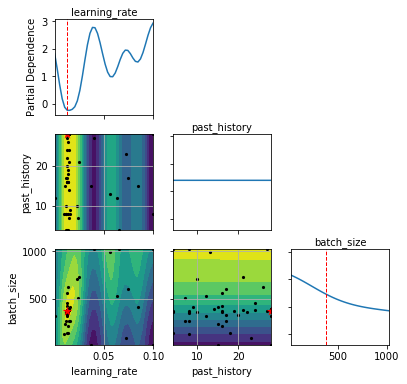

In [20]:
# extract and plot optimization results
dim_names = [
    'learning_rate',
    'past_history',
    'batch_size'
#     'class_0_weight',
#     'class_1_weight'
]

fig, ax = plot_objective(result=search_result, dimension_names=dim_names)
plt.savefig('../project_info/figures/single_LSTM_first_round_GPO.png', bbox_inches='tight')

### Re-train and evaluate winning model

Next: take the winning hyperparameters and conduct a long training run. This is our 'Cassandra' model. It represents the upper bound - how well can the output be modeled from the input?

In [22]:
# winning hyperparameters
space = search_result.space
winning_hyperparams = space.point_to_dict(search_result.x)
winning_hyperparams

{'learning_rate': 0.013163063744374572, 'past_history': 28, 'batch_size': 373}

In [23]:
# set up training run with winning values
learning_rate = winning_hyperparams['learning_rate']
past_history = winning_hyperparams['past_history']
batch_size = winning_hyperparams['batch_size']

dataset_len = len(training_data)
ignition_count = sum(training_data['ignition'])
no_ignition_count = dataset_len - ignition_count

weight_for_0 = (1 / no_ignition_count)*(dataset_len)/2.0 
weight_for_1 = (1 / ignition_count)*(dataset_len)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

EPOCHS = 350 # train longer than in optimization phase
batch_size = int((len(training_data) * 0.99) // past_history)
steps_per_epoch = int((len(training_data) * 0.99) // batch_size)
validation_steps = int((len(validation_data) * 0.99) // batch_size)

In [24]:
# reprep data with winning past history length
x_train, y_train = data_functions.multivariate_data(
    training_data,
    past_history,
    future_target, 
    step
)

start_index = (x_train.shape[0] - (x_train.shape[0] % batch_size))
end_index = x_train.shape[0]
x_train = np.delete(x_train, range(start_index, end_index), axis=0)
y_train = np.delete(y_train, range(start_index, end_index), axis=0)

print(f'Training data shape: {x_train.shape}')
print(f'Training label shape: {x_train.shape}')
print()

x_validation, y_validation = data_functions.multivariate_data(
    validation_data,
    past_history,
    future_target, 
    step
)

start_index = (x_validation.shape[0] - (x_validation.shape[0] % batch_size))
end_index = x_validation.shape[0]
x_validation = np.delete(x_validation, range(start_index, end_index), axis=0)
y_validation = np.delete(y_validation, range(start_index, end_index), axis=0)

print(f'Validation data shape: {x_validation.shape}')
print(f'Validation label shape: {x_validation.shape}')
print()

x_test, y_test = data_functions.multivariate_data(
    test_data,
    past_history,
    future_target, 
    step
)

start_index = (x_test.shape[0] - (x_test.shape[0] % batch_size))
end_index = x_test.shape[0]
x_test = np.delete(x_test, range(start_index, end_index), axis=0)
y_test = np.delete(y_test, range(start_index, end_index), axis=0)

print(f'Test data shape: {x_test.shape}')
print(f'Test label shape: {x_test.shape}')

input_dim = x_test.shape[-2:]
input_shape = (batch_size, input_dim[0], input_dim[1])

Training data shape: (3248, 28, 15)
Training label shape: (3248, 28, 15)

Validation data shape: (3248, 28, 15)
Validation label shape: (3248, 28, 15)

Test data shape: (2088, 28, 15)
Test label shape: (2088, 28, 15)


In [25]:
# rebuild model with winning hyperparameters
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.GRU(
    100,
    stateful = False,
    dropout = 0.3
))

model.add(tf.keras.layers.Dense(
    1,
    activation = 'sigmoid',
    bias_initializer = output_bias)
)

model.compile(
    optimizer = tf.keras.optimizers.Adam(lr = learning_rate), 
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = metrics
)

In [26]:
%%time

# train
log_dir = f'./LSTM_logs/single_statefull_optimization_round1/'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(
    x_train,
    y_train,
    epochs = EPOCHS,
    batch_size = batch_size,
    steps_per_epoch = steps_per_epoch,
    callbacks = [tensorboard_callback],
    validation_data = (x_validation, y_validation),
    validation_steps = validation_steps,
    class_weight = class_weight,
    verbose = 0
)

CPU times: user 12min 9s, sys: 51.5 s, total: 13min
Wall time: 7min 55s


Total observations: 3287


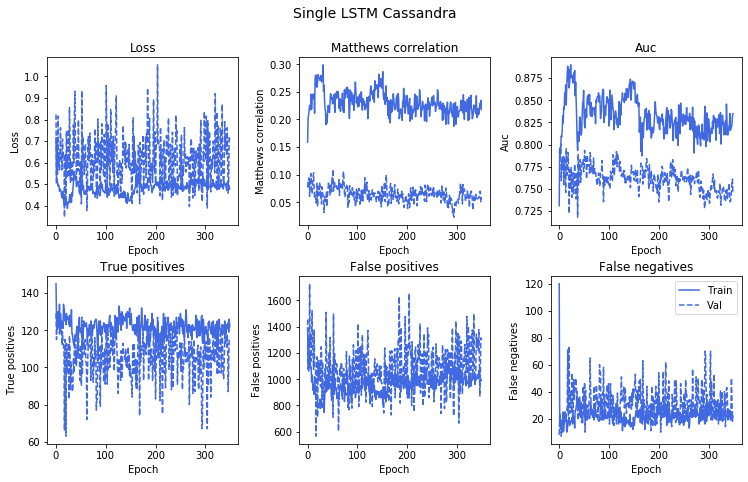

In [27]:
# plot learning curves
metric_names =  ['loss', 'matthews_correlation', 'auc', 'true_positives', 'false_positives', 'false_negatives']
filename = '../project_info/figures/single_LSTM_cassandra_learning_curves.png'
print(f"Total observations: {len(training_data)}")

plotting_functions.plot_metrics('Single LSTM Cassandra', history, metric_names, filename)

As expected, the training curves look pretty bad - the model is clearly over fit. But it does look like it was able to drive the loss to near zero.

In [28]:
# use trained model to make predictions from training, validation and testing data
train_predictions = model.predict(x_train, batch_size = batch_size)
validation_predictions = model.predict(x_validation, batch_size = batch_size)
test_predictions = model.predict(x_test, batch_size = batch_size)

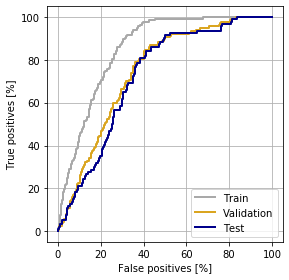

In [29]:
# plot ROC for all three datasets
plotting_functions.plot_roc("Train", y_train, train_predictions, color='darkgray')
plotting_functions.plot_roc("Validation", y_validation, validation_predictions, color='goldenrod')
plotting_functions.plot_roc("Test", y_test, test_predictions, color='darkblue')
plt.legend(loc='lower right')
plt.savefig('../project_info/figures/single_LSTM_cassandra_ROC.png', bbox_inches='tight')
plt.show()

Not surprisingly, the ROC curve also indicates extreme over fitting. The area under the training curve is almost 1, but is much less for the validation and test sets.

Now, for fun, let's take a look at some specific predictions and see what the actual output from the model looks like.

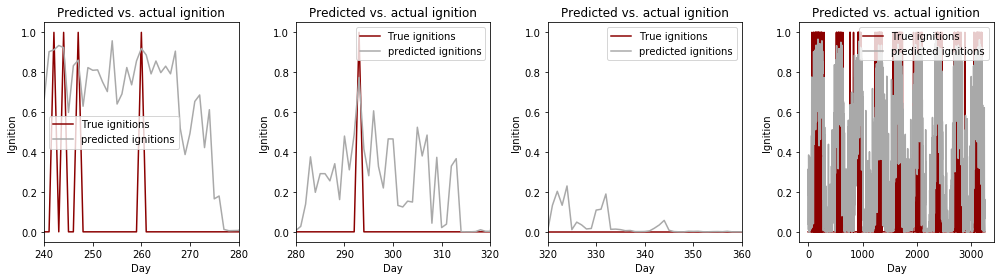

In [30]:
# plot training predictions vs actual ignitions
filename = '../project_info/figures/single_LSTM_cassandra_training_predictions.png'
plotting_functions.plot_ignition_predictions(train_predictions, y_train, filename)

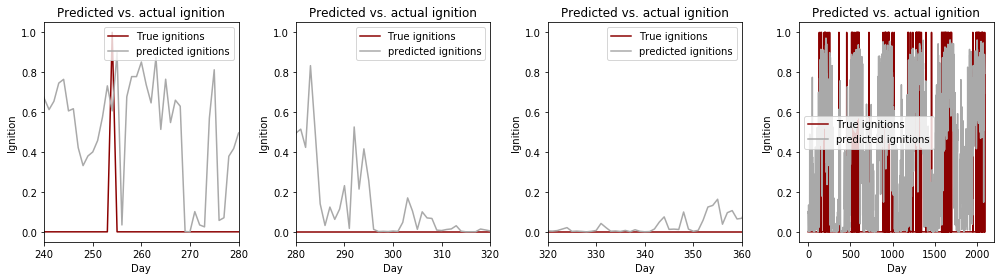

In [31]:
# plot test data predictions vs actual ignitions
filename = '../project_info/figures/single_LSTM_cassandra_test_predictions.png'
plotting_functions.plot_ignition_predictions(test_predictions, y_test, filename)

Last thing to take a look at are the confusion matrices for the training and test sets:


Training data prediction results
No fire (True Negatives):  1925
False alarms (False Positives):  1179
Fires missed (False Negatives):  6
Fires detected (True Positives):  138
Total fires:  144

Test data prediction results
No fire (True Negatives):  1140
False alarms (False Positives):  854
Fires missed (False Negatives):  15
Fires detected (True Positives):  79
Total fires:  94


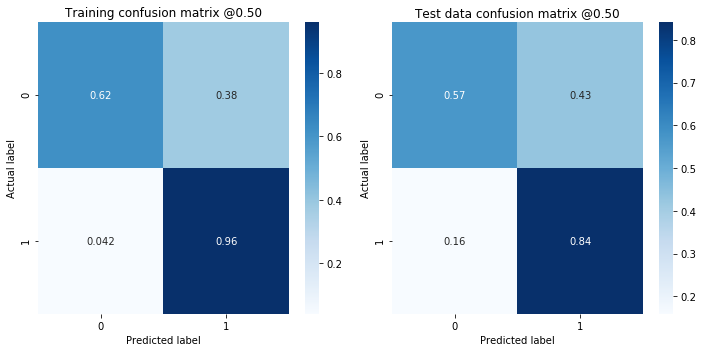

In [32]:
# results = model.evaluate(
#     x_train,
#     y_train,
#     batch_size = batch_size,
#     verbose=0
# )

# for name, value in zip(model.metrics_names, results):
#     print(name, ': ', value)
    
filename = '../project_info/figures/single_LSTM_cassandra_confusion_matrices.png'
plotting_functions.plot_cm(y_train, train_predictions, y_test, test_predictions, filename)

Results look great - despite the over fitting. Remember, over fitting was the goal. We have seen conclusively that their is enough information in the data and enough power in a LSTM to memorize the training set. This was not possible with gradient boosting decision trees or even deep neural networks. Now the task its to regularize the model so that it generalizes well.

# 3. GRU optimization - regularize model & generalizability

Now that we know a GRU can learn the training data, let's see how well we can get it to generalize to unseen test data. To do this we will run a second GPO round with the following changes:

1. Number of GRU units will be added as a tunable parameter, and capped at 5 to reduce model complexity (this is also helpful for scaling the model)
2. Variational dropout will be added to the GRU layer as a tunable parameter
3. Gaussian optimization and early stopping will use Matthews correlation on the validation set rather than the training set

At the same time, we will reoptimize the learning rate, class weights and past history, in case the optimum setting for those hyperparamters depend on the others.

### Set up gaussian process optimization

In [40]:
path_best_model = './trained_models/second_round_single_LSTM_optimization.keras'
best_val_matthews_correlation = -1.0

dim_learning_rate = Real(
    low=0.0001,
    high=0.1, 
    name='learning_rate'
)

dim_past_history = Integer(
    low=1,
    high=28, 
    name='past_history'
)

# dim_class_0_weight = Real(
#     low=0.001, 
#     high=10,
#     name='class_0_weight'
# )

# dim_class_1_weight = Real(
#     low=0.01, 
#     high=100,
#     name='class_1_weight'
# )

dim_lstm_units = Integer(
    low=1, 
    high=10,
    name='lstm_units'
)

dim_variational_dropout = Real(
    low=0.01, 
    high=0.5,
    name='variational_dropout'
)

default_parameters = [learning_rate, past_history, 1, 0.1]

dimensions = [
    dim_learning_rate,
    dim_past_history,
#     dim_class_0_weight,
#     dim_class_1_weight,
    dim_lstm_units,
    dim_variational_dropout
]

# Use early stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_matthews_correlation', 
    patience = 10,
    mode = 'max',
    restore_best_weights = True
)


future_target = 1
step = 1
EPOCHS = 50

# also set initial value for output bias based on fire frequency
# raw_output_bias = np.log([num_fires/(total_observations - num_fires)])
# output_bias = tf.keras.initializers.Constant(raw_output_bias)

path_best_model = './trained_models/first_round_single_LSTM_optimization.keras'
best_matthews_correlation = -1.0

run_num = 1

In [41]:
def make_model(
        input_shape,
        learning_rate,
        lstm_units,
        variational_dropout,
):    
    
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.GRU(
        lstm_units,
        batch_input_shape = input_shape,
        dropout = variational_dropout,
        stateful = False
    ))
    
    model.add(tf.keras.layers.Dense(
        1,
        activation = 'sigmoid',
        bias_initializer = output_bias)
    )

    model.compile(
        optimizer = tf.keras.optimizers.Adam(lr = learning_rate), 
        loss = keras.losses.BinaryCrossentropy(),
        metrics = metrics
    )

    return model

@use_named_args(dimensions=dimensions)
def fitness(
    learning_rate,
    past_history,
#     class_0_weight,
#     class_1_weight,
    lstm_units,
    variational_dropout
):
    # calculate batch and steps from past history size
    batch_size = int((len(training_data) * 0.99) // past_history)
    steps_per_epoch = int((len(training_data) * 0.99) // batch_size)
    validation_steps = int((len(validation_data) * 0.99) // batch_size)
    
    dataset_len = len(training_data)
    ignition_count = sum(training_data['ignition'])
    no_ignition_count = dataset_len - ignition_count
    
    weight_for_0 = (1 / no_ignition_count)*(dataset_len)/2.0 
    weight_for_1 = (1 / ignition_count)*(dataset_len)/2.0

    class_weight = {0: weight_for_0, 1: weight_for_1}
    
    # create data sets
    x_train, y_train = data_functions.multivariate_data(
        training_data,
        past_history,
        future_target, 
        step
    )
    
    x_validation, y_validation = data_functions.multivariate_data(
        validation_data,
        past_history,
        future_target, 
        step
    )
    
    # trim datasets so they are a whole number factor of the batch size
    start_index = (x_train.shape[0] - (x_train.shape[0] % batch_size))
    end_index = x_train.shape[0]
    
    x_train = np.delete(x_train, range(start_index, end_index), axis=0)
    y_train = np.delete(y_train, range(start_index, end_index), axis=0)
    
    start_index = (x_validation.shape[0] - (x_validation.shape[0] % batch_size))
    end_index = x_validation.shape[0]
    
    x_validation = np.delete(x_validation, range(start_index, end_index), axis=0)
    y_validation = np.delete(y_validation, range(start_index, end_index), axis=0)
    
    input_dim = x_train.shape[-2:]
    input_shape = (batch_size, input_dim[0], input_dim[1])
    
    # Create the neural network with these hyper-parameters.
    model = make_model(
        input_shape = input_shape,
        learning_rate = learning_rate,
        lstm_units = lstm_units,
        variational_dropout = variational_dropout,
    )
    
    # Create a callback-function for Keras which will be
    # run after each epoch has ended during training.
    # This saves the log-files for TensorBoard.
    # Note that there are complications when histogram_freq=1.
    # It might give strange errors and it also does not properly
    # support Keras data-generators for the validation-set.
    global run_num
    
    log_dir = f'./LSTM_logs/single_statefull_gp_min_run{run_num}/'
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
   
    # Use Keras to train the model.
    history = model.fit(
        x_train,
        y_train,
        epochs = EPOCHS,
        batch_size = batch_size,
        steps_per_epoch = steps_per_epoch,
        callbacks = [early_stopping_callback],
        validation_data = (x_validation, y_validation),
        validation_steps = validation_steps,
        class_weight = class_weight,
        workers = 8,
        verbose = 0
    )

    # Get MCC for training run
    matthews_correlation = history.history['val_matthews_correlation'][-1]

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_matthews_correlation

    # If the MCC of the saved model is improved ...
    if matthews_correlation > best_matthews_correlation:
        # Save the new model to harddisk.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_matthews_correlation = matthews_correlation
        
    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    
    run_num += 1
    
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST MCC, we need to 
    # negate this number so it can be minimized.
    return -matthews_correlation

### Run gaussian process optimization

In [42]:
%%time

# do GPO
search_result = gp_minimize(
    func = fitness,
    dimensions = dimensions,
    acq_func = 'EI', # Expected Improvement.
    n_calls = 50,
    x0 = default_parameters
)

CPU times: user 9min 36s, sys: 35.5 s, total: 10min 12s
Wall time: 5min 46s


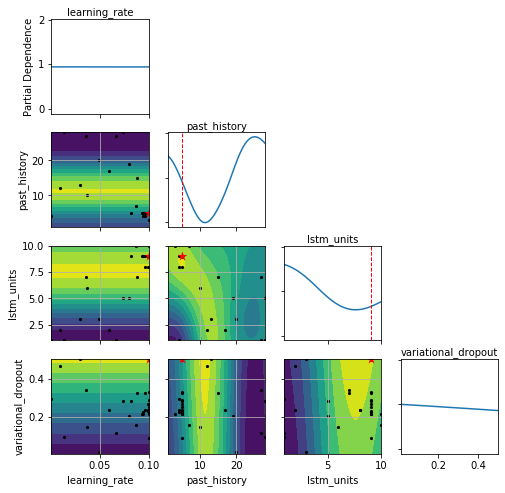

In [43]:
# extract winning hyperparameters
dim_names = [
    'learning_rate',
    'past_history',
#     'class_0_weight',
#     'class_1_weight',
    'lstm_units',
    'variational_dropout'
]

fig, ax = plot_objective(result = search_result, dimension_names = dim_names)
plt.savefig('../project_info/figures/single_LSTM_second_round_GPM.png', bbox_inches='tight')

### Re-train and evaluate winning model

In [44]:
space = search_result.space
winning_hyperparams = space.point_to_dict(search_result.x)
winning_hyperparams

{'learning_rate': 0.1,
 'past_history': 5,
 'lstm_units': 9,
 'variational_dropout': 0.5}

In [45]:
# hyperparameters
# learning_rate = winning_hyperparams['learning_rate']
# lstm_units = winning_hyperparams['lstm_units']

# learning_rate = 0.001
# past_history = 5
# class_0_weight = 6.3720941191248395
# class_1_weight = 94.18261239534365
# lstm_units = 1
# variational_dropout = 0.4

learning_rate = winning_hyperparams['learning_rate']
past_history = winning_hyperparams['past_history']
# class_0_weight = winning_hyperparams['class_0_weight']
# class_1_weight = winning_hyperparams['class_1_weight']
lstm_units = winning_hyperparams['lstm_units']
variational_dropout = winning_hyperparams['variational_dropout']

# class_weight = {0: class_0_weight, 1: class_1_weight}

EPOCHS = 500
batch_size = int((len(test_data) * 0.99) // past_history)
steps_per_epoch = int((len(training_data) * 0.99) // batch_size)
validation_steps = int((len(validation_data) * 0.99) // batch_size)

In [46]:
print(f'Past history {past_history}')
print(f'Batch size: {batch_size}')
print(f'Steps per epoch: {steps_per_epoch}')

Past history 5
Batch size: 433
Steps per epoch: 7


In [47]:
x_train, y_train = data_functions.multivariate_data(
    training_data,
    past_history,
    future_target, 
    step
)

start_index = (x_train.shape[0] - (x_train.shape[0] % batch_size))
end_index = x_train.shape[0]
x_train = np.delete(x_train, range(start_index, end_index), axis=0)
y_train = np.delete(y_train, range(start_index, end_index), axis=0)

x_validation, y_validation = data_functions.multivariate_data(
    validation_data,
    past_history,
    future_target, 
    step
)

start_index = (x_validation.shape[0] - (x_validation.shape[0] % batch_size))
end_index = x_validation.shape[0]
x_validation = np.delete(x_validation, range(start_index, end_index), axis=0)
y_validation = np.delete(y_validation, range(start_index, end_index), axis=0)

x_test, y_test = data_functions.multivariate_data(
    test_data,
    past_history,
    future_target, 
    step
)

start_index = (x_test.shape[0] - (x_test.shape[0] % batch_size))
end_index = x_test.shape[0]
x_testing = np.delete(x_test, range(start_index, end_index), axis=0)
y_testing = np.delete(y_test, range(start_index, end_index), axis=0)

input_dim = x_testing.shape[-2:]
input_shape = (batch_size, input_dim[0], input_dim[1])

In [50]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.GRU(
    lstm_units,
    batch_input_shape = input_shape,
    dropout = variational_dropout,
    stateful = False
))

model.add(tf.keras.layers.Dense(
    1,
    activation = 'sigmoid',
    bias_initializer = output_bias)
)

model.compile(
    optimizer = tf.keras.optimizers.Adam(lr = learning_rate), 
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = metrics
)

In [51]:
%%time

history = model.fit(
    x_train,
    y_train,
    epochs = EPOCHS,
    batch_size = batch_size,
    steps_per_epoch = steps_per_epoch,
    #callbacks = [early_stopping_callback],
    validation_data = (x_validation, y_validation),
    validation_steps = validation_steps,
    class_weight = class_weight,
    workers = 8,
    verbose = 0
)

CPU times: user 1min 49s, sys: 10.9 s, total: 2min
Wall time: 1min 1s


Total observations: 3287


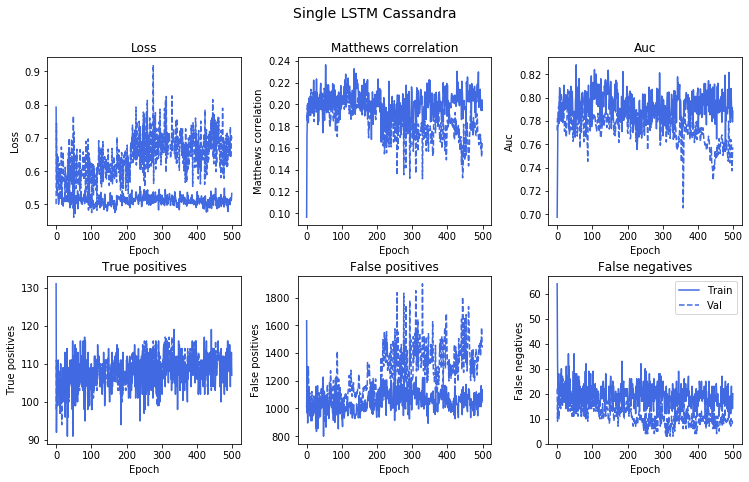

In [52]:
# plot learning curves
metric_names =  ['loss', 'matthews_correlation', 'auc', 'true_positives', 'false_positives', 'false_negatives']
filename = '../project_info/figures/single_LSTM_optimized_learning_curves.png'
print(f"Total observations: {len(training_data)}")

plotting_functions.plot_metrics('Single LSTM Cassandra', history, metric_names, filename)

In [53]:
train_predictions = model.predict(x_train, batch_size = batch_size)
validation_predictions = model.predict(x_validation, batch_size = batch_size)
test_predictions = model.predict(x_testing, batch_size = batch_size)

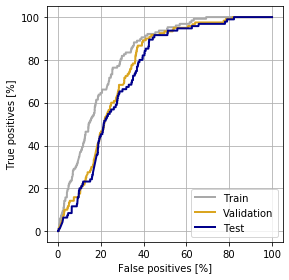

In [54]:
plotting_functions.plot_roc("Train", y_train, train_predictions, color='darkgray')
plotting_functions.plot_roc("Validation", y_validation, validation_predictions, color='goldenrod')
plotting_functions.plot_roc("Test", y_testing, test_predictions, color='darkblue')
plt.legend(loc='lower right')
plt.show()

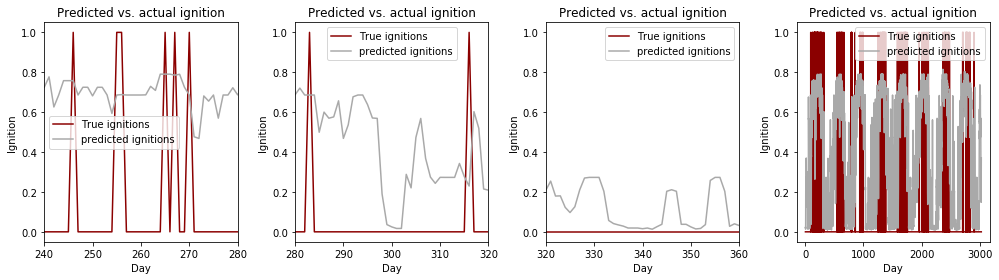

In [55]:
filename = '../project_info/figures/single_LSTM_optimized_training_predictions.png'
plotting_functions.plot_ignition_predictions(train_predictions, y_train, filename)

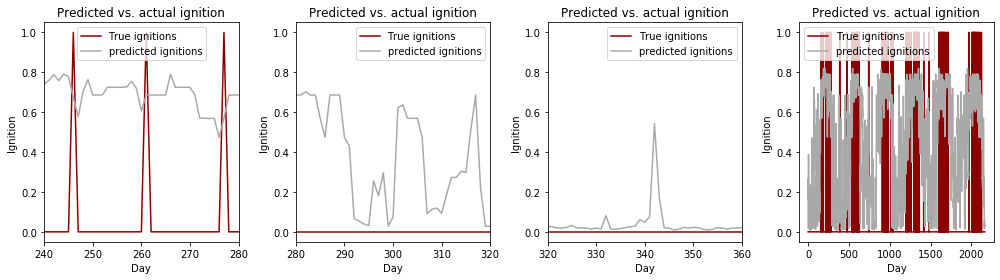

In [56]:
filename = '../project_info/figures/single_LSTM_optimized_testing_predictions.png'
plotting_functions.plot_ignition_predictions(test_predictions, y_testing, filename)


Training data prediction results
No fire (True Negatives):  1572
False alarms (False Positives):  1332
Fires missed (False Negatives):  9
Fires detected (True Positives):  118
Total fires:  127

Test data prediction results
No fire (True Negatives):  1019
False alarms (False Positives):  1051
Fires missed (False Negatives):  8
Fires detected (True Positives):  87
Total fires:  95


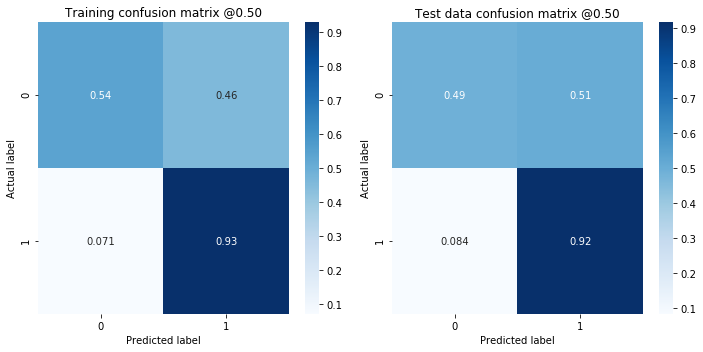

In [57]:
# results = model.evaluate(
#     x_train,
#     y_train, 
#     verbose=0
# )

# for name, value in zip(model.metrics_names, results):
#     print(name, ': ', value)
    
filename = '../project_info/figures/single_LSTM_optimizedweather_confusion_matrices.png'
plotting_functions.plot_cm(y_train, train_predictions, y_testing, test_predictions, filename)